Pre-visualization of the normalized count data

**Need to run first:**
- [`../0-prepare_data`](../0-prepare_data.ipynb)
- [`1-extract_samples`](1-extract_samples.ipynb)
- [`2-run_dge_analysis`](2-run_dge_analysis.ipynb)

**Table of content**

1. [Check samples and genes with normalized counts](#Check-samples-and-genes-with-normalized-counts)
    1. [Check for artefact due to FACS sorting](#Check-for-artefact-due-to-FACS-sorting)
    2. [Check for contamination from other cell types that could have escaped the sorting-gating](#Check-for-contamination-from-other-cell-types-that-could-have-escaped-the-sorting-gating)
2. [Filter contamination genes and contaminated samples](#Filter-contamination-genes-and-contaminated-samples)
3. [Sample-to-sample distance, clustering and PCA](#Sample-to-sample-distance,-clustering-and-PCA)
    1. [Clustering](#Clustering)
        1. [Ward D2](#Ward-D2)
        1. [Kmeans](#Kmeans)
    2. [Sample-to-sample heatmap](#Sample-to-sample-heatmap)
    3. [PCA on the normalized counts](#PCA-on-the-normalized-counts)
        1. [With all factors](#With-all-factors)
        2. [GF vs SPF](#GF-vs-SPF)
        3. [Age](#Age)
4. [Z-scores (normalized counts) for all genes](Z-scores-(normalized-counts)-for-all-genes)
    1. [All genes](#All-genes)
    2. [GF signature genes](#GF-signature-genes)
5. [Gene co-expression analysis](#Gene-co-expression-analysis)
    1. [Extract modules of co-expressed genes](#Extract-modules-of-co-expressed-genes)
    2. [Relationship between modules and samples](#Relationship-between-modules-and-samples)
    3. [Genes in modules](#Genes-in-modules)
        1. [Heatmaps with Z-scores](#Heatmaps-with-Z-scores)
        2. [Sinaplots of the Z-scores per groups](#Sinaplots-of-the-Z-scores-per-groups)
        3. [Selected genes in modules](#Selected-genes-in-modules)
        4. [Genes related to ROS](#Genes-related-to-ROS)
    4. [Enrichment analysis in modules](#Enrichment-analysis-in-modules)
    
*Generated from a Jupyter Notebook - [Sources](https://github.com/bebatut/neuromac_GF_mices/blob/master/src/microbiota-driven/3-previsualize_data.ipynb)*

# Load

## Libraries and functions

In [1]:
source("load_libraries.R")

Warning message:
“package ‘gplots’ was built under R version 4.1.3”
Warning message:
“package ‘WGCNA’ was built under R version 4.1.3”


Allowing multi-threading with up to 8 threads.


Warning message:
“package ‘reshape’ was built under R version 4.1.3”
preparing gene to GO mapping data...

preparing IC data...

preparing gene to GO mapping data...

preparing IC data...

preparing gene to GO mapping data...

preparing IC data...



In [2]:
source("functions.R")

## Data

In [3]:
dp = "../results/dge/"
plot_dp = paste(dp, "3-previsualize_data/", sep='')
dir.create(plot_dp, showWarnings = FALSE)

In [4]:
load(paste(dp, "metadata.RData", sep=''))
load(paste(dp, "norm_counts.RData", sep=''))
load(paste(dp, "z_scores.RData", sep=''))

In [5]:
metadata

Microbiota Age   sample          project
1  GF         Old   GF_104w_M_1_2   S264   
2  GF         Old   GF_104w_M_2_2   S264   
3  GF         Old   GF_104w_M_3_2   S288   
4  GF         Old   GF_104w_M_4_2   S288   
5  GF         Old   GF_104w_M_5_2   S288   
6  GF         Young GF_8w_M_1_2     S148   
7  GF         Young GF_8w_M_2_2     S148   
8  GF         Young GF_8w_M_3_2     S148   
9  GF         Young GF_8w_M_4_2     S148   
10 SPF        Old   SPF_104w_M_1_2  S174   
11 SPF        Old   SPF_104w_M_10_2 S198   
12 SPF        Old   SPF_104w_M_11_2 S198   
13 SPF        Old   SPF_104w_M_12_2 S198   
14 SPF        Old   SPF_104w_M_13_2 S198   
15 SPF        Old   SPF_104w_M_14_2 S198   
16 SPF        Old   SPF_104w_M_2_2  S174   
17 SPF        Old   SPF_104w_M_3_2  S174   
18 SPF        Old   SPF_104w_M_4_2  S174   
19 SPF        Old   SPF_104w_M_5_2  S198   
20 SPF        Old   SPF_104w_M_6_2  S198   
21 SPF        Old   SPF_104w_M_7_2  S198   
22 SPF        Old   SPF_104w_M_8_2  S198   
23 SPF        Old   SPF_104w_M_9_2  S198   
24 SPF        Young SPF_8w_M_2_2    S148   
25 SPF        Young SPF_8w_M_3_2    S148   
26 SPF        Young SPF_8w_M_4_2    S148

In [6]:
trait = list()

i = 'Groups'
trait[[i]] = metadata %>%
    mutate("Young" = as.integer(Age == "Young")) %>%
    mutate("Old" = as.integer(Age == "Old")) %>%
    mutate("SPF" = as.integer(Microbiota == "SPF")) %>%
    mutate("GF" = as.integer(Microbiota == "GF")) %>%
    select(-c(Age, Microbiota, project)) 

i = 'Microbiota / Age'
trait[[i]] = metadata %>%
    mutate("SPF / Young" = as.integer(Microbiota == "SPF" & Age == "Young")) %>%
    mutate("SPF / Old" = as.integer(Microbiota == "SPF" & Age == "Old")) %>%
    mutate("GF / Young" = as.integer(Microbiota == "GF" & Age == "Young")) %>%
    mutate("GF / Old" = as.integer(Microbiota == "GF" & Age == "Old")) %>%
    select(-c(Age, Microbiota, project))

i = 'Age / Microbiota'
trait[[i]] = metadata %>%
    mutate("Young / SPF" = as.integer(Microbiota == "SPF" & Age == "Young")) %>%
    mutate("Young / GF" = as.integer(Microbiota == "GF" & Age == "Young")) %>%
    mutate("Old / SPF" = as.integer(Microbiota == "SPF" & Age == "Old")) %>%
    mutate("Old / GF" = as.integer(Microbiota == "GF" & Age == "Old")) %>%
    select(-c(Microbiota, Age, project))

In [7]:
col_order = list()
annot_col = list()

col_order$ma = metadata %>% arrange(Microbiota) %>% pull(sample)
annot_col$ma = as.data.frame(metadata %>%
    select(c("sample","Age", "Microbiota")) %>%
    mutate(Age = factor(Age, c("Young", "Old"))) %>%
    column_to_rownames('sample'))

col_order$am = metadata %>% arrange(Age) %>% pull(sample)
annot_col$am = as.data.frame(metadata %>%
    select(c("sample", "Microbiota", "Age")) %>%
    mutate(Age = factor(Age, c("Young", "Old"))) %>%
    column_to_rownames('sample'))

annot_colors = list()
annot_colors$Age = c("#ff82ec", "#e2b33a")
names(annot_colors$Age) = c("Young", "Old")
annot_colors$Microbiota = c("#65ce41","#c3a7f9")
names(annot_colors$Microbiota) = c("SPF", "GF")
save(annot_colors, file=paste(dp, "annot_colors.RData", sep=''))

# Check samples and specific genes

## Check for artefact due to FACS sorting

List of genes to check: Egr1, Jun, Zfp36l1, Malat1, Dusp1, Nr4a1, Fos

In [8]:
facs_genes = c('Egr1', 'Jun', 'Zfp36l1', 'Malat1', 'Dusp1', 'Nr4a1', 'Fos')

Normalized counts

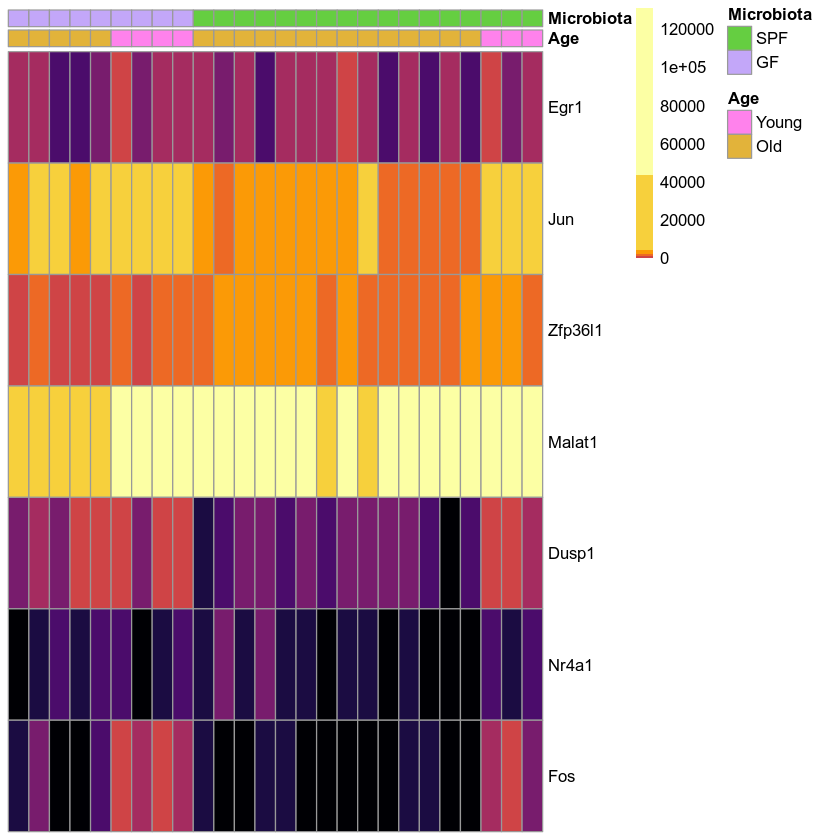

In [9]:
plot_heatmap(norm_counts,
             facs_genes,
             col_order$ma,
             annot_col$ma,
             show_rownames=TRUE)

Z-scores

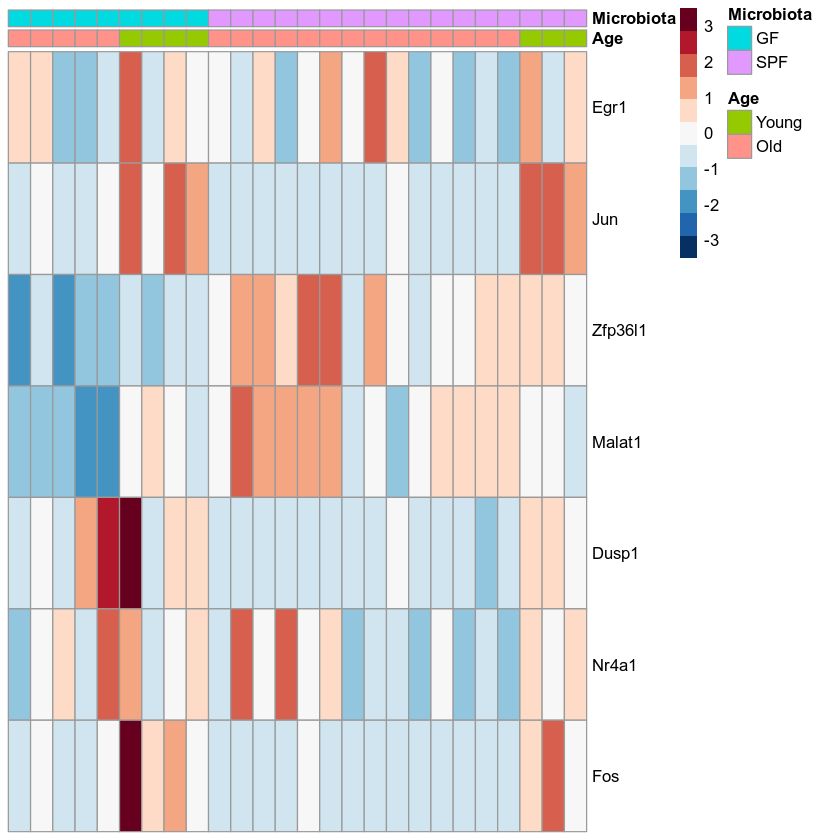

In [10]:
pheatmap(z_scores[facs_genes, col_order$ma],
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_col=as.data.frame(annot_col$ma),
         annotation_row=NULL,
         annotation_colors=NULL,
         color=rev(brewer.pal(11, "RdBu")),
         breaks=seq(-3.5, 3.5, length=12))

## Check for contamination from other cell types that could have escaped the sorting gating

In [11]:
core_signature_genes = list()
core_signature_genes$microglia = c('Tmem119', 'Hexb', 'Scl2a5', 'P2ry12', 'Siglech', 'Trem2', 'P2ry13')
core_signature_genes$macrophage = c('Mrc1', 'Cd163', 'Lyve1', 'Siglec1', 'Pf4')
core_signature_genes$monocyte = c('Ly6c2', 'Ccr2', 'Anxa8', 'Nr4a1', 'Plac8')
core_signature_genes$dc = c('Flt3', 'Zbtb46', 'Itgae', 'Batf3', 'Clec9a')
core_signature_genes$granulocyte = c('Mpo', 'Ngp', 'Wfdc17', 'Ly6g')
core_signature_genes$t = c('Trbc1', 'Trbc2', 'Cd3e', 'Cd3d', 'Nkg7')
core_signature_genes$b= c('Cd79a', 'Igkc', 'Ighm', 'Cd19', 'Ebf1')
core_signature_genes$mast = c('Tpsb2', 'Mcpt4', 'Cma1', 'Cpa3')
core_signature_genes$nk = c('NKp46', 'NK1.1', 'NKG2D', 'Gzmb', 'Eomes', 'Tbet')
core_signature_gene_df = melt(core_signature_genes) %>%
    rename(genes = value) %>%
    rename(cell = L1)
removed_genes = core_signature_gene_df %>%
    filter(!(genes %in% rownames(z_scores)))
core_signature_gene_df = core_signature_gene_df %>%
    filter(genes %in% rownames(z_scores))
core_signature_gene_df

genes   cell       
1  Tmem119 microglia  
2  Hexb    microglia  
3  P2ry12  microglia  
4  Siglech microglia  
5  Trem2   microglia  
6  P2ry13  microglia  
7  Mrc1    macrophage 
8  Cd163   macrophage 
9  Lyve1   macrophage 
10 Siglec1 macrophage 
11 Pf4     macrophage 
12 Ly6c2   monocyte   
13 Ccr2    monocyte   
14 Nr4a1   monocyte   
15 Plac8   monocyte   
16 Flt3    dc         
17 Zbtb46  dc         
18 Itgae   dc         
19 Batf3   dc         
20 Clec9a  dc         
21 Mpo     granulocyte
22 Ngp     granulocyte
23 Wfdc17  granulocyte
24 Cd3e    t          
25 Nkg7    t          
26 Cd79a   b          
27 Cd19    b          
28 Ebf1    b          
29 Tpsb2   mast       
30 Gzmb    nk         
31 Eomes   nk

Genes in list, but not in the counts

In [12]:
removed_genes

genes  cell       
1  Scl2a5 microglia  
2  Anxa8  monocyte   
3  Ly6g   granulocyte
4  Trbc1  t          
5  Trbc2  t          
6  Cd3d   t          
7  Igkc   b          
8  Ighm   b          
9  Mcpt4  mast       
10 Cma1   mast       
11 Cpa3   mast       
12 NKp46  nk         
13 NK1.1  nk         
14 NKG2D  nk         
15 Tbet   nk

Normalized counts

In [13]:
cell_annot_colors = annot_colors
cell_annot_colors$Cell = c("#56a4d0", "#d5682b", "#7b6fcb", "#a49f3d", "#c356b8", "#59a85f", "#d04659", "#b7794a", "#c0668e")
names(cell_annot_colors$Cell) = c("microglia", "macrophage", "monocyte", "dc", "granulocyte", "t", "b", "mast", "nk")

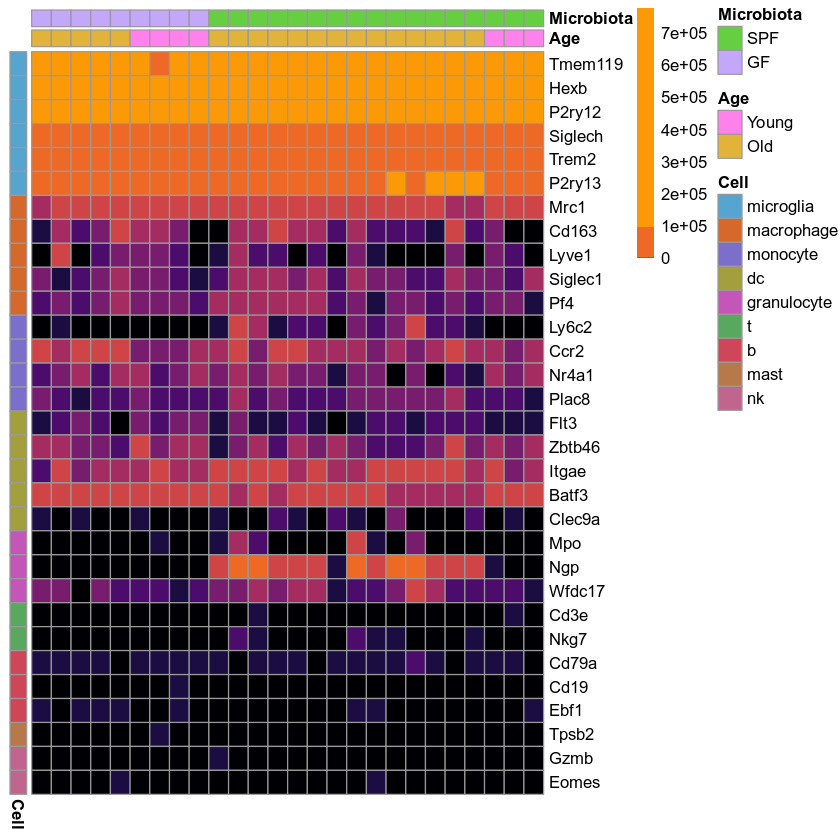

In [14]:
data = norm_counts[as.vector(core_signature_gene_df$genes), col_order$ma]
breaks = quantile_breaks(data, n = 11)
pheatmap(data,
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_colors=cell_annot_colors,
         annotation_col=annot_col$ma,
         annotation_row=data.frame(Cell=core_signature_gene_df$cell, row.names=core_signature_gene_df$genes),
         breaks=breaks,
         color=inferno(10))
pheatmap(data,
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_colors=cell_annot_colors,
         annotation_col=annot_col$ma,
         annotation_row=data.frame(Cell=core_signature_gene_df$cell, row.names=core_signature_gene_df$genes),
         breaks=breaks,
         color=inferno(10),
         filename=paste(plot_dp, "cell_type_gene_norm_counts.pdf", sep=''))
write.table(data, file=paste(plot_dp, "contamination.tsv", sep=''), sep='\t', quote=FALSE, row.names = FALSE)

Z-score

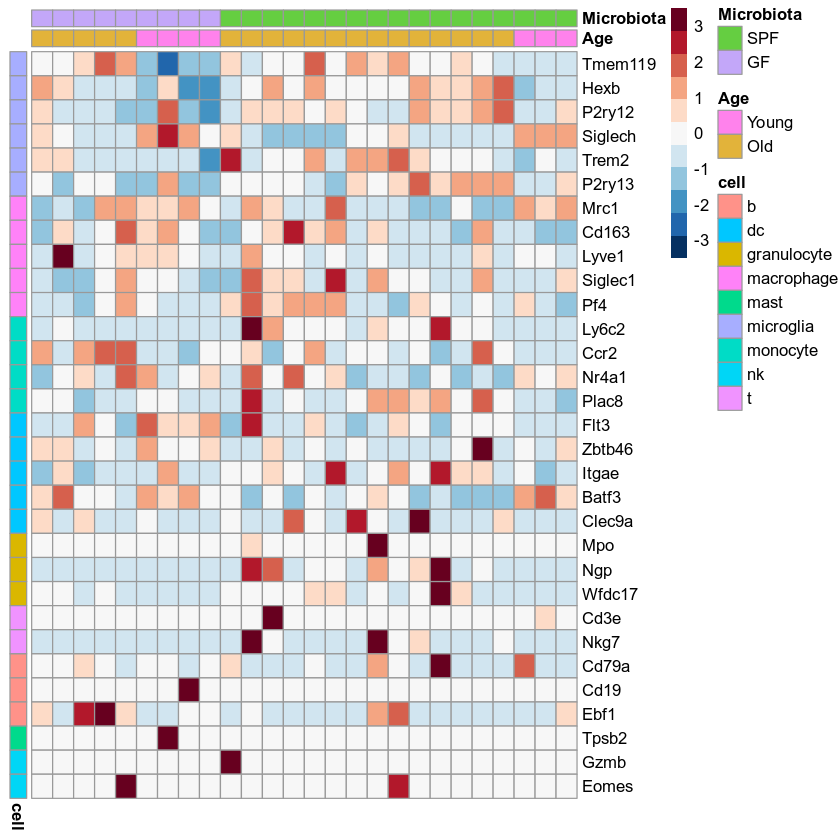

In [15]:
pheatmap(z_scores[as.vector(core_signature_gene_df$genes), col_order$ma],
         cluster_rows=F,
         cluster_cols=F,
         show_rownames=T,
         show_colnames=F,
         annotation_col=annot_col$ma,
         annotation_row=data.frame(cell=core_signature_gene_df$cell, row.names=core_signature_gene_df$genes),
         annotation_colors = cell_annot_colors,
         color=rev(brewer.pal(11, "RdBu")),
         breaks = seq(-3.5, 3.5, length=12))

# Filter contamination genes and contaminated samples

Genes that could be artefact due to FACS sorting or contamination from other cell types and samples that seem contaminated: 'GF_8w_M_2_2', 'SPF_52w_F_1_2', 'SPF_104w_M_3_2'

In [16]:
potentially_contaminated_samples = c('GF_8w_M_2_2', 'SPF_104w_M_3_2')

Filter the normalized counts (value before and )

In [17]:
original_norm_counts = norm_counts
norm_counts = data.frame(norm_counts) %>%
    rownames_to_column('genes') %>%
    filter(!genes %in% facs_genes) %>%
    filter(!genes %in% core_signature_genes$macrophage) %>%
    filter(!genes %in% core_signature_genes$monocyte) %>%
    filter(!genes %in% core_signature_genes$dc) %>%
    filter(!genes %in% core_signature_genes$granulocyte) %>%
    filter(!genes %in% core_signature_genes$t) %>%
    filter(!genes %in% core_signature_genes$b) %>%
    filter(!genes %in% core_signature_genes$mast) %>%
    filter(!genes %in% core_signature_genes$nk) %>% 
    filter(!genes %in% core_signature_genes$nk) %>% 
    select(-c(GF_8w_M_2_2, SPF_104w_M_3_2)) %>%
    filter_at(vars(-genes), any_vars(. > 0)) %>%
    column_to_rownames('genes')
dim(original_norm_counts)[1]-dim(norm_counts)[1]
save(norm_counts, file=paste(dp, "filtered_norm_counts.RData", sep=''))
write.table(norm_counts, paste(dp, "filtered_norm_counts", sep=''), sep = "\t", quote = FALSE)

[1] 93

In [18]:
mean_counts = apply(norm_counts, 1, mean)
sd_counts = apply(norm_counts, 1, sd)
z_scores = (norm_counts - mean_counts)/sd_counts
save(z_scores, file=paste(dp, "filtered_z_scores.RData", sep=''))
write.table(z_scores, paste(dp, "filtered_z_scores", sep=''), sep = "\t", quote = FALSE)

Filter the samples from annotations and metadata

In [19]:
for(i in 1:length(trait)){
    trait[[i]] = trait[[i]] %>%
        filter(!sample %in% potentially_contaminated_samples)
}
save(trait, file=paste(dp, "trait.RData", sep=''))

In [20]:
col_order = lapply(col_order, function(x) return(x[!x %in% potentially_contaminated_samples]))
annot_col = lapply(annot_col, function(x) return(x[!rownames(x) %in% potentially_contaminated_samples,]))
save(col_order, file=paste(dp, "col_order.RData", sep=''))
save(annot_col, file=paste(dp, "annot_col.RData", sep=''))

In [21]:
metadata = metadata %>%
    filter(!sample %in% potentially_contaminated_samples)
save(metadata, file=paste(dp, "filtered_metadata.RData", sep=''))

In [22]:
all_deg_genes = c()
save(all_deg_genes, file=paste(dp, "all_deg_genes.RData", sep=''))

# Sample-to-sample distance, clustering and PCA

In [23]:
sample_dist = t(norm_counts) %>% dist
sample_dist_matrix = as.matrix(sample_dist)

In [24]:
list_colors = unlist(annot_colors)
names(list_colors) = gsub("(Microbiota|Age)\\.","",names(list_colors))
colors = metadata %>%
         mutate(Age = gsub("Old", list_colors['Old'], Age)) %>%
         mutate(Age = gsub("Young", list_colors['Young'], Age)) %>%
         mutate(Microbiota = gsub("SPF", list_colors['SPF'], Microbiota)) %>%
         mutate(Microbiota = gsub("GF", list_colors['GF'], Microbiota)) %>%
         select(c("Age", "Microbiota", "sample")) %>%
         column_to_rownames('sample')
plot_clustering_tree = function(sampleTree) {
    par(mar = c(4,4,1,1))
    par(cex = 0.6)
    plot(sampleTree, leaflab="none")
    colored_bars(colors, sampleTree, rowLabels=colnames(colors), y_shift=0.5)
    legend("topright", fill=unlist(list_colors), names(list_colors), cex=0.7)
}

## Clustering

### Ward D2

In [25]:
sample_clust = sample_dist %>% hclust(method = "ward.D2") 

png 
  2

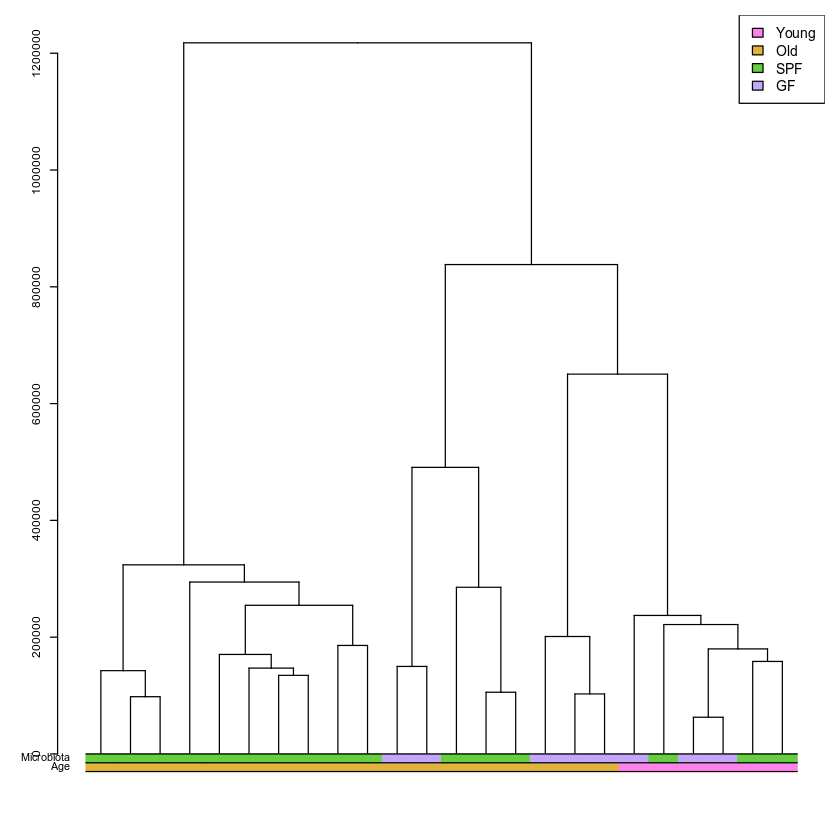

In [26]:
sample_clust_tree = sample_clust %>% as.dendrogram
plot_clustering_tree(sample_clust_tree)
pdf(paste(plot_dp, "dendogram.pdf", sep=''))
plot_clustering_tree(sample_clust_tree)
dev.off()

### Kmeans

Elbow method to compute the number of cluster

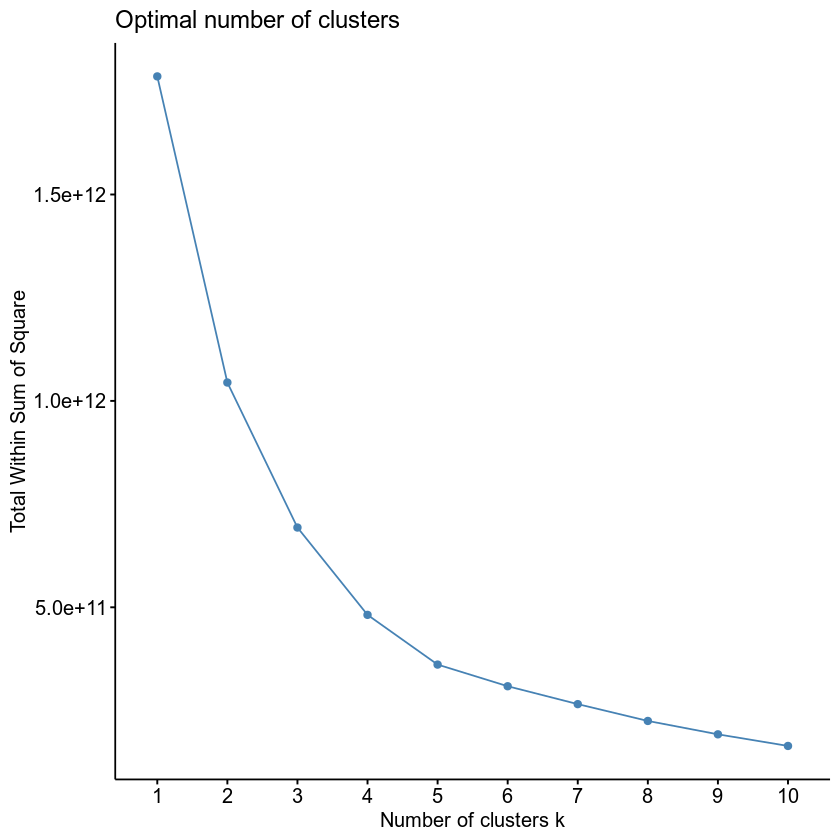

In [27]:
fviz_nbclust(t(norm_counts), diss=sample_dist, FUN=hcut, method="wss")

Average silhouette method to compute the number of cluster


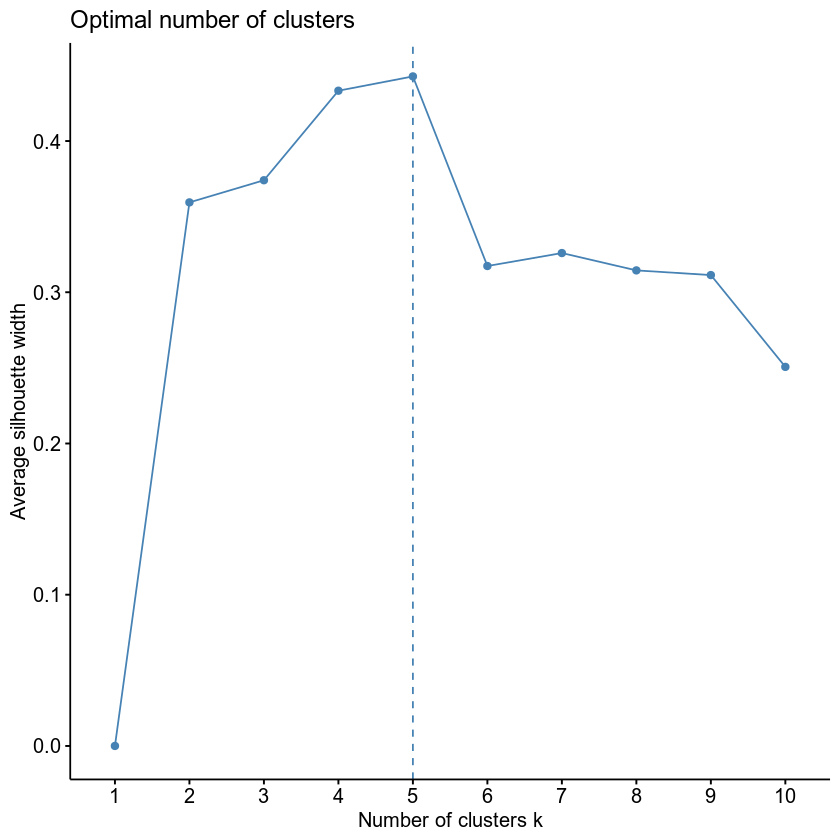

In [28]:
fviz_nbclust(t(norm_counts), diss=sample_dist, FUN=hcut, method="silhouette")

##### kmeans with 3 clusters

In [29]:
sample_clust_km = kmeans(sample_dist, 6)

Within cluster sum of square (*how similar each individual, within the cluster are. The smaller the number, the more similar inidivduals are*)

In [30]:
sample_clust_km$withinss

[1] 338795247455 117848006123 223743842082 371171785323 493188895357
[6]            0

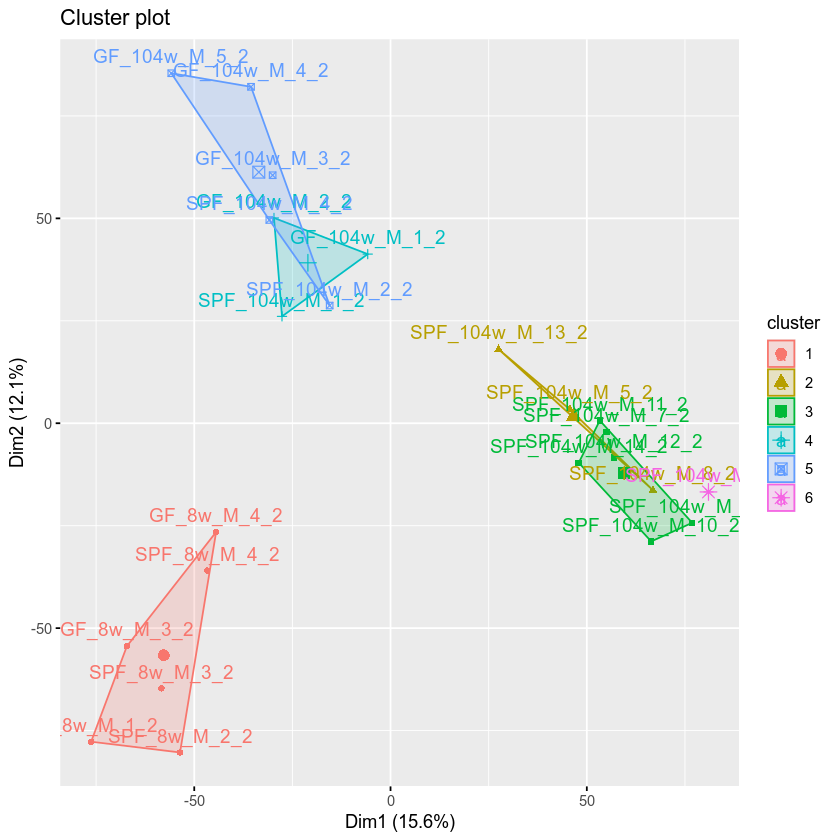

In [31]:
fviz_cluster(sample_clust_km, t(norm_counts))

In [32]:
clust_metadata = metadata %>%
    select(-project) %>%
    add_column(Cluster = as.factor(sample_clust_km$cluster)) %>%
    column_to_rownames('sample')
clust_size = count(clust_metadata, Cluster) %>%
    rename( Total = n)

In [33]:
count(clust_metadata, Cluster, Microbiota) %>% 
    spread(Microbiota, n, fill = 0) %>%
    full_join(clust_size, by='Cluster')
count(clust_metadata, Cluster, Age) %>% 
    spread(Age, n, fill = 0) %>%
    full_join(clust_size, by='Cluster')

Cluster GF SPF Total
1 1       3  3   6    
2 2       0  3   3    
3 3       0  6   6    
4 4       2  1   3    
5 5       3  2   5    
6 6       0  1   1

Cluster Old Young Total
1 1       0   6     6    
2 2       3   0     3    
3 3       6   0     6    
4 4       3   0     3    
5 5       5   0     5    
6 6       1   0     1

In [34]:
count(clust_metadata, Cluster, Microbiota, Age) %>%
    mutate(SA = paste(Microbiota, Age, sep=' - ')) %>%
    select(-c(Microbiota, Age)) %>%
    spread(SA, n, fill = 0) %>%
    full_join(clust_size, by='Cluster')

Cluster GF - Old GF - Young SPF - Old SPF - Young Total
1 1       0        3          0         3           6    
2 2       0        0          3         0           3    
3 3       0        0          6         0           6    
4 4       2        0          1         0           3    
5 5       3        0          2         0           5    
6 6       0        0          1         0           1

## Sample-to-sample heatmap

Ward D2 clustering for the rows and cols

png 
  2

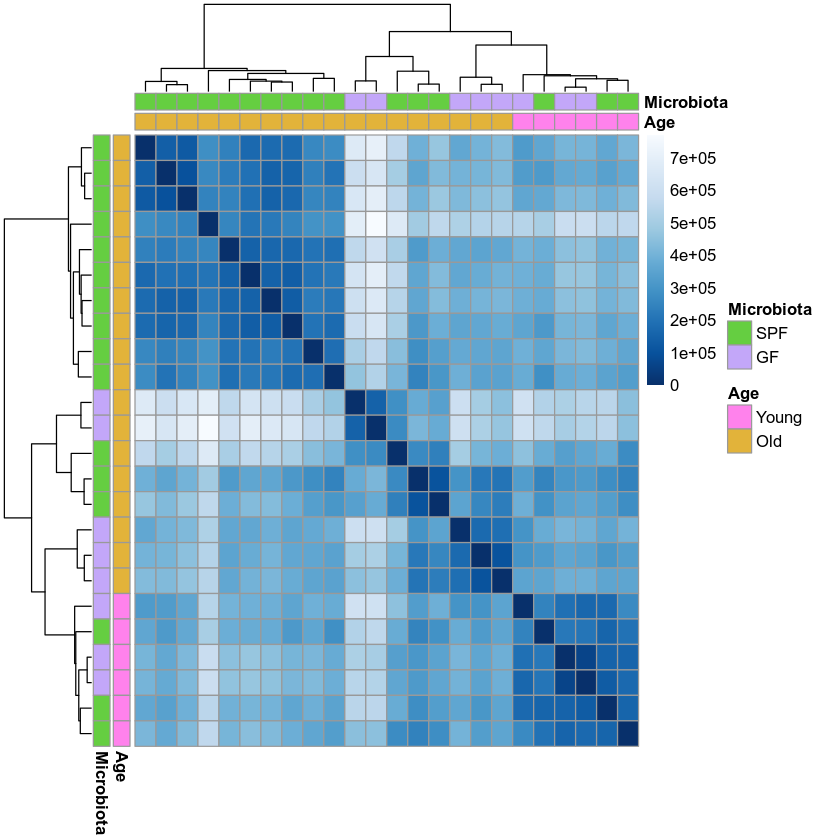

In [35]:
xx = pheatmap(sample_dist_matrix,
         show_rownames=F,
         show_colnames=F,
         cluster_cols=sample_clust,
         cluster_rows=sample_clust,
         annotation_col=annot_col$ma,
         annotation_row=annot_col$ma,
         annotation_colors=annot_colors,
         col=colorRampPalette(rev(brewer.pal(9, "Blues")))(255))
pdf(paste(plot_dp, "sample_sample_heatmap.pdf", sep=''))
grid::grid.newpage()
grid::grid.draw(xx$gtable)
dev.off()
write.table(sample_dist_matrix, file=paste(plot_dp, "distance.tsv", sep=''), sep='\t', quote=FALSE, row.names = FALSE)

## PCA on the normalized counts

### With all factors

In [36]:
pca_data = t(norm_counts)

#### PC1 and PC2

With color to differentiate the groups

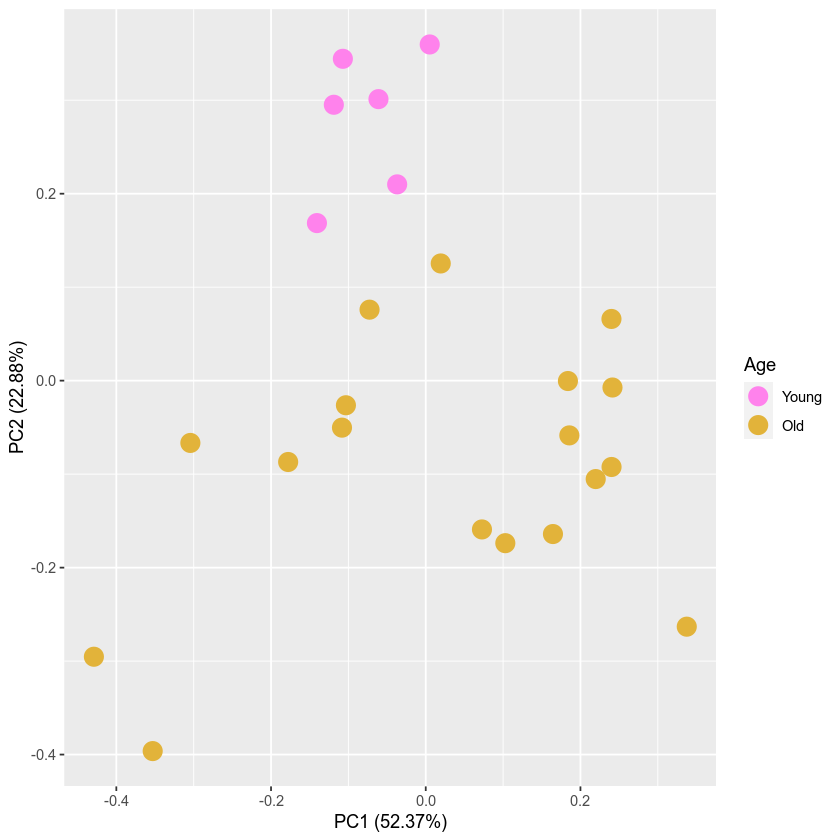

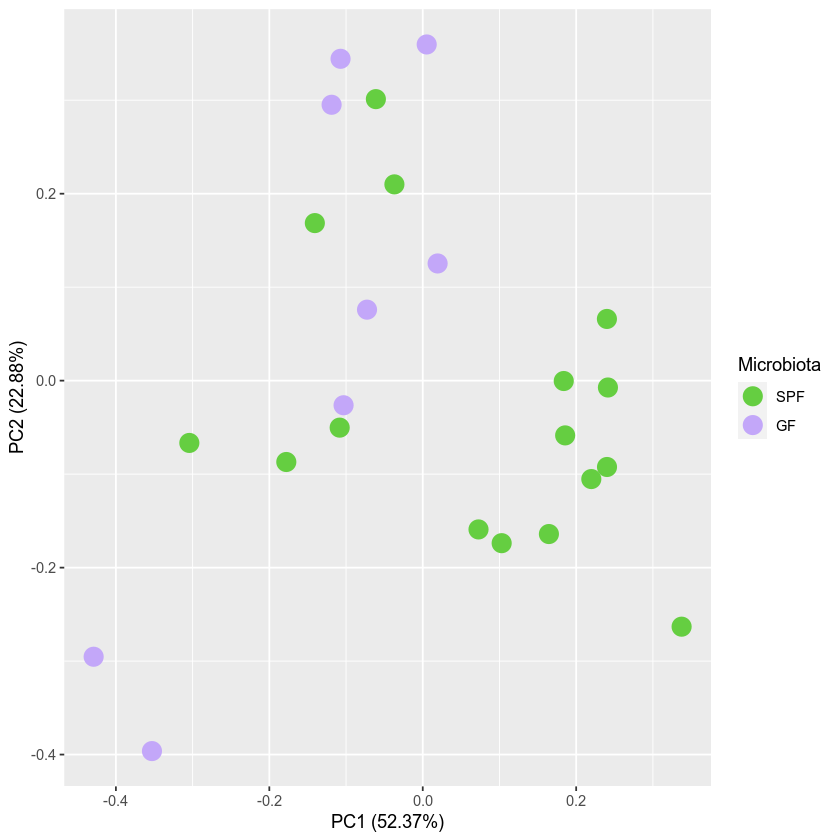

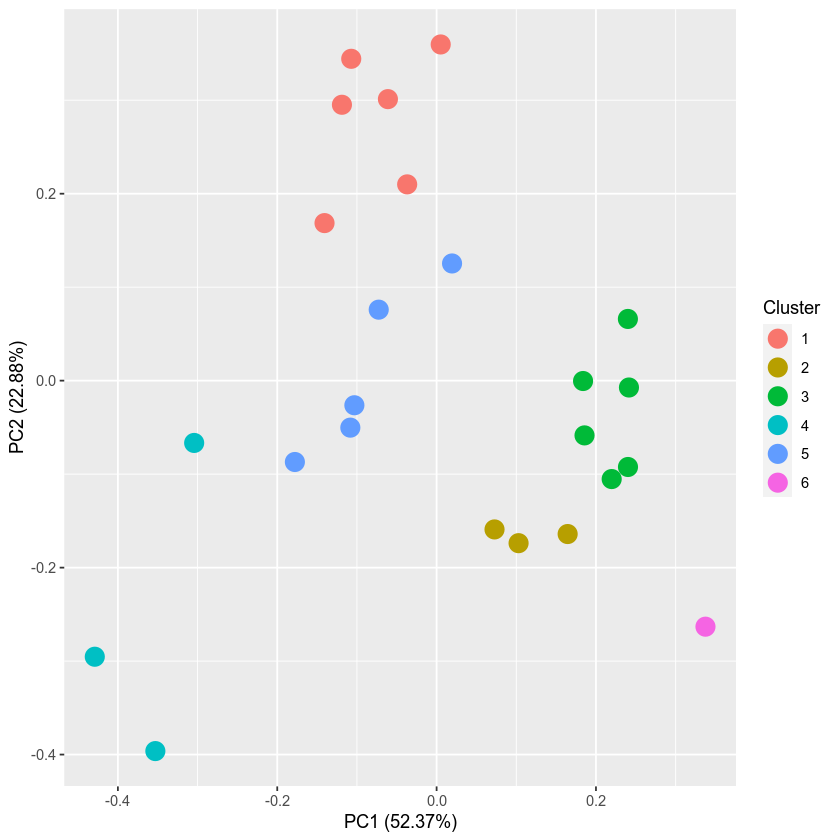

In [37]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', size = 5) + 
    scale_color_manual(values = annot_colors$Age)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Microbiota', size = 5) + 
    scale_color_manual(values = annot_colors$Microbiota)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', size = 5)

With form to differentiate the groups and color for the clusters

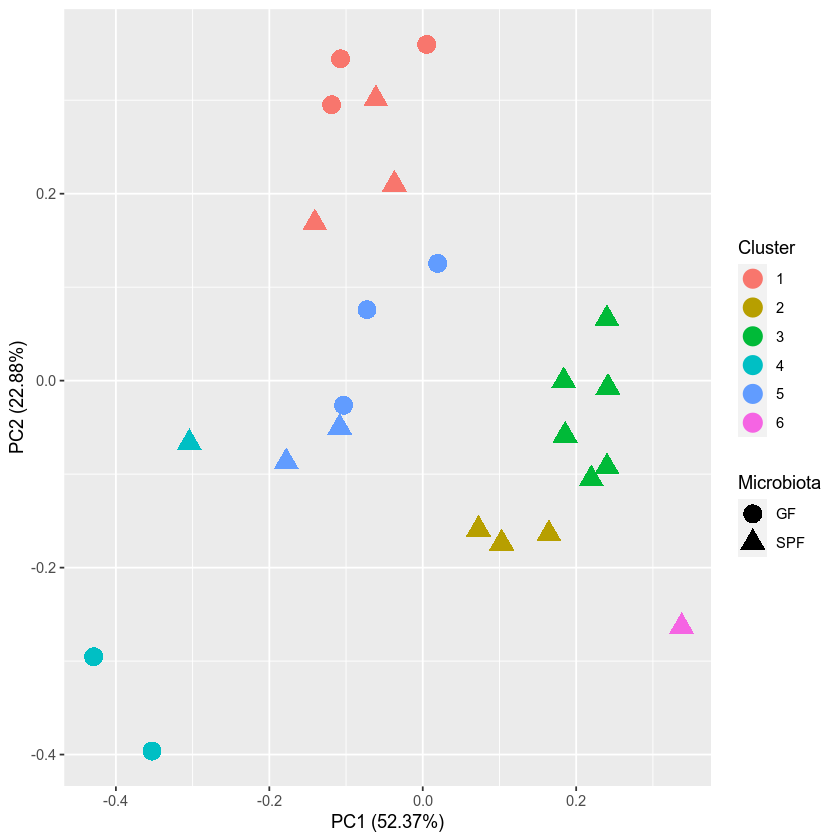

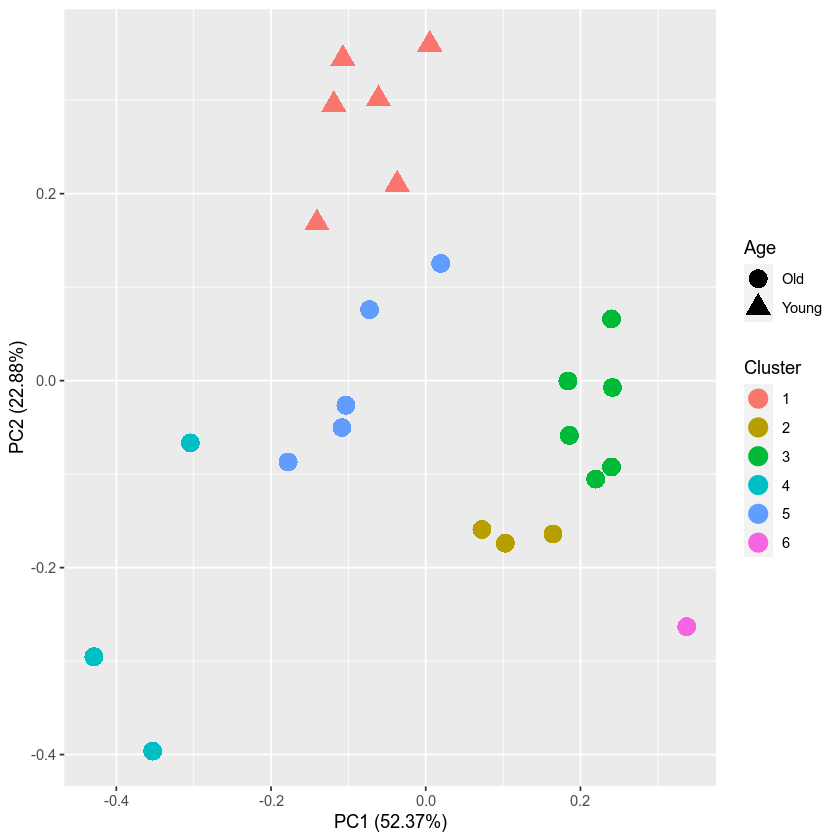

In [38]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', shape='Microbiota', size = 5)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', shape='Age', size = 5)

With color and form to differentiate the groups

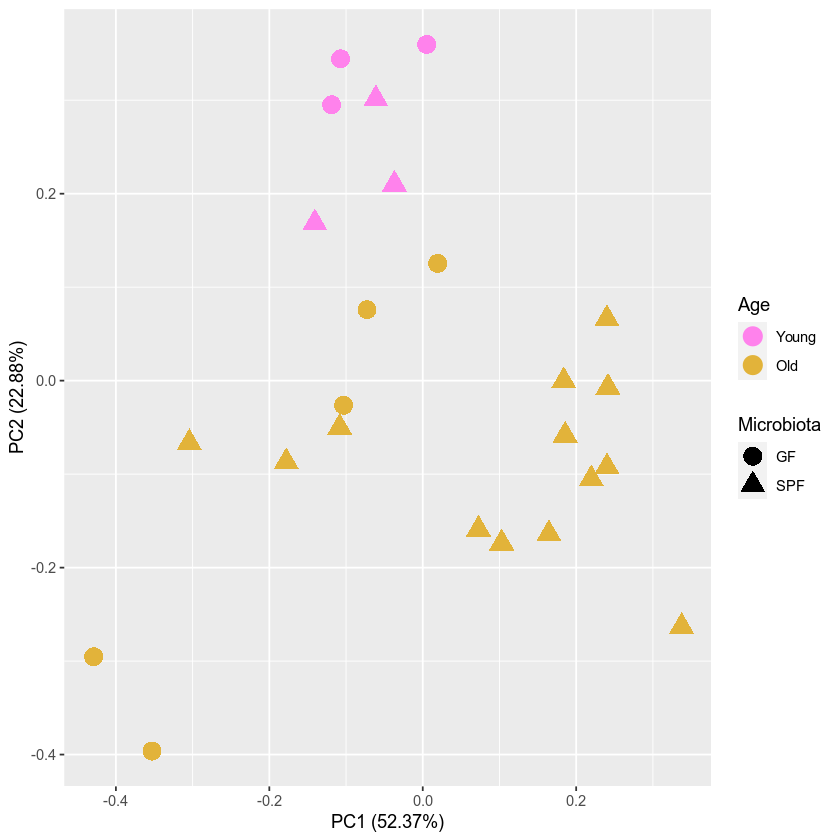

In [39]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', shape = 'Microbiota', size = 5) + 
    scale_color_manual(values = annot_colors$Age)

#### PC1 and PC3

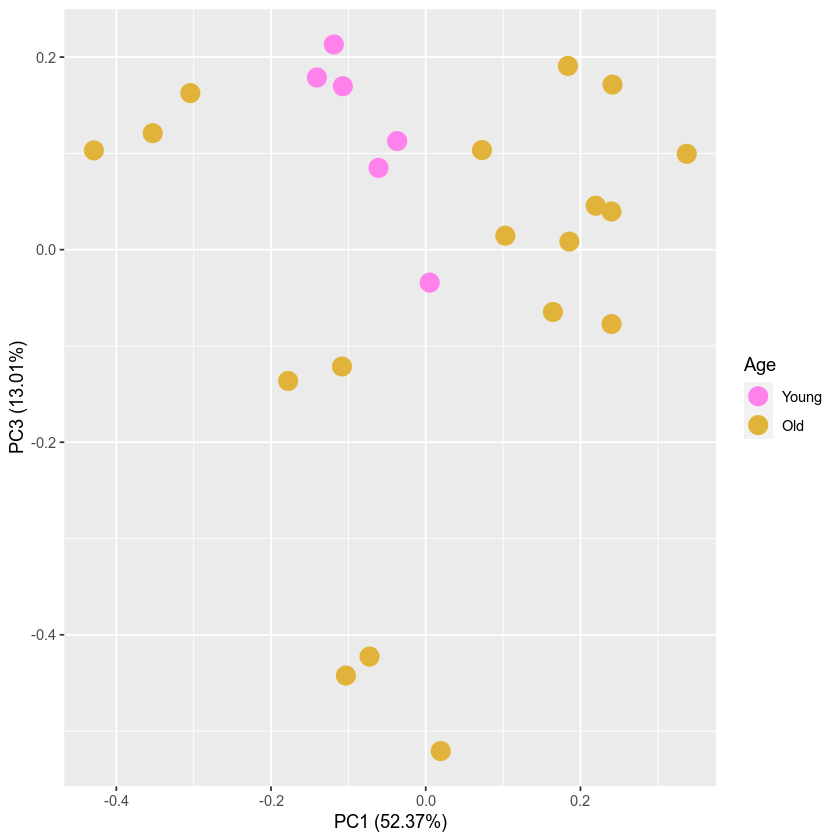

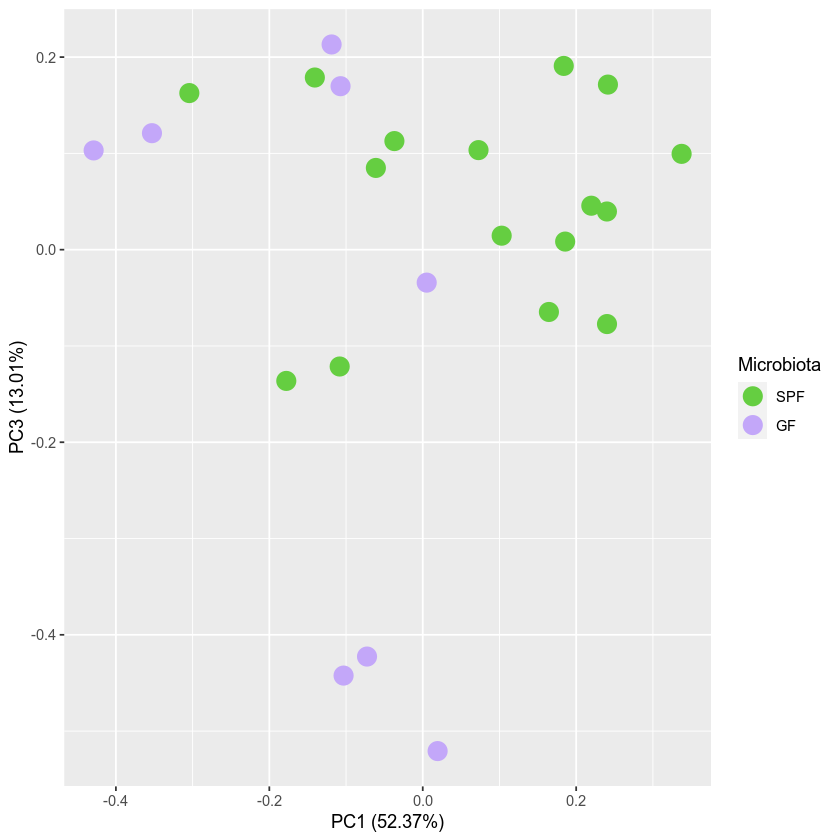

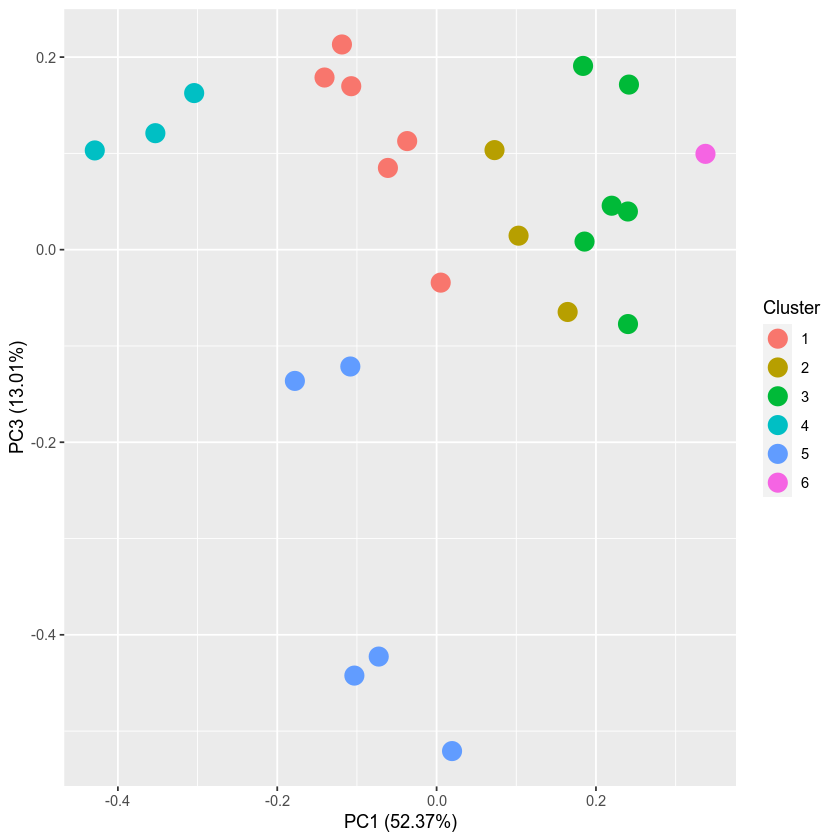

In [40]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', size = 5, x = 1, y = 3) + 
    scale_color_manual(values = annot_colors$Age)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Microbiota', size = 5, x = 1, y = 3) + 
    scale_color_manual(values = annot_colors$Microbiota)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', size = 5, x = 1, y = 3)

#### PC2 and PC3

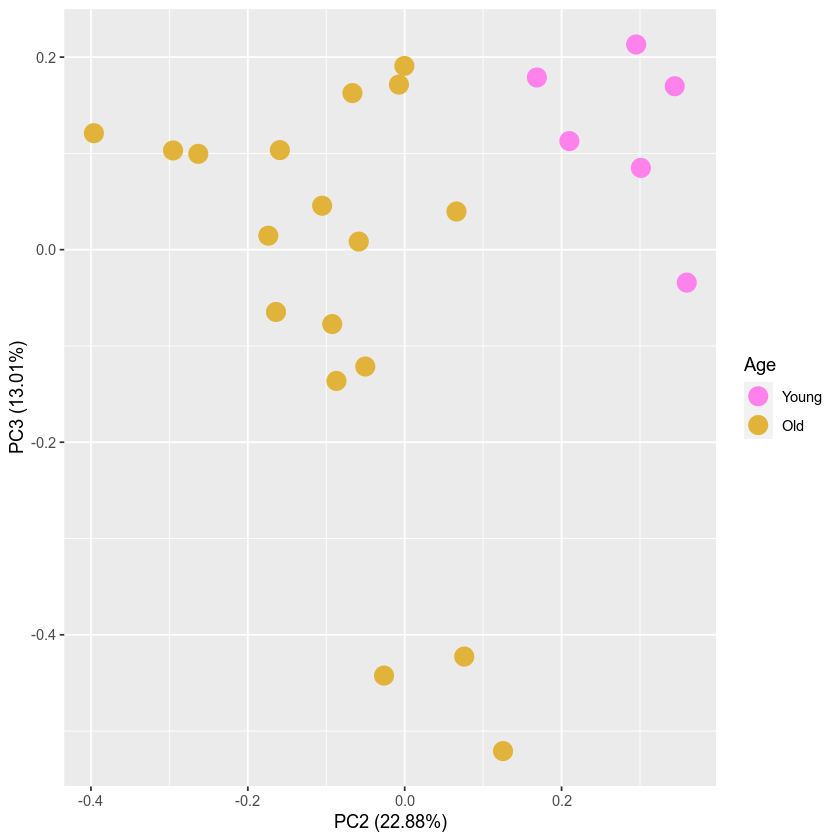

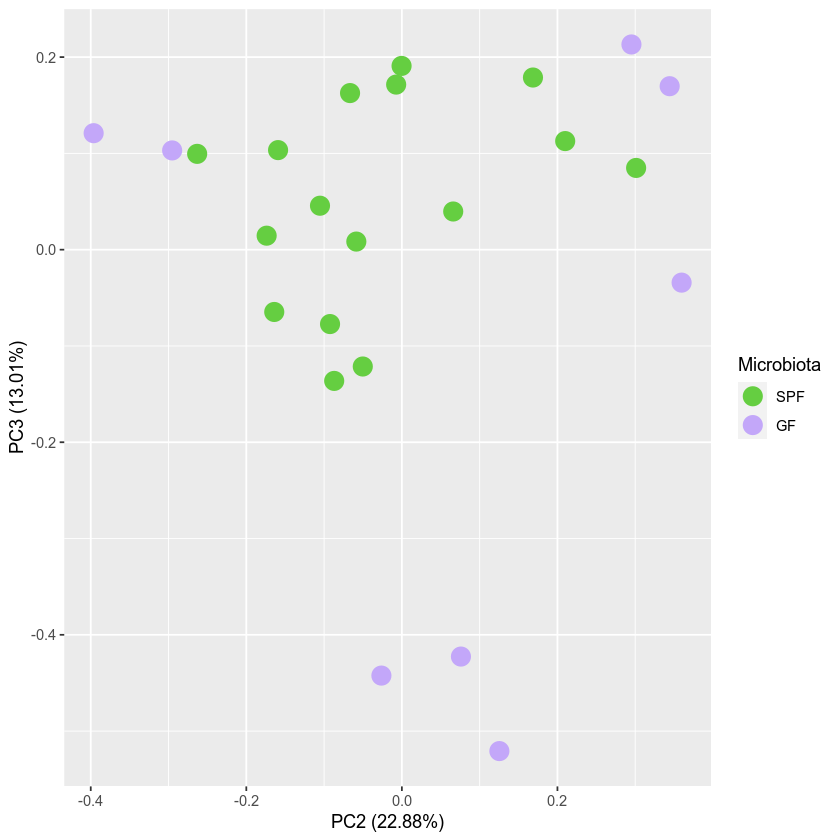

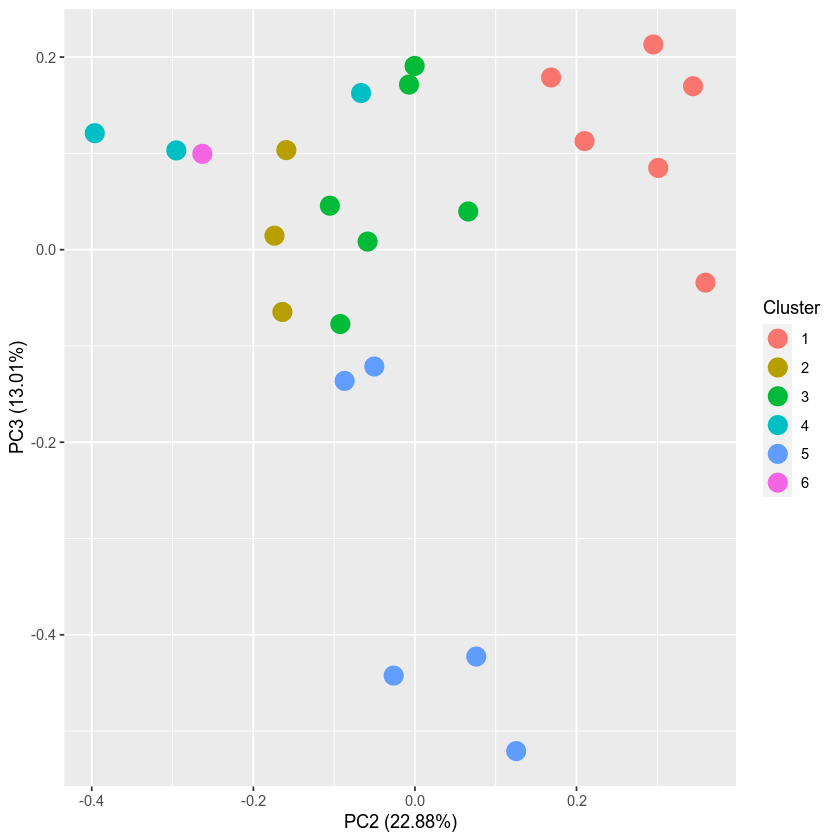

In [41]:
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Age', size = 5, x = 2, y = 3) + 
    scale_color_manual(values = annot_colors$Age)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Microbiota', size = 5, x = 2, y = 3) + 
    scale_color_manual(values = annot_colors$Microbiota)
autoplot(prcomp(pca_data), data = clust_metadata, colour = 'Cluster', size = 5, x = 2, y = 3)

### GF vs SPF

In [42]:
plot_GF_SPF_PCA = function(a) {
    pca_metadata = metadata %>%
        filter(Age == a)
    pca_data = t(norm_counts)[pca_metadata$sample,]
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Microbiota', size = 6) + 
        scale_color_manual(values = annot_colors$Microbiota)
    dp = paste(plot_dp, "/female_male_pca/", sep='')
    dir.create(dp, showWarnings = FALSE)
    ggsave(paste(dp, a ,".pdf", sep=''))
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Microbiota', size = 6) + 
        scale_color_manual(values = annot_colors$Microbiota)
}

Young

Saving 6.67 x 6.67 in image



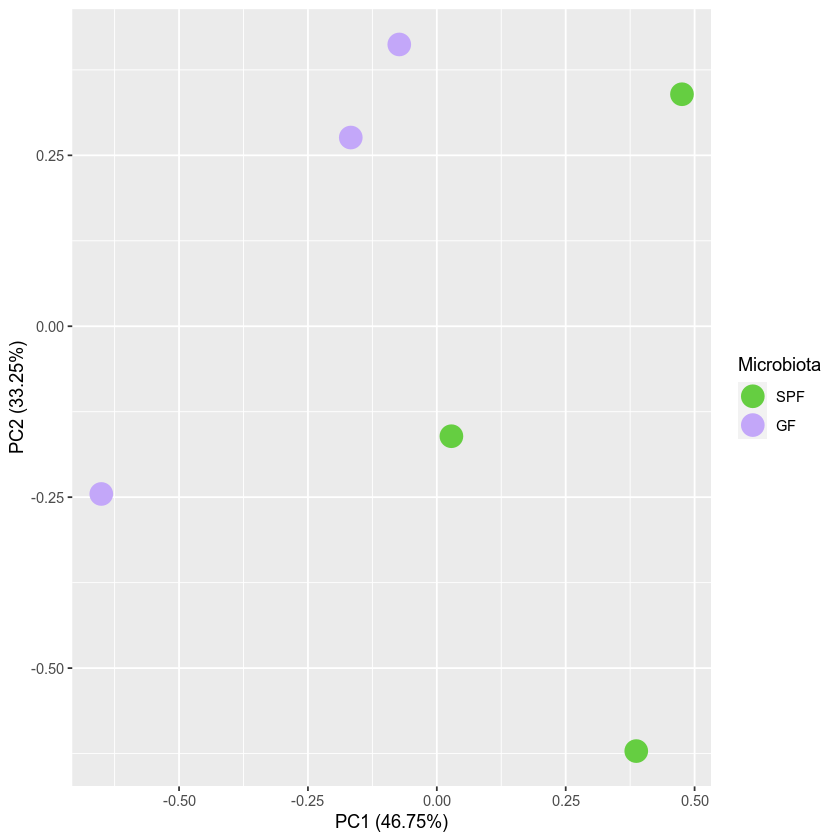

In [43]:
plot_GF_SPF_PCA('Young')

Old

Saving 6.67 x 6.67 in image



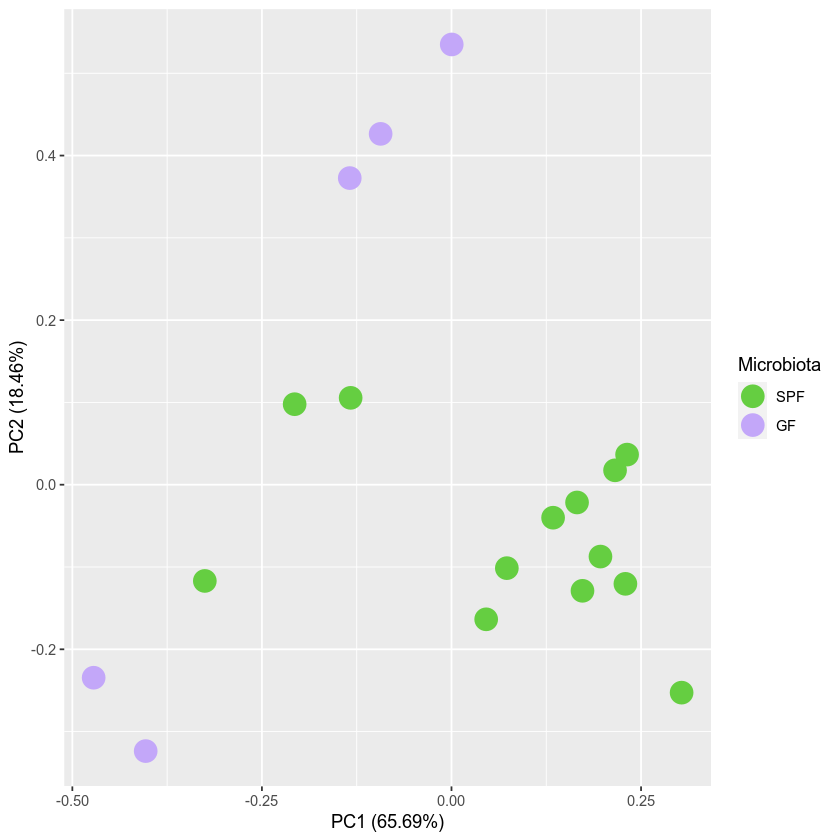

In [44]:
plot_GF_SPF_PCA('Old')

### Age

In [45]:
plot_age_PCA = function(m) {
    pca_metadata = metadata %>%
        filter(Microbiota == m)
    pca_data = t(norm_counts)[pca_metadata$sample,]
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Age', size = 6) + 
        scale_color_manual(values = annot_colors$Age)
    dp = paste(plot_dp, "/age_pca/", sep='')
    dir.create(dp, showWarnings = FALSE)
    ggsave(paste(dp, m ,".pdf", sep=''))
    autoplot(prcomp(pca_data), data = pca_metadata, colour = 'Age', size = 6) + 
        scale_color_manual(values = annot_colors$Age)
}

SPF

Saving 6.67 x 6.67 in image



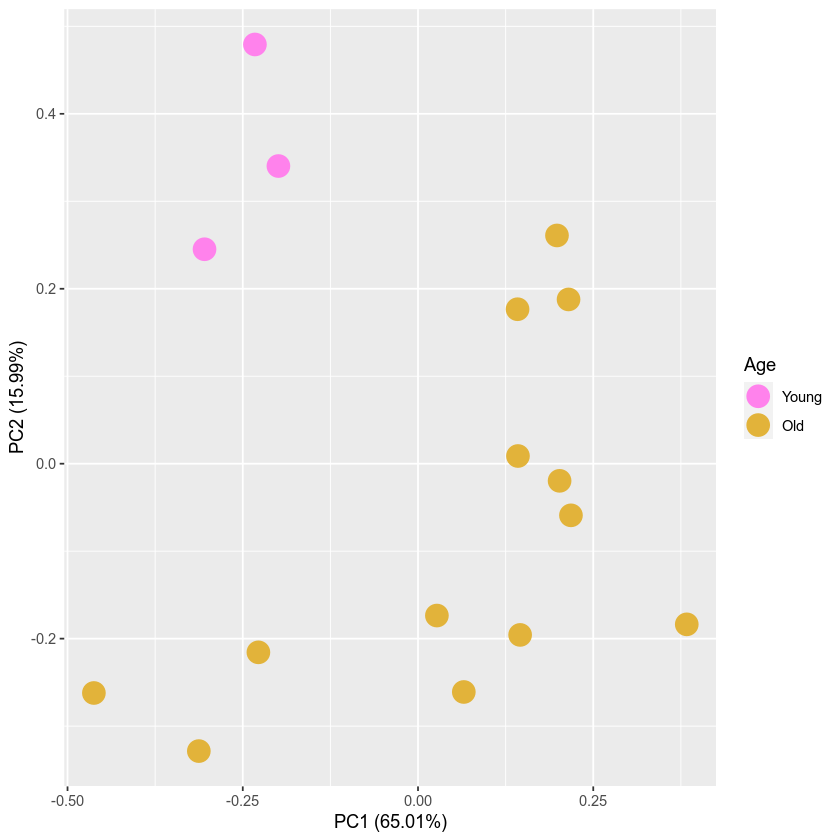

In [46]:
plot_age_PCA('SPF')

GF

Saving 6.67 x 6.67 in image



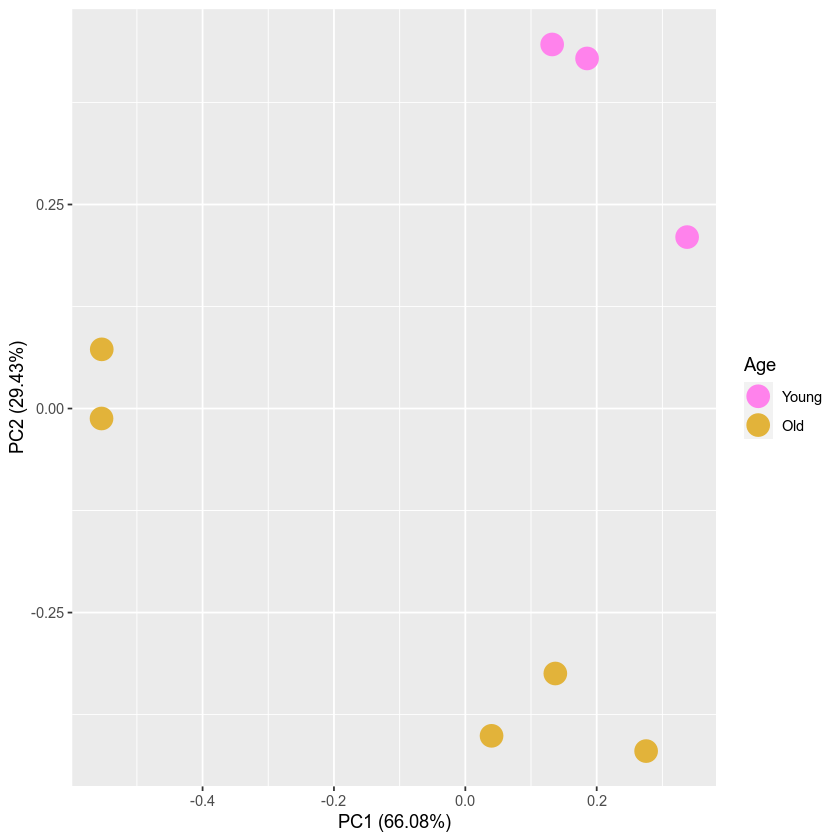

In [47]:
plot_age_PCA('GF')

# Z-scores (normalized counts) for all genes

## All genes

Column order: microbiota - age

png 
  2

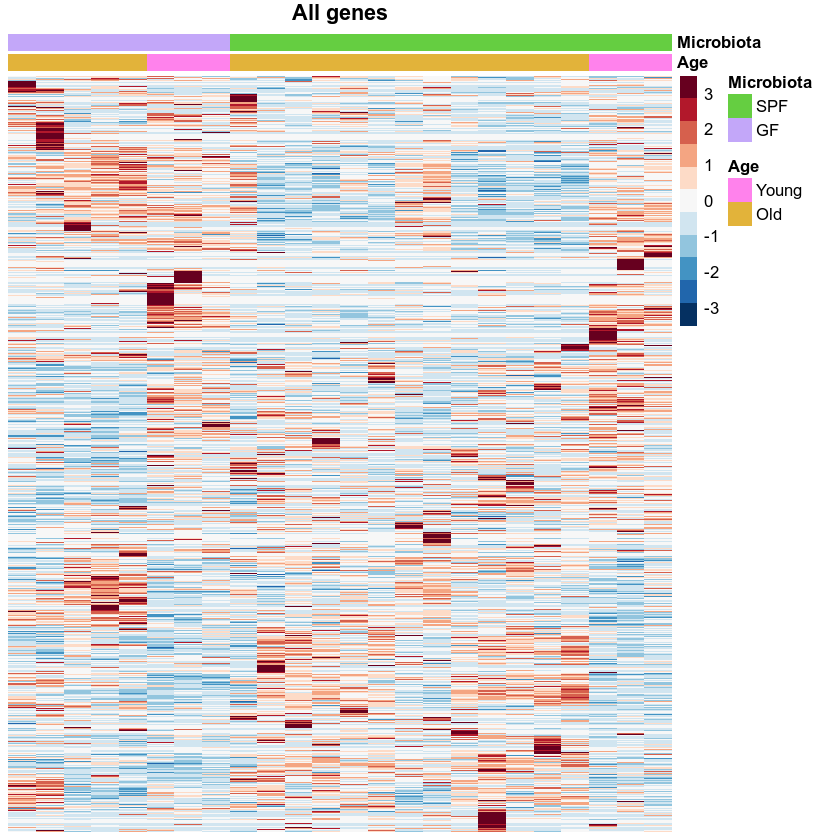

In [48]:
plot_z_score_heatmap(z_scores,
                     rownames(z_scores),
                     col_order$ma,
                     annot_col$ma,
                     "All genes",
                     col_order$ma,
                     fp=paste(plot_dp, "z_score_ma.pdf", sep=''))

## GF signature genes

In [49]:
genes = c(
    'Ero1lb', 'D16Ertd472e', 'Mcur1', 'Gpr137b-ps', 'Lonrf3', 'G530011O06Rik', 
    '1700112E06Rik', 'Ly86', 'Cd52', 'Sdc3', 'Dynlt1b', 'Tuba4a', 'Sult1a1', 
    'Notch4', 'Nnt', 'Plcd3', 'Rab4a', 'Wdfy1', 'Ctse', 'Gpr137b', 'Htra3')

Column order: microbiota - sex - age

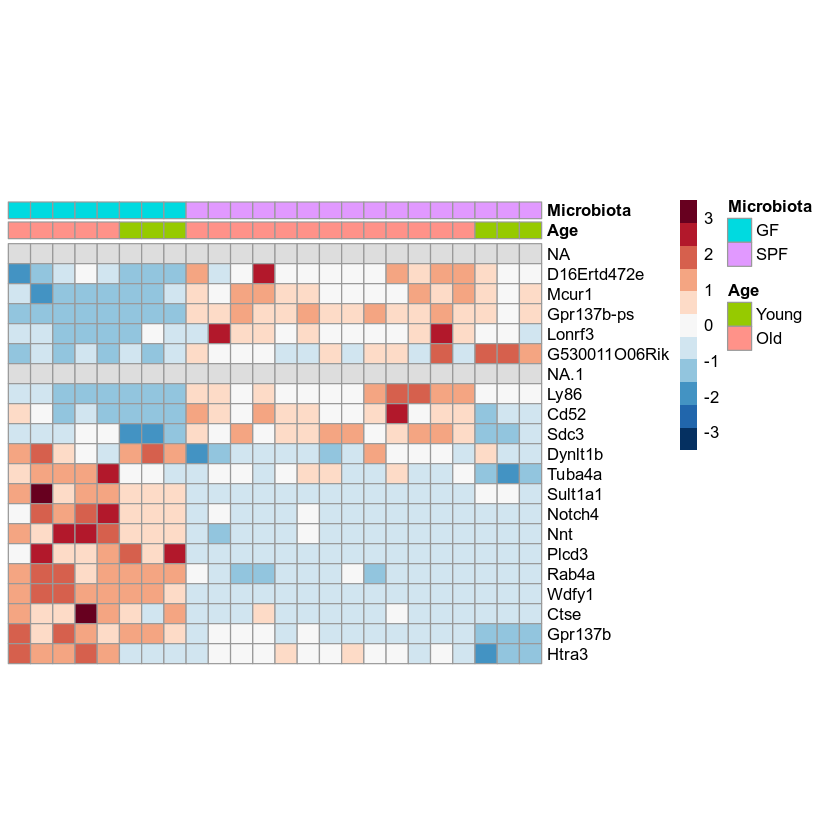

In [50]:
pheatmap(z_scores[genes,col_order$ma],
    cluster_rows=F,
    cluster_cols=F,
    show_rownames=T,
    show_colnames=F,
    annotation_col=annot_col$ma,
    annotation_row=NULL,
    annotation_colors = NULL,
    color=rev(brewer.pal(11, "RdBu")),
    breaks = seq(-3.5, 3.5, length=12),
    main ='', cellheight = 12)
pheatmap(z_scores[genes,col_order$ma],
    cluster_rows=F,
    cluster_cols=F,
    show_rownames=T,
    show_colnames=F,
    annotation_col=annot_col$ma,
    annotation_row=NULL,
    annotation_colors = NULL,
    color=rev(brewer.pal(11, "RdBu")),
    breaks = seq(-3.5, 3.5, length=12),
    main ='',
    cellheight = 12,
    filename=paste(plot_dp, "gf_signature_genes_z_scores.pdf", sep=""))

# Gene co-expression analysis

Weighted gene co-expression network analysis using WGCNA package

## Extract modules of co-expressed genes

Filtering data

In [51]:
filtering = 'variance' # none / count_number / variance / missing_samples
filtered_norm_counts = data.frame(original_norm_counts) %>%
    rownames_to_column('genes')
if(filtering == 'count_number'){
    # filtering to keep only genes that have a count >= 10 in more than 90% of the samples (number removed / kept displayed)
    filtered_norm_counts = filtered_norm_counts %>%
        mutate(rowsum = rowSums(select(., -genes) >= 10)) %>%
        filter(rowsum >= 0.9*dim(original_norm_counts)[2]) %>%
        select(-rowsum)
} else if (filtering == 'variance'){
    filtered_norm_counts = filtered_norm_counts %>% 
        rowwise() %>% 
        mutate(var = var(c_across(where(is.numeric)))) %>% 
        ungroup()
    quantile_var = quantile(filtered_norm_counts$var, c(.40))
    filtered_norm_counts = filtered_norm_counts %>%
        filter(var >= quantile_var) %>%
        select(-var)
}
filtered_norm_counts = filtered_norm_counts %>%
    filter(!genes %in% facs_genes) %>%
    filter(!genes %in% core_signature_genes$macrophage) %>%
    filter(!genes %in% core_signature_genes$monocyte) %>%
    filter(!genes %in% core_signature_genes$dc) %>%
    #filter(!genes %in% core_signature_genes$granulocyte) %>%
    filter(!genes %in% core_signature_genes$t) %>%
    filter(!genes %in% core_signature_genes$b) %>%
    filter(!genes %in% core_signature_genes$mast) %>%
    filter(!genes %in% core_signature_genes$nk) %>% 
    filter(!genes %in% c('Calm1')) %>% 
    select(-c(GF_8w_M_2_2, SPF_104w_M_3_2)) %>%
    column_to_rownames('genes')
if(filtering == 'missing_samples'){
    # identify genes and samples with excessive numbers of missing samples
    datExpr = vector(mode = "list", length = 1)
    datExpr[[1]] = list(data = as.data.frame(t(filtered_norm_counts)))
    names(datExpr[[1]]$data) = rownames(filtered_norm_counts)
    exprSize = checkSets(datExpr)
    exprSize
    gsg = goodSamplesGenesMS(datExpr, verbose = 3)
    if (!gsg$allOK)
    {
        # Print information about the removed genes:
        if (sum(!gsg$goodGenes) > 0)
            printFlush(paste(
                "Removing genes:",
                paste(names(datExpr[[1]]$data)[!gsg$goodGenes], collapse = ", ")))
        for (set in 1:exprSize$nSets)
        {
            if (sum(!gsg$goodSamples[[set]]))
                printFlush(
                    paste("In set", 
                          setLabels[set], 
                          "removing samples", 
                          paste(rownames(datExpr[[set]]$data)[!gsg$goodSamples[[set]]], collapse = ", ")))
            # Remove the offending genes and samples
            datExpr[[set]]$data = datExpr[[set]]$data[gsg$goodSamples[[set]], gsg$goodGenes]
        }
        # Update exprSize
        exprSize = checkSets(datExpr)
    }
    filtered_norm_counts = t(datExpr[[1]]$data)
}
dim(original_norm_counts)[1] - dim(filtered_norm_counts)[1]
dim(filtered_norm_counts)[1]
cml_genes = c('S100a3', 'S100a4', 'S100a5', 'S100a6', 'S100a8', 'S100a9')
kept_cml_genes = cml_genes %in% rownames(filtered_norm_counts)
names(kept_cml_genes) = cml_genes
kept_cml_genes

[1] 7265

[1] 10848

S100a3 S100a4 S100a5 S100a6 S100a8 S100a9 
 FALSE   TRUE  FALSE  FALSE   TRUE   TRUE

Filtering | Number of kept genes | Number of removed genes | Number of kept CML genes
--- | --- | --- | ---
None | 18,084 | 29 | 6/6
Count >= 10 in more than 90% of the samples | 10,234 | 7,879 | 0/6
Count variance >= 50% | 10,848 | 7,265 | 3/6
Excessive numbers of missing samples | 18,022 | 91 | 6/6

In [52]:
module_dp = paste(plot_dp, "modules/", sep="")
dir.create(module_dp, showWarnings = FALSE)

Analysis of scale free topology for multiple soft thresholding powers, with signed hybrid network type

pickSoftThreshold: will use block size 4124.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4124 of 10848
   ..working on genes 4125 through 8248 of 10848
   ..working on genes 8249 through 10848 of 10848
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0107  0.314          0.919 1370.00  1360.000 2150.0
2      2   0.2910 -1.120          0.900  529.00   501.000 1180.0
3      3   0.5660 -1.510          0.940  250.00   221.000  743.0
4      4   0.6960 -1.690          0.962  134.00   109.000  510.0
5      5   0.7540 -1.820          0.973   78.20    57.500  372.0
6      6   0.7940 -1.880          0.978   48.70    32.100  283.0
7      7   0.8160 -1.920          0.981   31.90    18.800  222.0
8      8   0.8350 -1.930          0.988   21.80    11.400  178.0
9      9   0.8400 -1.960          0.988   15.30     7.040  146.0
10    10   0.8530 -1.950          0.989   11.10     4.510  121.0
11    12   0.8650 -1.950      

Power SFT.R.sq   slope     truncated.R.sq mean.k.     median.k.   
1   1    0.01072349  0.313633 0.9186399      1371.351367 1360.8728140
2   2    0.29126188 -1.116186 0.9002862       529.187974  500.9274014
3   3    0.56554995 -1.506009 0.9397985       249.985575  221.2314171
4   4    0.69620549 -1.687137 0.9622074       133.882073  108.9178710
5   5    0.75423306 -1.816134 0.9725500        78.221078   57.4674819
6   6    0.79440838 -1.877645 0.9778493        48.743999   32.1201619
7   7    0.81618428 -1.918980 0.9814717        31.930137   18.7641071
8   8    0.83453148 -1.932040 0.9875168        21.768466   11.3641982
9   9    0.84041755 -1.961797 0.9879801        15.335088    7.0419612
10 10    0.85292511 -1.951325 0.9886352        11.103417    4.5074199
11 12    0.86530071 -1.946572 0.9829143         6.223284    1.9604825
12 14    0.89037484 -1.898816 0.9886840         3.744178    0.9107564
13 16    0.90691481 -1.859789 0.9967363         2.381499    0.4431339
14 18    0.91309610 -1.817433 0.9937923         1.584746    0.2287744
15 20    0.92260641 -1.754862 0.9891910         1.095062    0.1225249
   max.k.    
1  2146.33117
2  1175.40111
3   743.03165
4   510.45624
5   372.22579
6   283.19486
7   222.01525
8   178.15214
9   145.64218
10  120.89457
11   86.37579
12   64.06576
13   48.89156
14   38.16013
15   30.33357

Power mean.k.  
7   7    31.930137
8   8    21.768466
9   9    15.335088
10 10    11.103417
11 12     6.223284
12 14     3.744178
13 16     2.381499
14 18     1.584746
15 20     1.095062

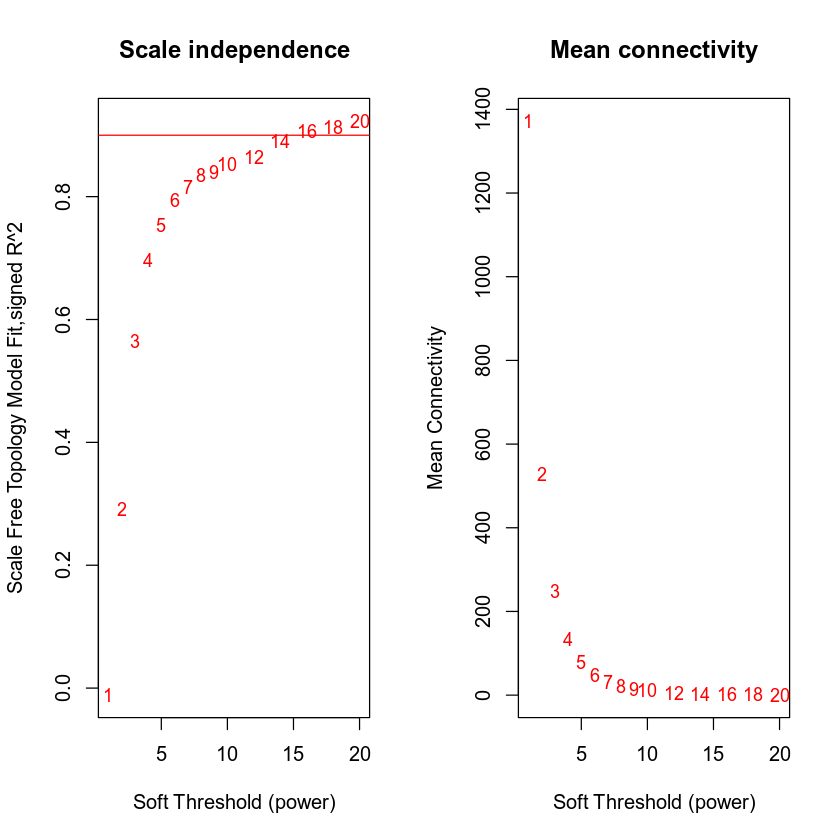

In [53]:
networkType = "signed hybrid"
powers = c(seq(1, 10, by = 1), seq(12, 20, by = 2))
# Choosing the soft-thresholding power
sft = pickSoftThreshold(t(filtered_norm_counts),
                        powerVector = powers,
                        dataIsExpr = T,
                        RsquaredCut = 0.85,
                        verbose = 5,
                        networkType = "signed hybrid")
par(mfrow = c(1,2))
cex1 = 0.9
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1],
     -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",
     type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1],
     -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,
     cex=cex1,
     col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1],
     sft$fitIndices[,5],
     xlab="Soft Threshold (power)",
     ylab="Mean Connectivity",
     type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
sft$fitIndices
sft$fitIndices[(-sign(sft$fitIndices[,3])*sft$fitIndices[,2])>0.8,c(1,5)]

Block-wise network construction and module detection
- Soft-thresholding power parameter: 5 (R2 > 0.80 and mean connectivity highest as possible (Ref: https://www.degruyter.com/view/j/sagmb.2005.4.issue-1/sagmb.2005.4.1.1128/sagmb.2005.4.1.1128.pdf))
- Minimum module size: 65
- Height for module merging: 0.35 (below)
- Biweight Midcorrelation

In [54]:
soft_thresholding_power = 7
min_module_size = 100
mergeCutHeight = 0.35
# Block-wise network construction and module detection
bwnet = blockwiseModules(t(filtered_norm_counts),
                 checkMissingData = TRUE,
                 maxBlockSize = 11000,
                 power = soft_thresholding_power,
                 networkType = networkType,
                 TOMType = "signed",
                 numericLabels = TRUE,
                 saveTOMs = TRUE,
                 saveTOMFileBase = "norm_genes_TOM",
                 mergeCutHeight = mergeCutHeight, 
                 verbose=3,
                 corType="bicor",
                 maxPOutliers=0,
                 minModuleSize = min_module_size,
                 reassignThreshold = 0,
                 deepSplit = 2)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 8 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file norm_genes_TOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..


Warning message in bicor(structure(c(282.691360976003, 308.960448688114, 528.149881625937, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


     ..removing 44 genes from module 1 because their KME is too low.
     ..removing 53 genes from module 2 because their KME is too low.
     ..removing 28 genes from module 3 because their KME is too low.
     ..removing 26 genes from module 4 because their KME is too low.
     ..removing 17 genes from module 5 because their KME is too low.
     ..removing 14 genes from module 6 because their KME is too low.
     ..removing 19 genes from module 7 because their KME is too low.
     ..removing 4 genes from module 8 because their KME is too low.
     ..removing 6 genes from module 9 because their KME is too low.
     ..removing 18 genes from module 10 because their KME is too low.
     ..removing 2 genes from module 11 because their KME is too low.
     ..removing 2 genes from module 12 because their KME is too low.
     ..removing 3 genes from module 13 because their KME is too low.
     ..removing 1 genes from module 15 because their KME is too low.
     ..removing 4 genes from module

Warning message in bicor(structure(c(43.076778815391, 30.7041439690052, 43.585184406024, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


     ..removing 5 genes from module 21 because their KME is too low.


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.35
       Calculating new MEs...


Size of the modules (ME0: genes not assigned to a module) and number of genes in modules

In [55]:
# Modules
mod_sizes = table(bwnet$colors)
names(mod_sizes) = paste("ME", names(mod_sizes), sep="")
mod_sizes
module_nb = dim(table(bwnet$colors))-1
# Get genes that are in one module
mod_genes = rownames(filtered_norm_counts)[bwnet$colors>0]

 ME0  ME1  ME2  ME3  ME4  ME5  ME6  ME7  ME8  ME9 ME10 
2027 2062 1350 1173  941  894  774  646  530  239  212 

Dendrogram and the module colors underneath the block

png 
  2

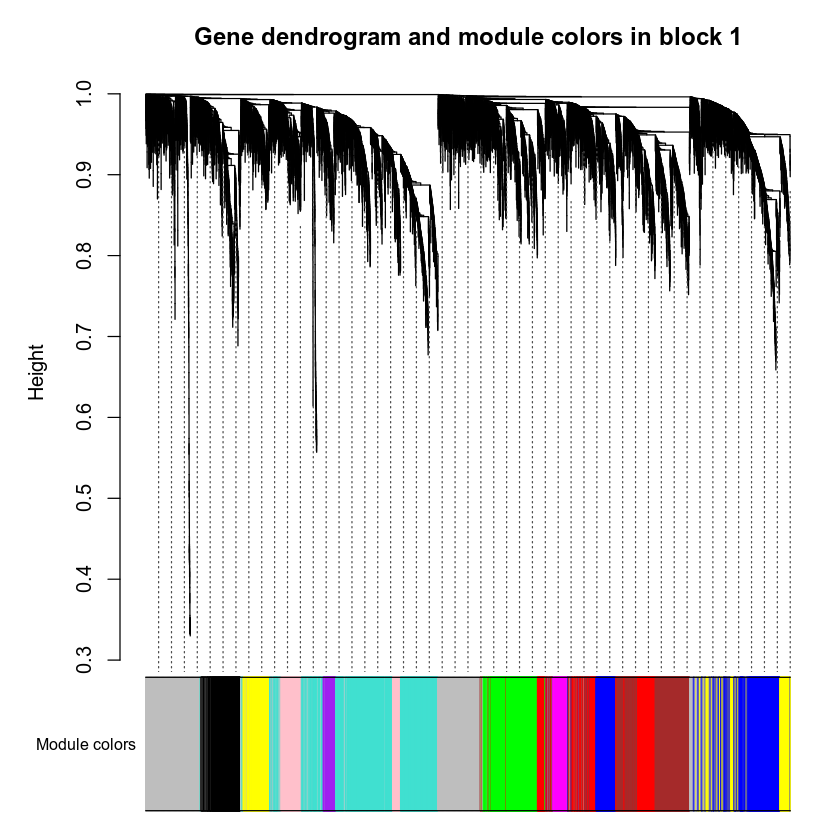

In [56]:
bwModuleColors = labels2colors(bwnet$colors)
plotDendroAndColors(bwnet$dendrograms[[1]],
                    bwModuleColors[bwnet$blockGenes[[1]]],
                    "Module colors",
                    main = "Gene dendrogram and module colors in block 1",
                    dendroLabels = FALSE,
                    hang = 0.03,
                    addGuide = TRUE,
                    guideHang = 0.05)
pdf(paste(module_dp, "gene_dendogram_module_colors.pdf", sep=''))
plotDendroAndColors(bwnet$dendrograms[[1]],
                    bwModuleColors[bwnet$blockGenes[[1]]],
                    "Module colors",
                    main = "Gene dendrogram and module colors in block 1",
                    dendroLabels = FALSE,
                    hang = 0.03,
                    addGuide = TRUE,
                    guideHang = 0.05)
dev.off()

Associate module color to genes

In [57]:
gene_colors = bwnet$colors
names(gene_colors) = rownames(filtered_norm_counts)
head(gene_colors)

Erg28 0610009B22Rik         Dele1         Sanbr 0610010K14Rik 
            1             1             2             1             9 
      Mettl26 
            7

Recalculate MEs with color labels

In [58]:
MEs = moduleEigengenes(t(filtered_norm_counts), gene_colors)$eigengenes

Extract the palette for next plots

In [59]:
pal2 = labels2colors(sort(unique(bwnet$colors)))
names(pal2) = names(mod_sizes)
pal2
save(pal2, file = paste(dp, "dge_net_pal2.RData", sep=''))

ME0         ME1         ME2         ME3         ME4         ME5 
     "grey" "turquoise"      "blue"     "brown"    "yellow"     "green" 
        ME6         ME7         ME8         ME9        ME10 
      "red"     "black"      "pink"   "magenta"    "purple"

## Relationship between modules and samples

Module-trait correlation analysis between the module eigengene (ME) and the different trait (combination of Microbiota, age and sex)
- correlation of Pearson between each pair of variables
- Student asymptotic p-values for the correlations

In [60]:
plot_module_groups = function(trait, vertsep){
    trait = trait %>% select(-c(sample))
    # Calculate correlation
    moduleTraitCor = cor(MEs, trait, use = "p")
    moduleTraitPvalue = corPvalueStudent(moduleTraitCor, dim(filtered_norm_counts)[2])
    # Will display correlations and their p-values
    textMatrix = paste(signif(moduleTraitCor, 2), "\n(",signif(moduleTraitPvalue, 1), ")", sep = "")
    dim(textMatrix) = dim(moduleTraitCor)
    # Plot correlation
    par(mar = c(6, 8.5, 3, 3))
    labeledHeatmap(Matrix = moduleTraitCor,
                    xLabels = colnames(trait),
                    ySymbols = paste(names(mod_sizes), " \n(", mod_sizes, " genes)", sep = ""),
                    yLabels = paste('ME', pal2, sep=''),
                    colorLabels = FALSE,
                    yColorLabels = TRUE,
                    colors = rev(brewer.pal(11, "RdBu")),
                    textMatrix = textMatrix,
                    setStdMargins = FALSE,
                    cex.text = 0.5,
                    cex.lab.y = .75,
                    zlim = c(-1,1),
                    verticalSeparator.x = vertsep)
}

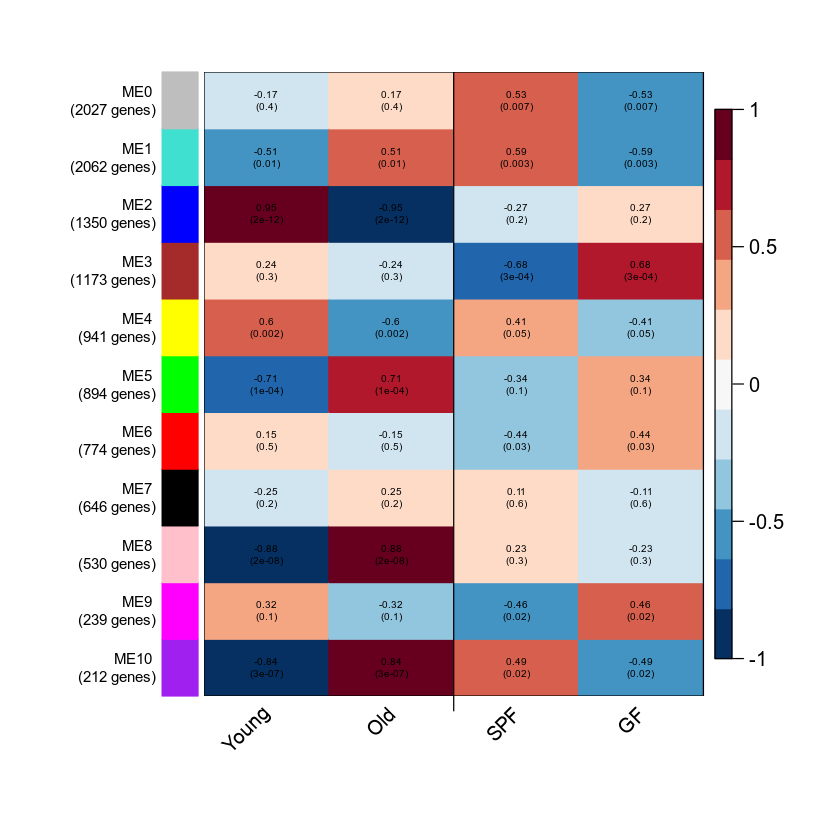

In [61]:
plot_module_groups(trait[['Groups']], 2)

png 
  2

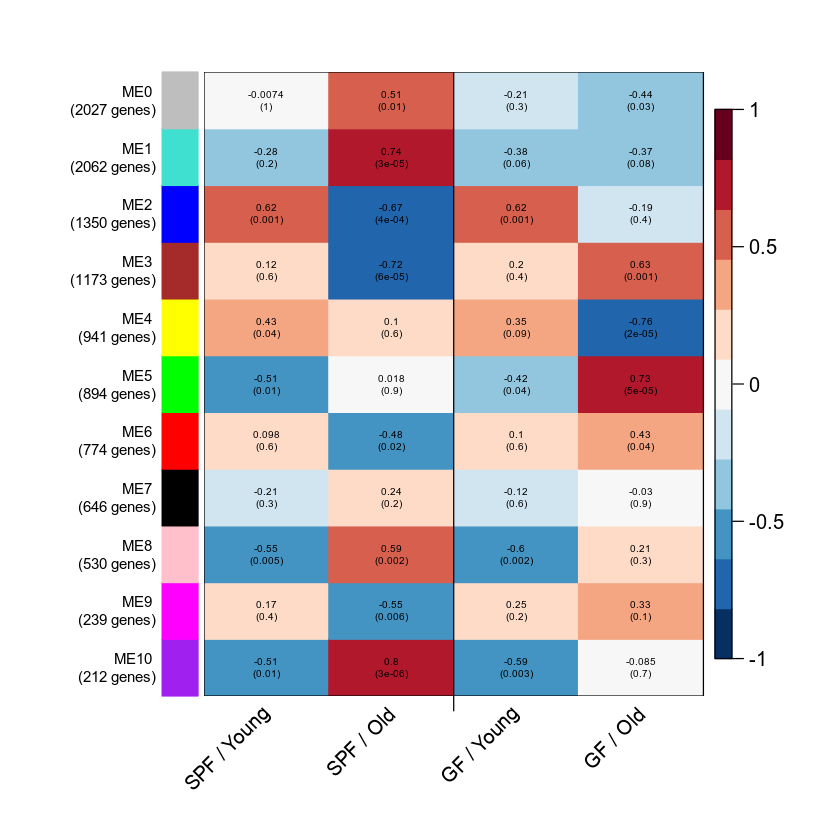

In [62]:
plot_module_groups(trait[['Microbiota / Age']], 2)
pdf(paste(module_dp, "module_group_microbiota_age.pdf", sep=''))
plot_module_groups(trait[['Microbiota / Age']], 2)
dev.off()

png 
  2

Young / SPF  Young / GF   Old / SPF    Old / GF 
          3           3          13           5

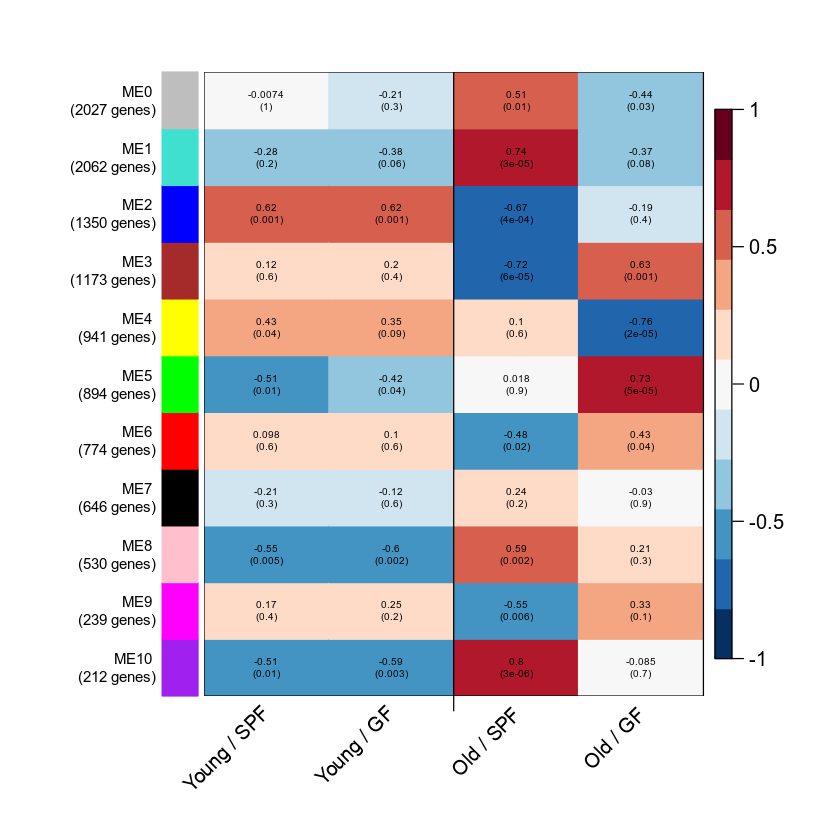

In [63]:
plot_module_groups(trait[['Age / Microbiota']], 2)
pdf(paste(module_dp, "module_group_age_microbiota.pdf", sep=''))
plot_module_groups(trait[['Age / Microbiota']], 2)
dev.off()
apply(trait[['Age / Microbiota']] %>% select(-c(sample)),2, sum)

## Genes in modules

Associate genes to modules

In [64]:
genes_in_modules_bool = sapply(0:module_nb, function(x) return(gene_colors == x))
colnames(genes_in_modules_bool) = names(mod_sizes)

In [65]:
head(gene_colors)

Erg28 0610009B22Rik         Dele1         Sanbr 0610010K14Rik 
            1             1             2             1             9 
      Mettl26 
            7

In [66]:
genes_in_modules = lapply(names(mod_sizes), function(x) return(rownames(genes_in_modules_bool[genes_in_modules_bool[,x],])))
names(genes_in_modules) = names(mod_sizes)
capture.output(genes_in_modules, file = paste(module_dp, "genes_in_modules", sep=''))
save(genes_in_modules, file=paste(dp, "genes_in_modules.RData", sep=''))

In [67]:
gene_modules = data.frame(genes = names(gene_colors), module=gene_colors)
write.table(gene_modules, file=paste(module_dp, "genes_in_modules.tsv", sep=''), sep='\t', quote=FALSE, row.names = FALSE)

In [68]:
data = z_scores
genes = rownames(data)
# get genes ordered by modules
genes_in_mod = c()
for(x in names(genes_in_modules)){
    g_in_mod_id = intersect(genes_in_modules[[x]], genes)
    new_c = rep(x, length(g_in_mod_id))
    names(new_c) = g_in_mod_id
    genes_in_mod = c(genes_in_mod, new_c)
}
# order the z-score matrix by genes in genes_in_mod
data = cbind(genes_in_mod, data[names(genes_in_mod), col_order$ma])
head(data)
write.table(data, file=paste(plot_dp, "gene_module_z_scores.tsv", sep=''), sep='\t', quote=FALSE, row.names = FALSE)

genes_in_mod GF_104w_M_1_2 GF_104w_M_2_2 GF_104w_M_3_2
1110004F10Rik ME0           0.4770760    0.7579686     -1.3060695   
Bbln          ME0           1.1581348    3.0335888     -0.3618015   
Eola1         ME0           0.1443893    1.7317630     -0.9199144   
1110051M20Rik ME0           0.5648627    1.4029636      1.2756566   
1190007I07Rik ME0          -0.6339808    1.5867601     -0.1237374   
Ncbp3         ME0          -0.4835166    0.4177561     -0.2786179   
              GF_104w_M_4_2 GF_104w_M_5_2 GF_8w_M_1_2 GF_8w_M_3_2 GF_8w_M_4_2
1110004F10Rik -1.28384233    1.705365111  -0.2684693  -0.25157307 -0.4983255 
Bbln           1.27594916   -0.911361962   0.1602464   0.56324643  0.3855204 
Eola1         -0.28064588   -0.305889405   0.1525833   0.76485073 -0.2726480 
1110051M20Rik  0.50480289    1.857488266   0.4841856  -0.45607943 -0.1305745 
1190007I07Rik -1.25557856   -1.523118488   1.6960192   1.33828462  0.5883336 
Ncbp3          0.02135871    0.001740423   0.3386099  -0.04802487 -0.9773501 
              SPF_104w_M_1_2 ⋯ SPF_104w_M_2_2 SPF_104w_M_4_2 SPF_104w_M_5_2
1110004F10Rik -1.6899347     ⋯ -1.1852552     -0.9251553      1.778824379  
Bbln          -0.1018911     ⋯  0.3189372      0.2599052      0.121492510  
Eola1         -1.8601567     ⋯ -0.5309142     -0.8760675      0.003205047  
1110051M20Rik  0.7256668     ⋯ -0.2786324     -0.2292897     -0.271964427  
1190007I07Rik -1.2734170     ⋯ -0.4047176     -1.0946772      1.689037010  
Ncbp3         -2.2658269     ⋯  0.4646027      0.2690508     -0.409803221  
              SPF_104w_M_6_2 SPF_104w_M_7_2 SPF_104w_M_8_2 SPF_104w_M_9_2
1110004F10Rik -0.7175411      1.3770020      0.8947470      1.1282986    
Bbln          -0.8920945     -0.4567831     -1.2592294     -0.7388352    
Eola1         -1.2327001      0.1441348      1.8390431      0.1719006    
1110051M20Rik  0.6143059     -1.0397475      0.6722117      1.6779995    
1190007I07Rik  0.1567062      0.7044481      1.5280059     -0.5431656    
Ncbp3          1.2238265     -2.1165806     -1.2227167      0.4280812    
              SPF_8w_M_2_2 SPF_8w_M_3_2 SPF_8w_M_4_2
1110004F10Rik  0.1109596   -0.05430563  -0.5692821  
Bbln          -0.4741656   -0.05052199  -1.4989772  
Eola1         -0.6655199   -0.02852543   0.7507136  
1110051M20Rik -0.4046686   -0.87280493  -0.7830971  
1190007I07Rik -0.8537460    0.04159036  -0.7201442  
Ncbp3          0.3200610    0.98581388   1.1978298

### Heatmaps with Z-scores

#### Microbiota  / Age

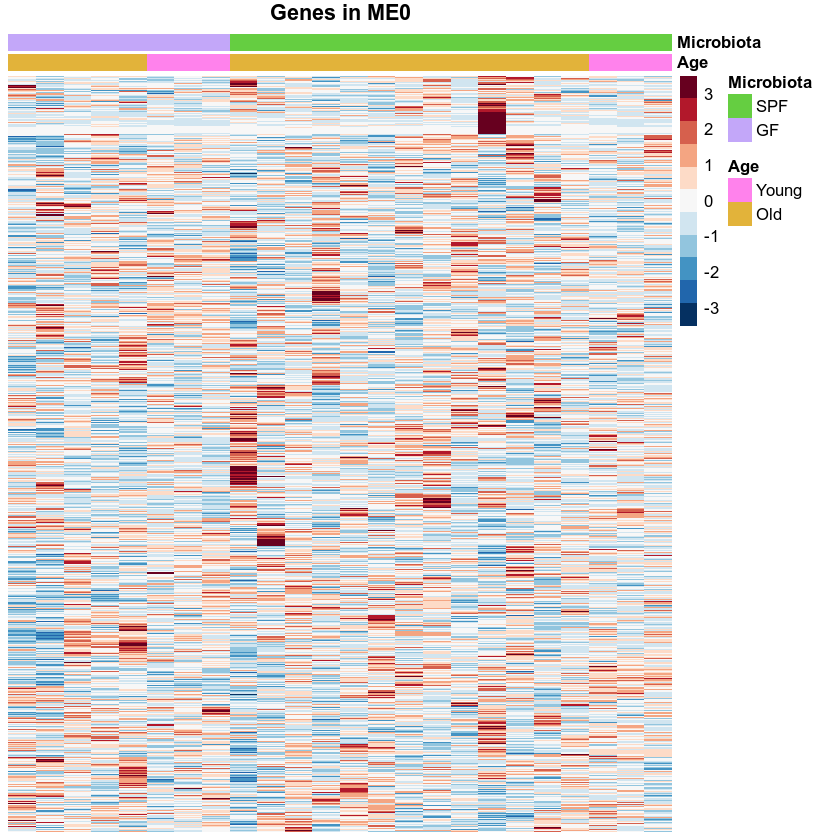

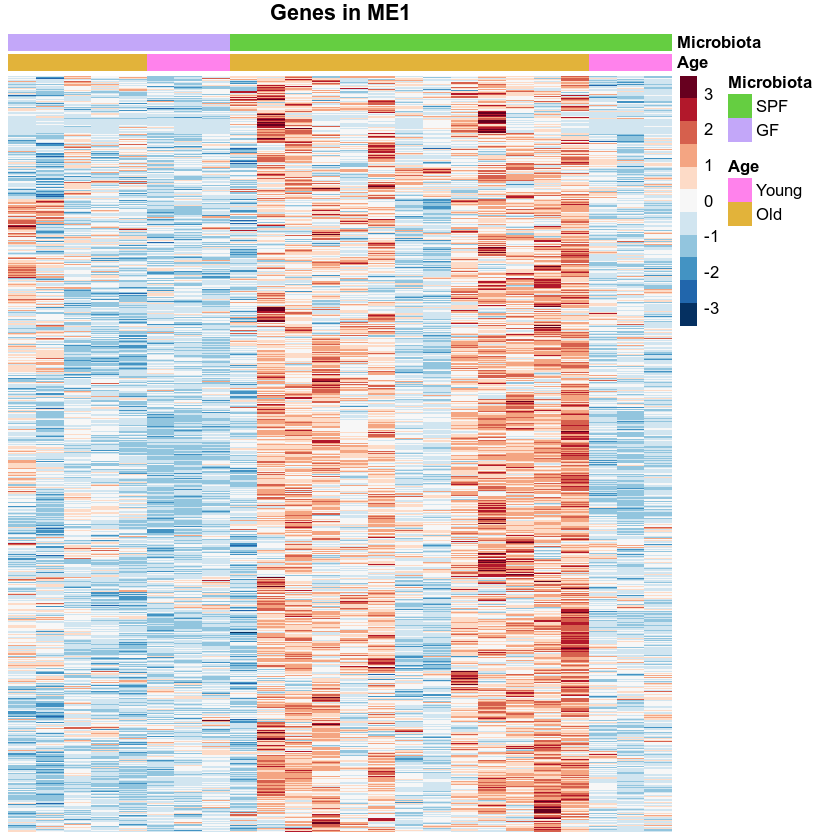

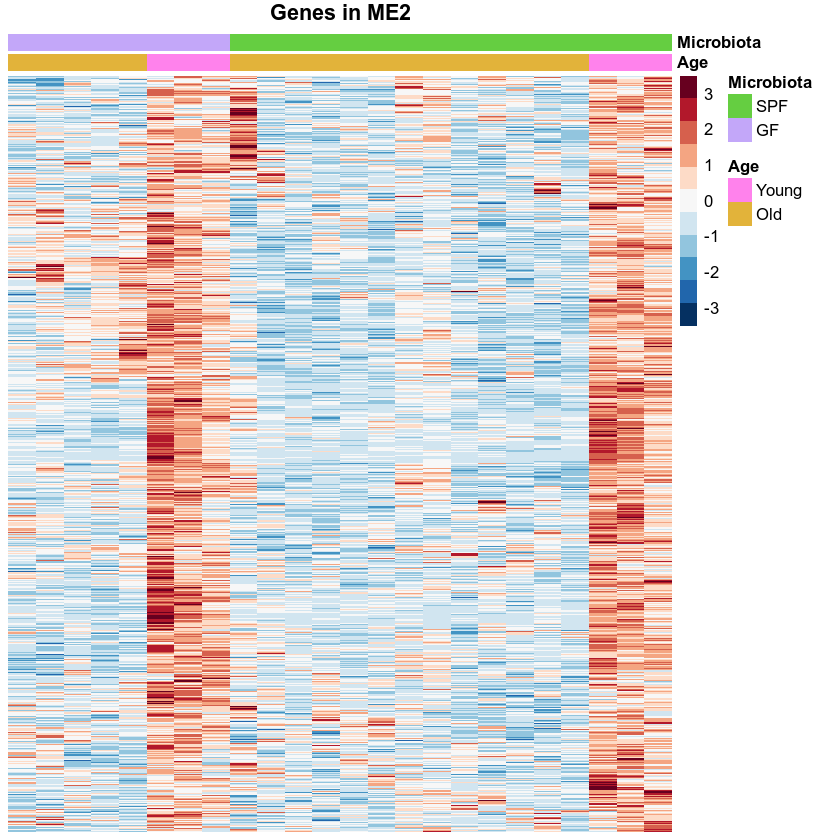

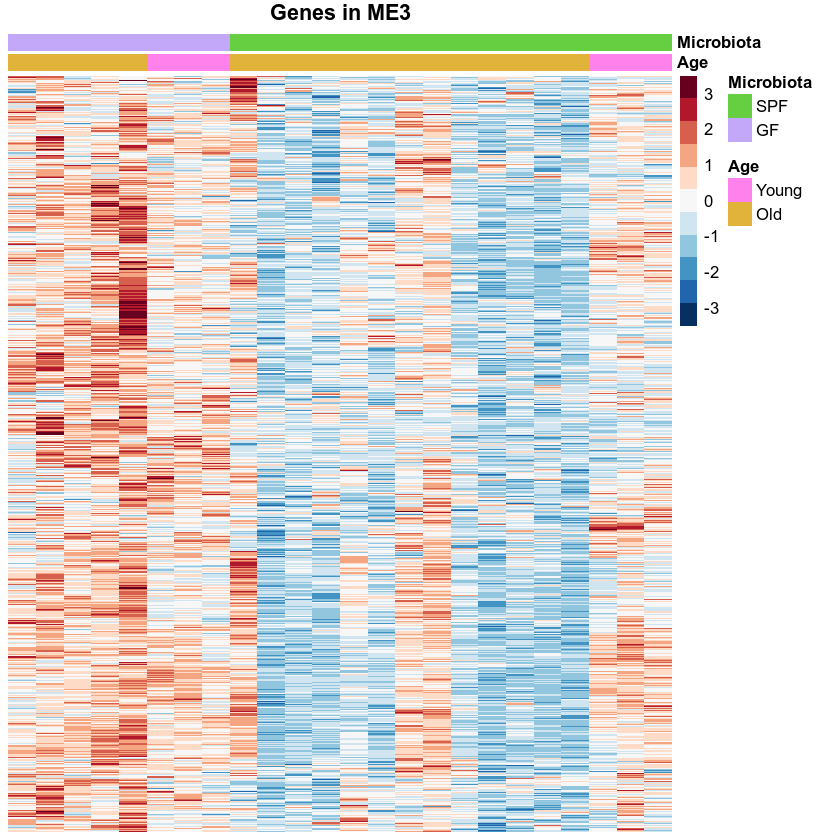

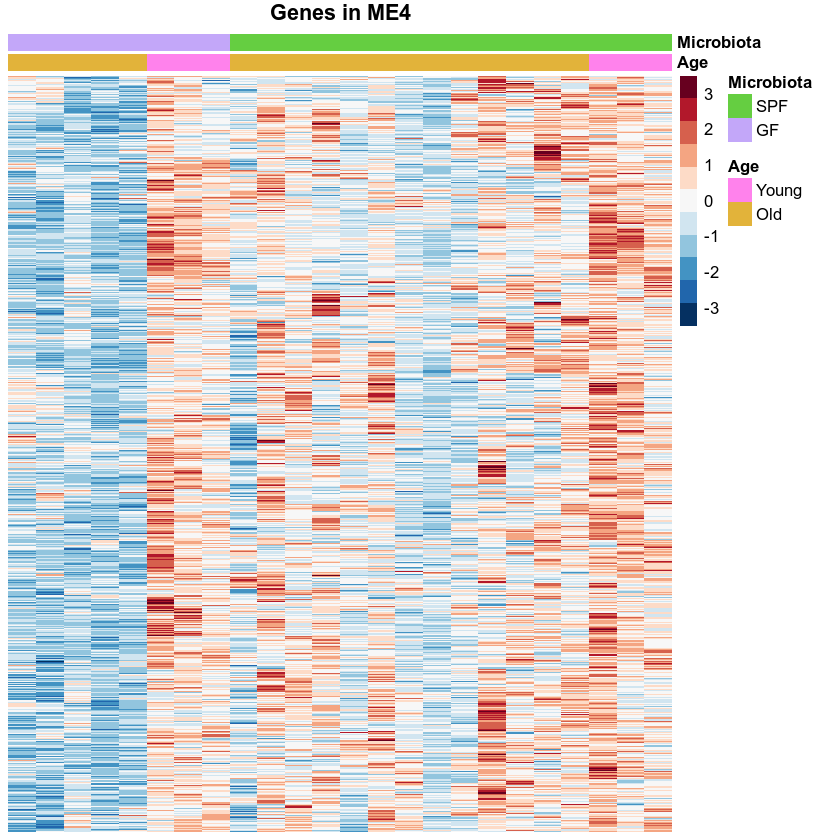

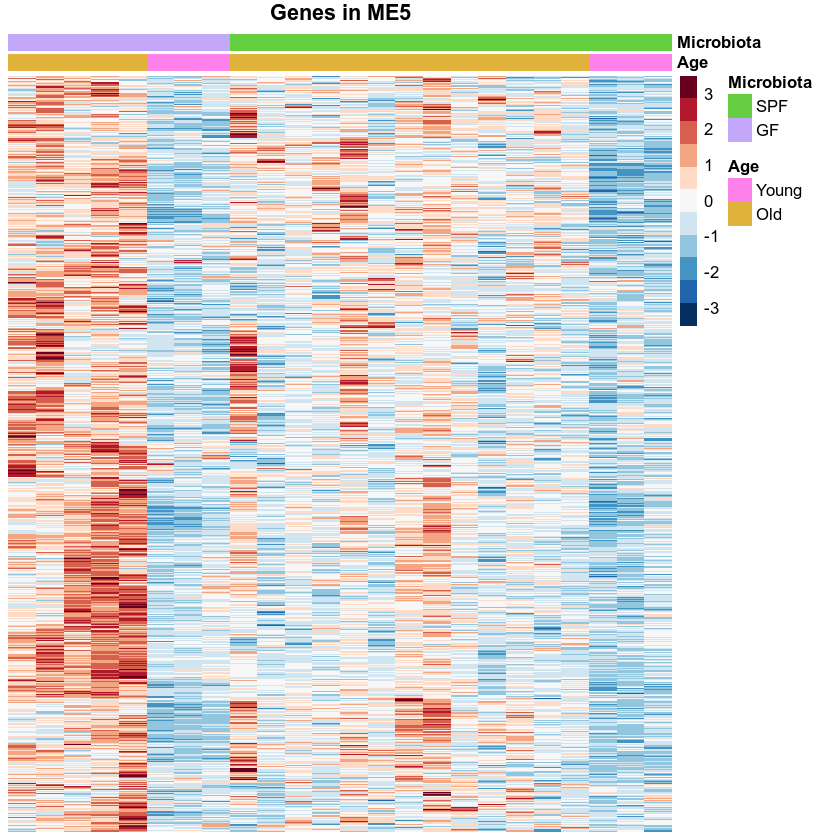

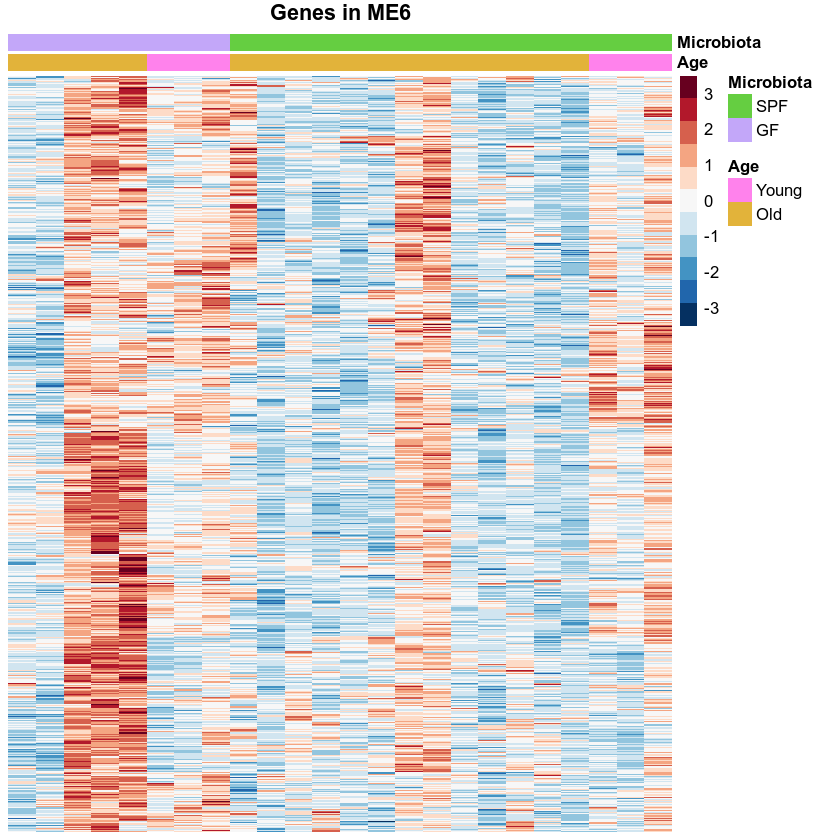

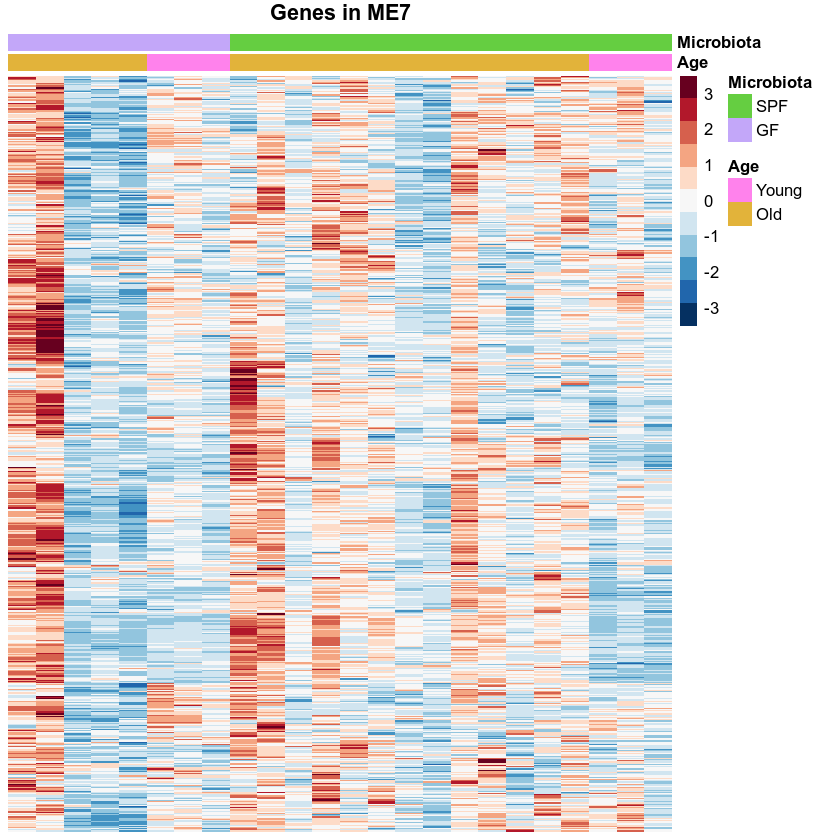

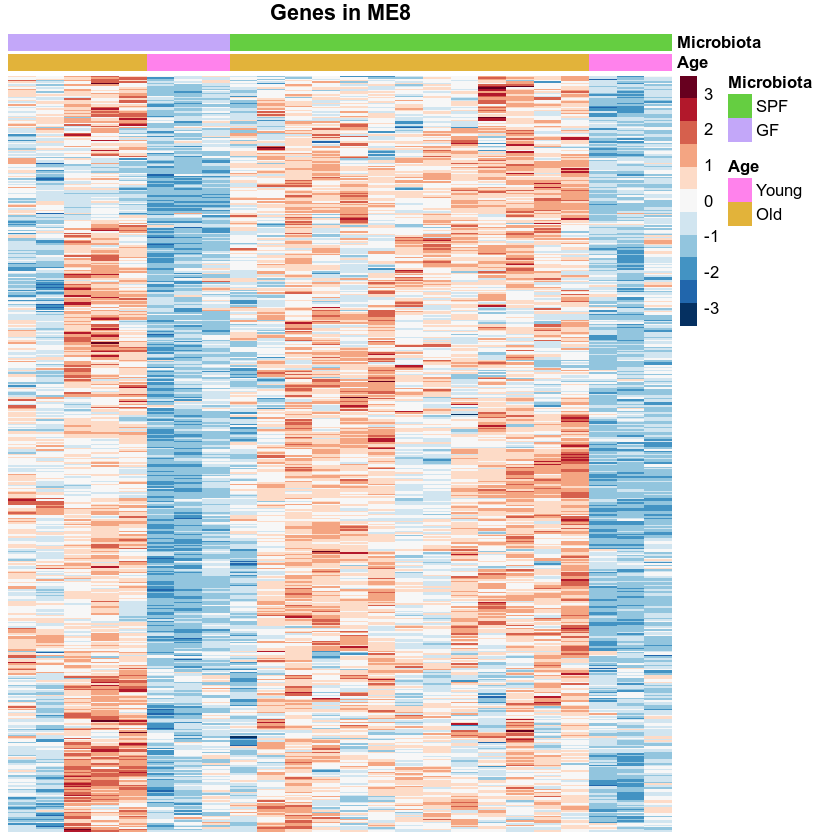

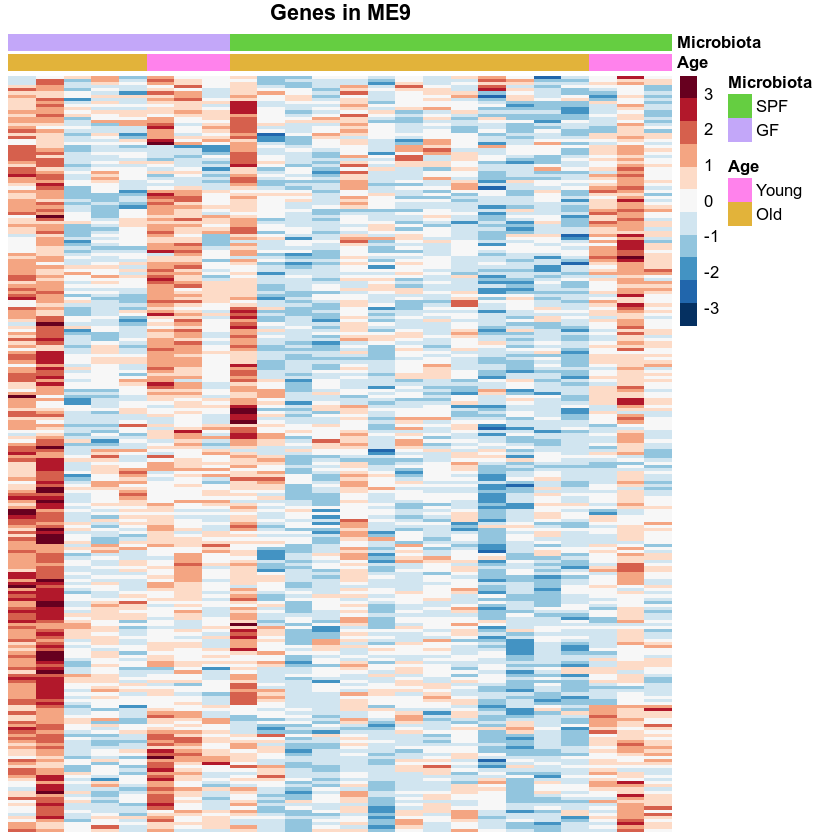

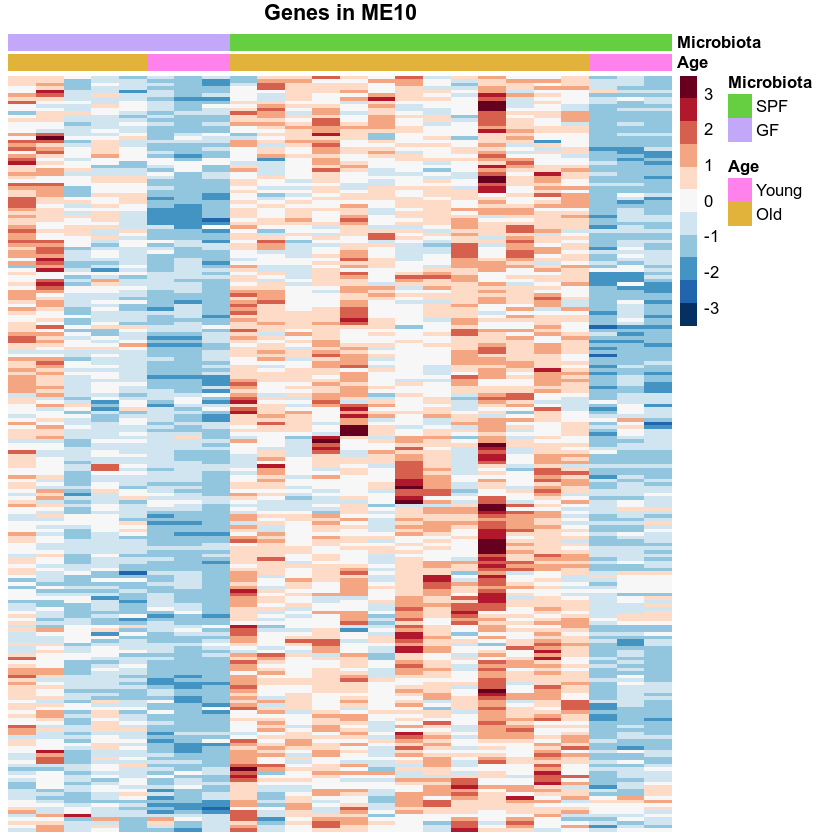

In [69]:
for(x in names(mod_sizes)){
    plot_z_score_heatmap(z_scores,
                         genes_in_modules[[x]],
                         col_order$ma,
                         annot_col$ma,
                         paste("Genes in ", x, sep=""),
                         col_order$ma,
                         fp=paste(module_dp, "module_heatmap", x, ".pdf", sep=""))
}

#### Age  / Microbiota

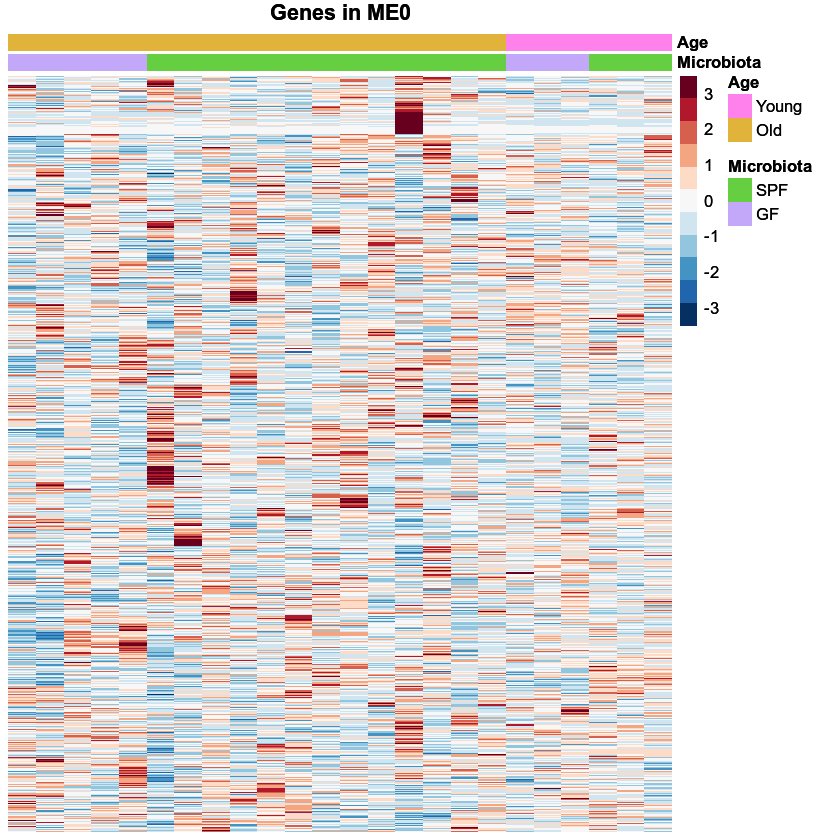

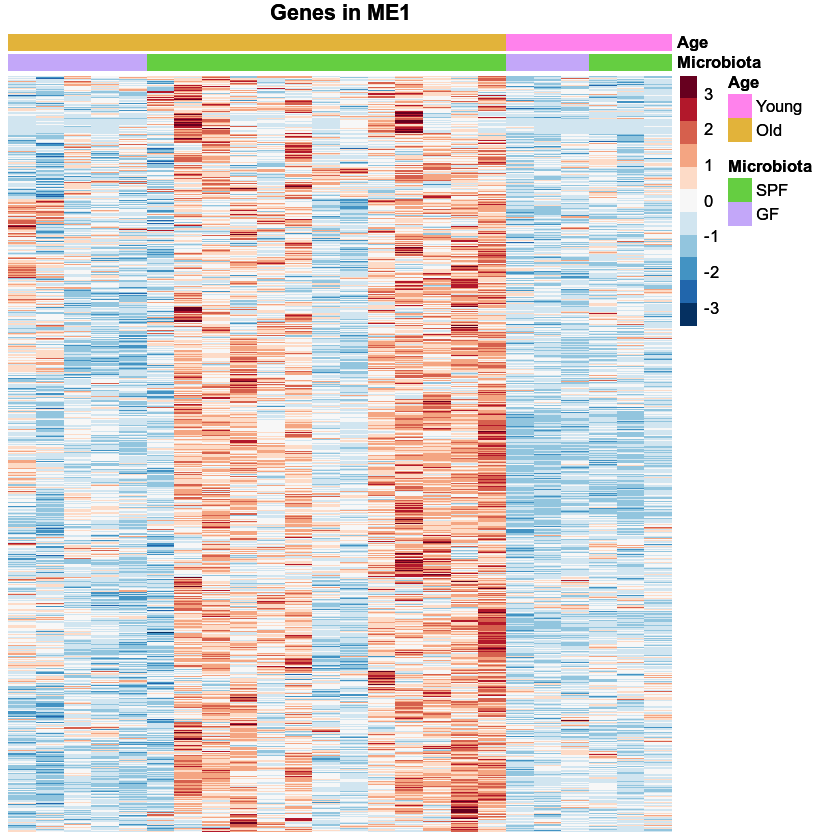

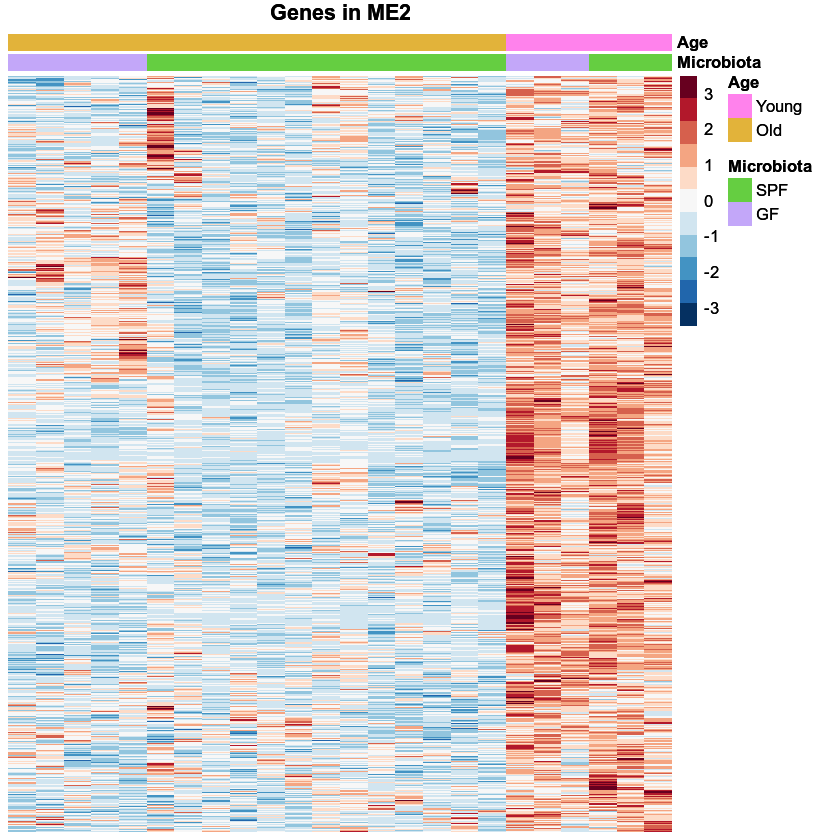

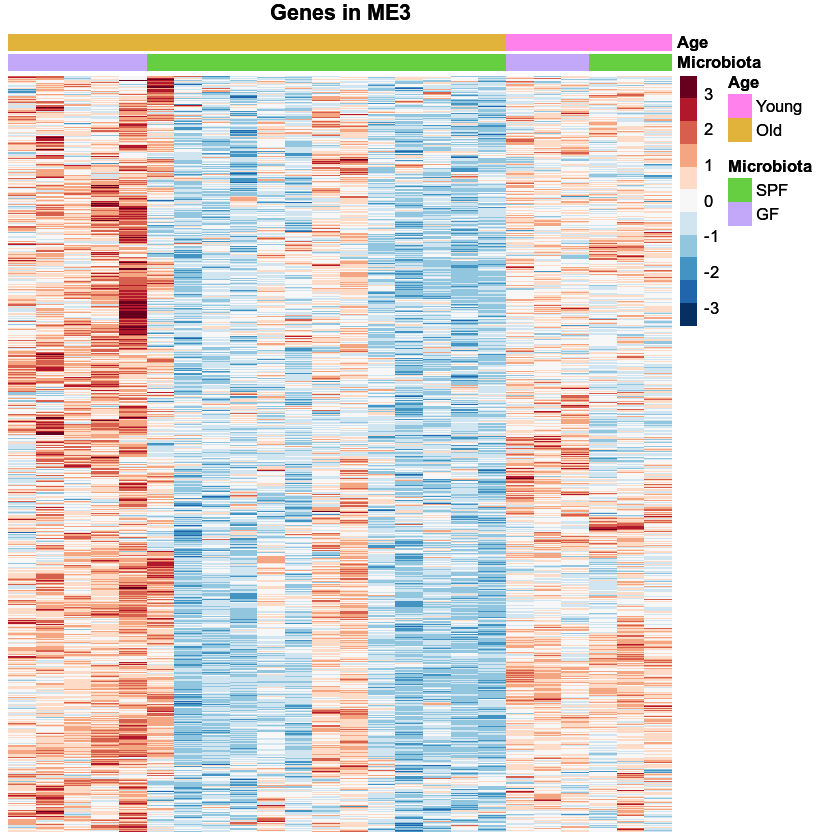

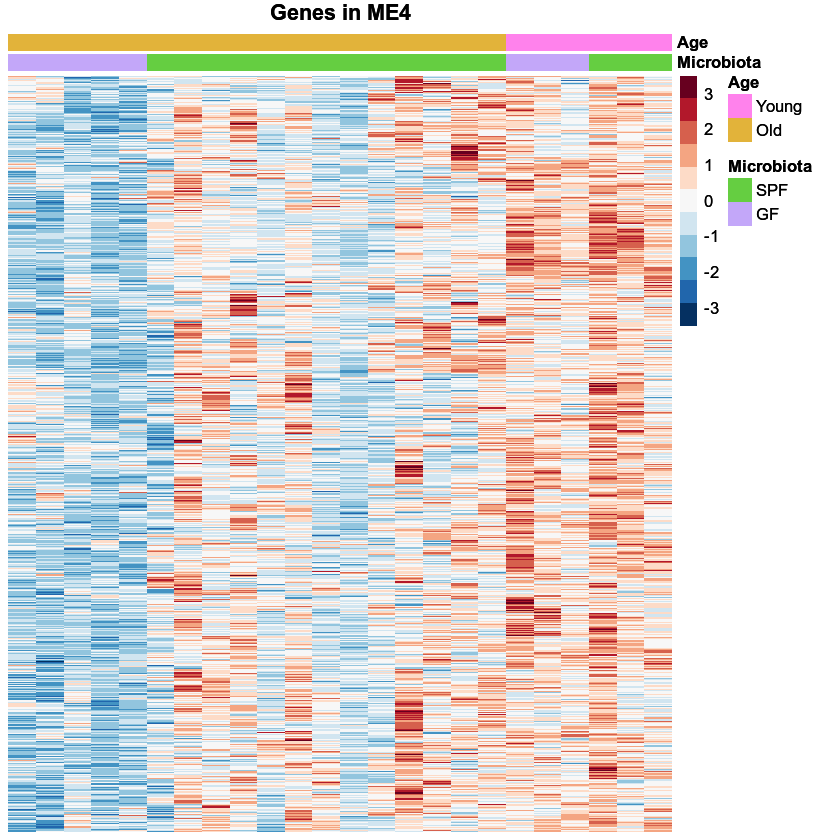

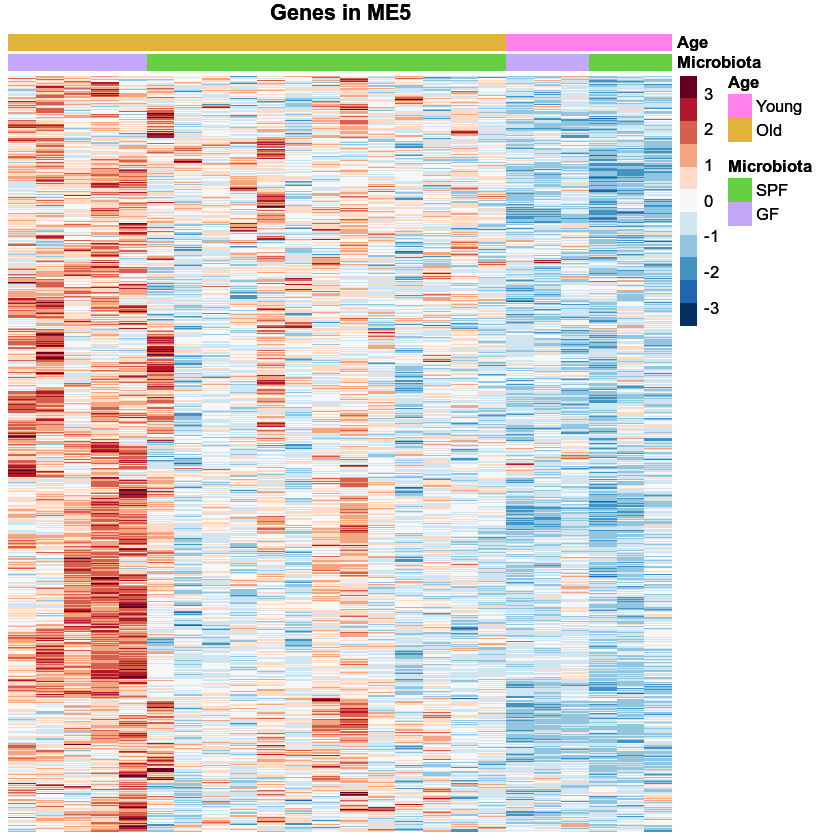

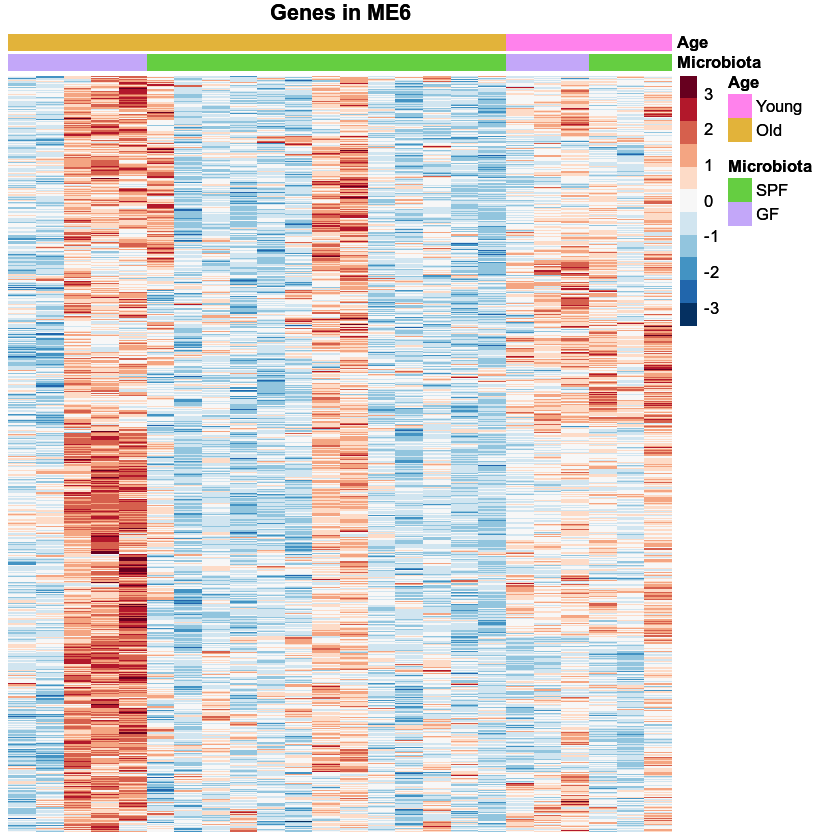

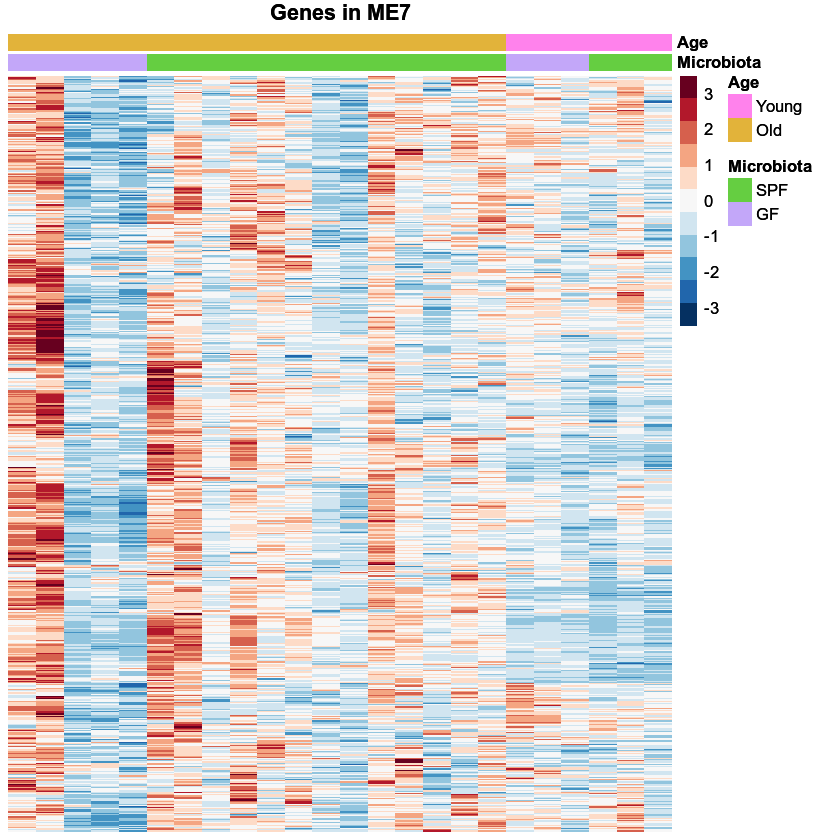

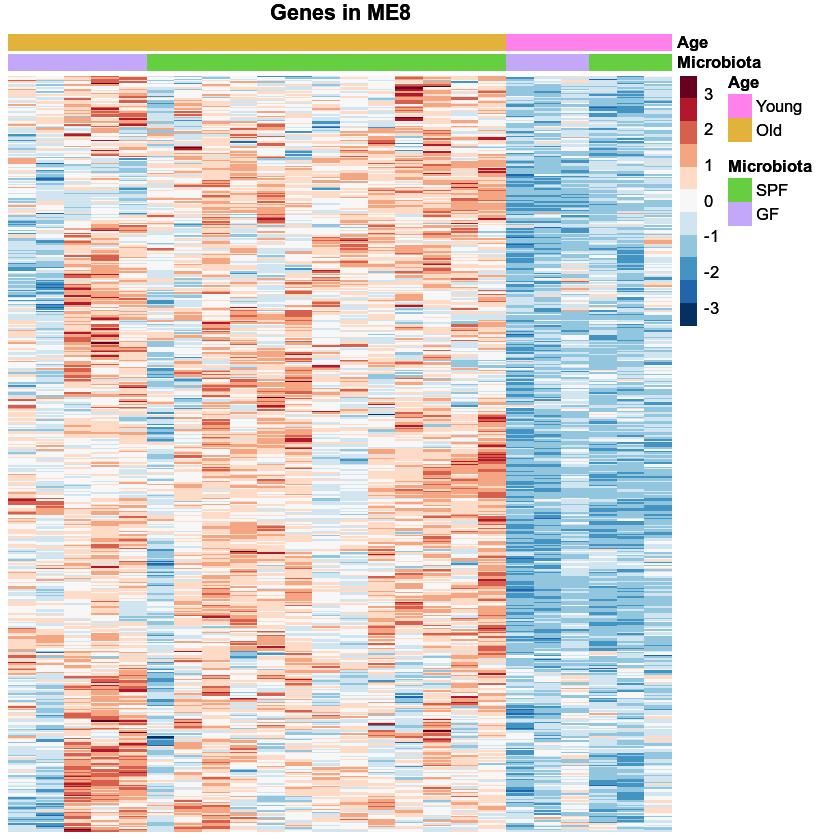

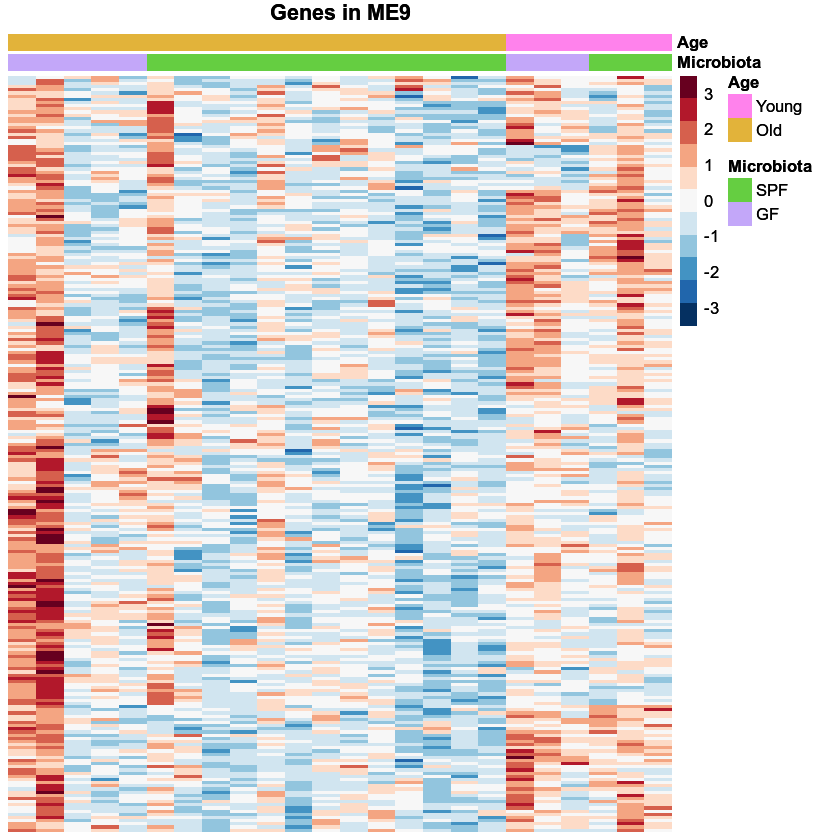

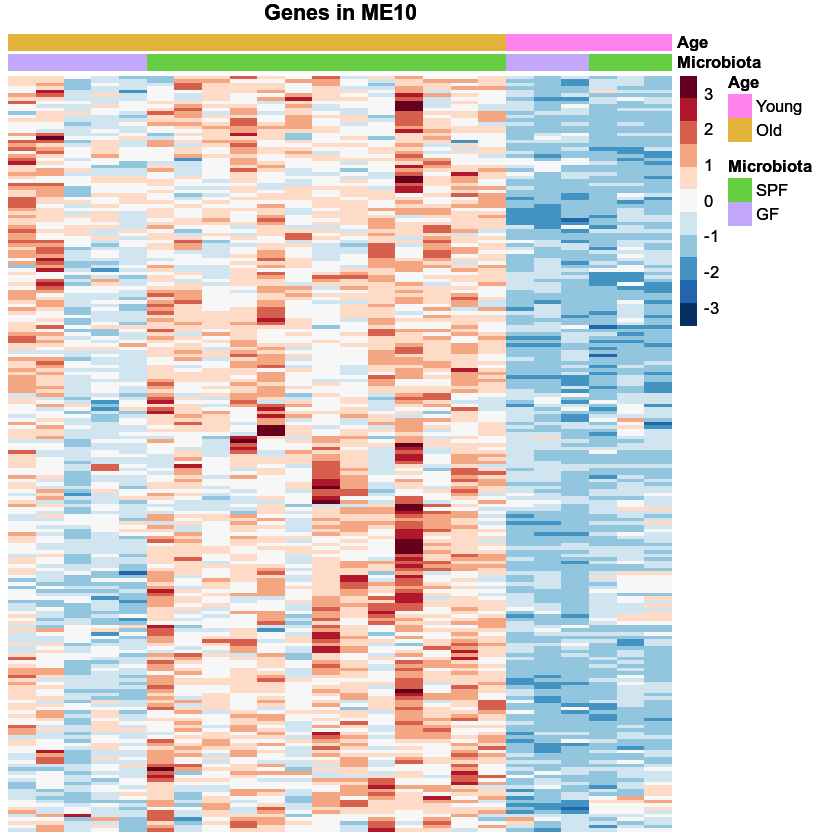

In [70]:
for(x in names(mod_sizes)){
    plot_z_score_heatmap(z_scores,
                         genes_in_modules[[x]],
                         col_order$am,
                         annot_col$am,
                         paste("Genes in ", x, sep=""),
                         col_order$am)
}

### Sinaplots of the Z-scores per groups

The mean of the Z-score over the samples in the group is plot for each gene

In [71]:
plot_z_score_sinaplot = function(g, trait, z_scores, module_nb, genes_in_modules, pdf = FALSE){
    g_trait = trait[[g]]
    for(x in names(mod_sizes)){
        genes_in_mod = genes_in_modules[[x]]
        z_scores_vec = c()
        groups = c()
        for(y in colnames(g_trait)[-1]){
            samples = g_trait %>% 
                filter((!!as.name(y)) == 1) %>%
                pull(sample)
            mean_z_scores = apply(z_scores[genes_in_mod, samples], 1, mean)
            mean_z_scores = mean_z_scores[is.finite(mean_z_scores)]
            z_scores_vec = c(z_scores_vec, mean_z_scores)
            groups = c(groups, rep(y, length(mean_z_scores)))
        }
        sinaplot(z_scores_vec, 
                 groups,
                 col=pal2[x],
                 pch = 20,
                 bty = "n",
                 main=paste("Z-scores for the ", mod_sizes[x], " genes in ", x, sep=""),
                 las=2,
                 ylab = "Mean Z-scores of the genes over samples",
                 cex.axis=0.75)
        if(pdf){
            pdf(paste(module_dp, "module_sinaplot_", x, ".pdf", sep=""))
            sinaplot(z_scores_vec, 
                     groups,
                     col=pal2[x],
                     pch = 20,
                     bty = "n",
                     main = paste("Z-scores for genes in ", x, sep=""),
                     las=2,
                     ylab = "Mean Z-scores of the genes over samples",
                     cex.axis=0.75)
            dev.off()
        }
    }
}

#### Microbiota / Age

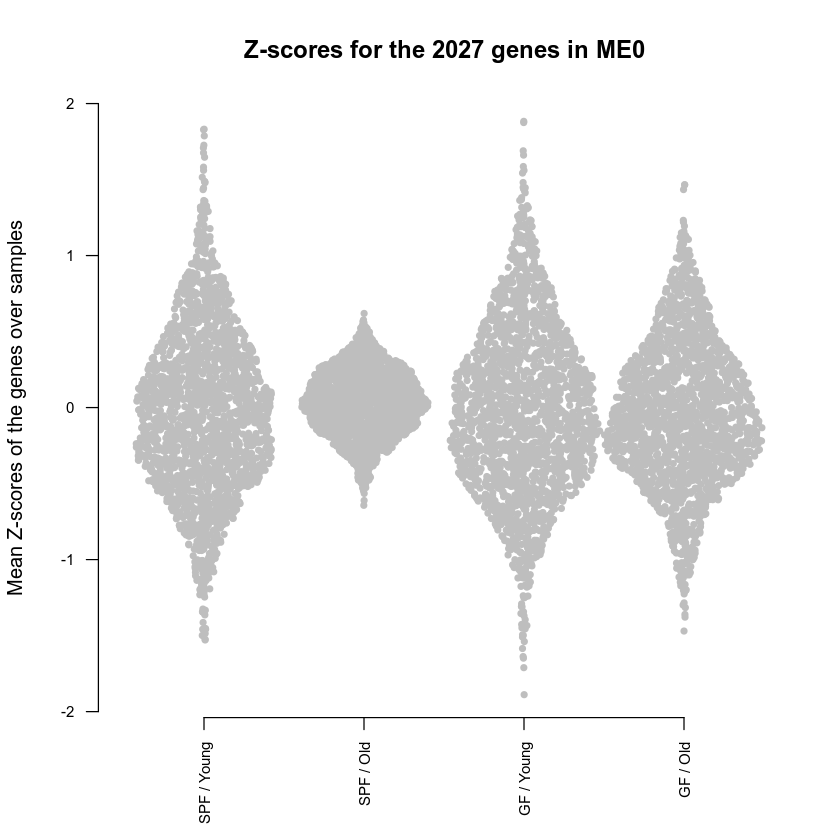

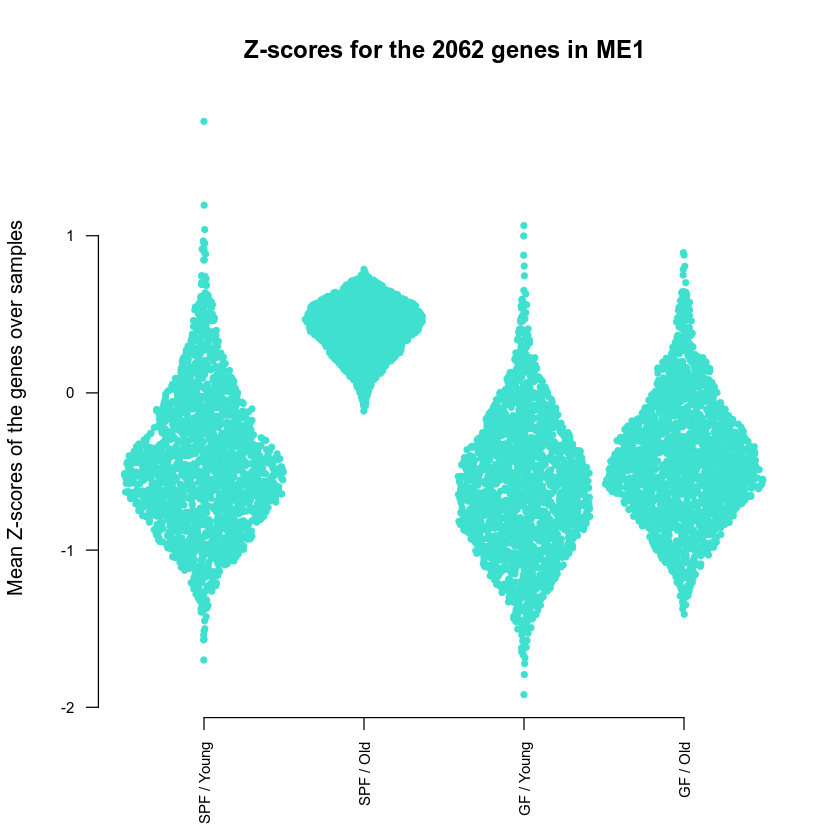

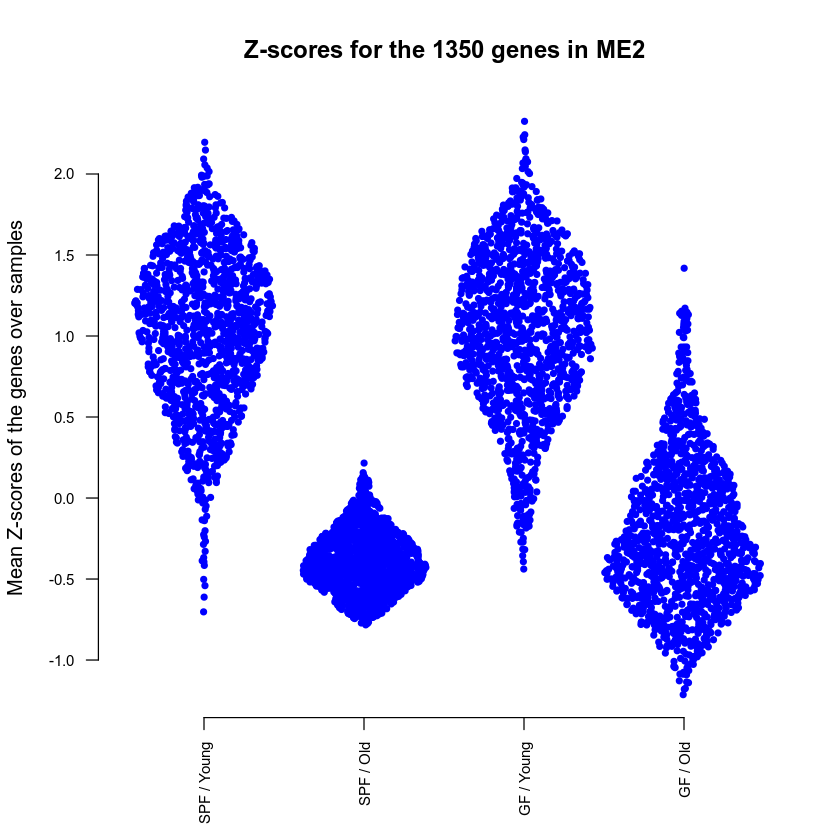

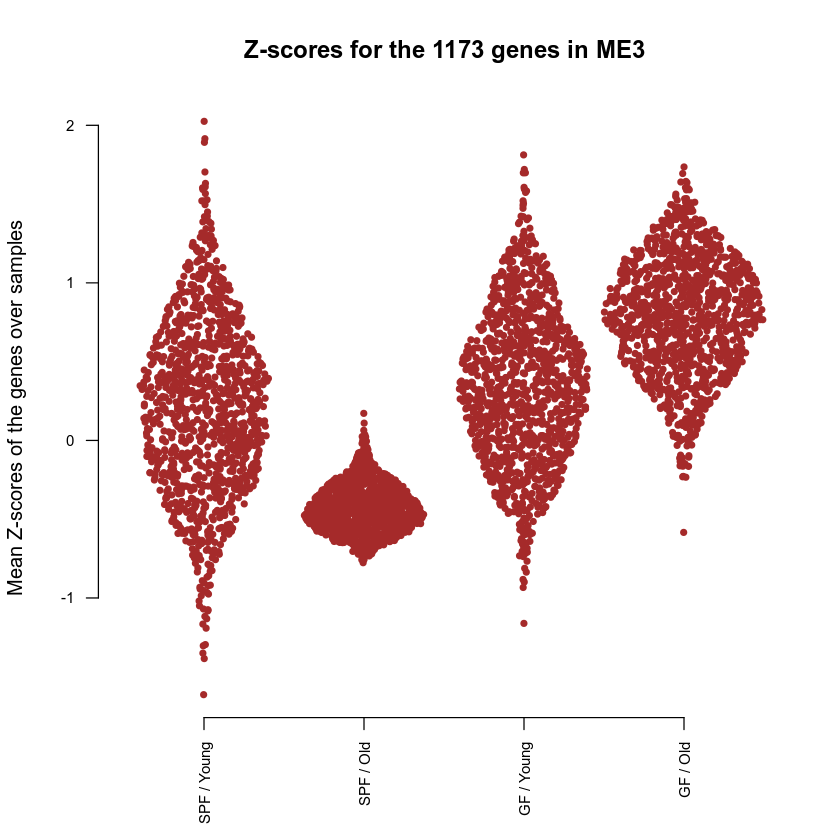

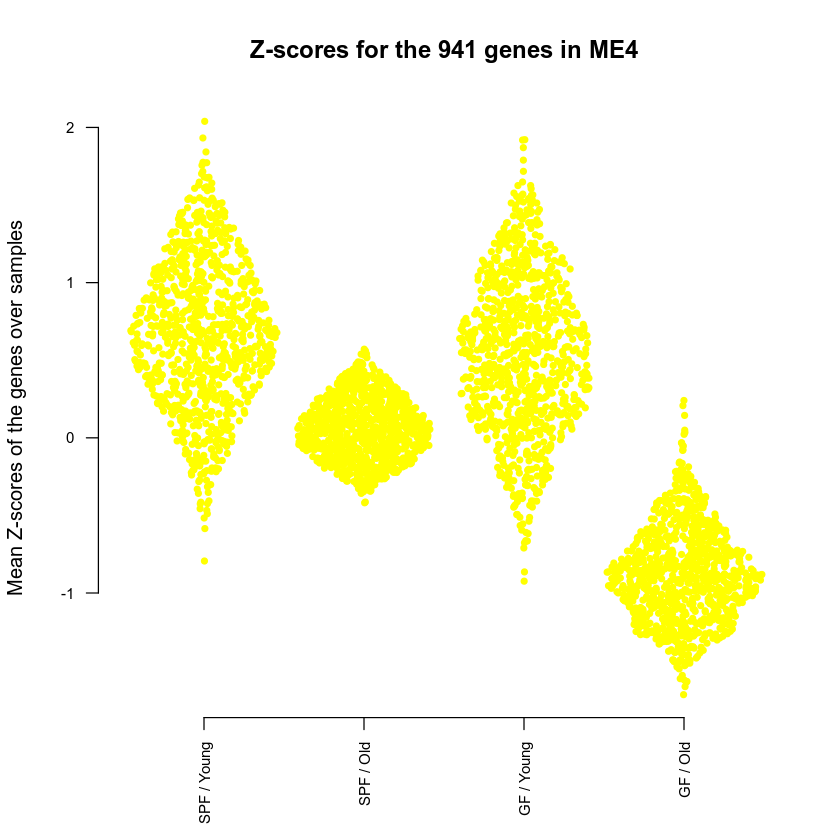

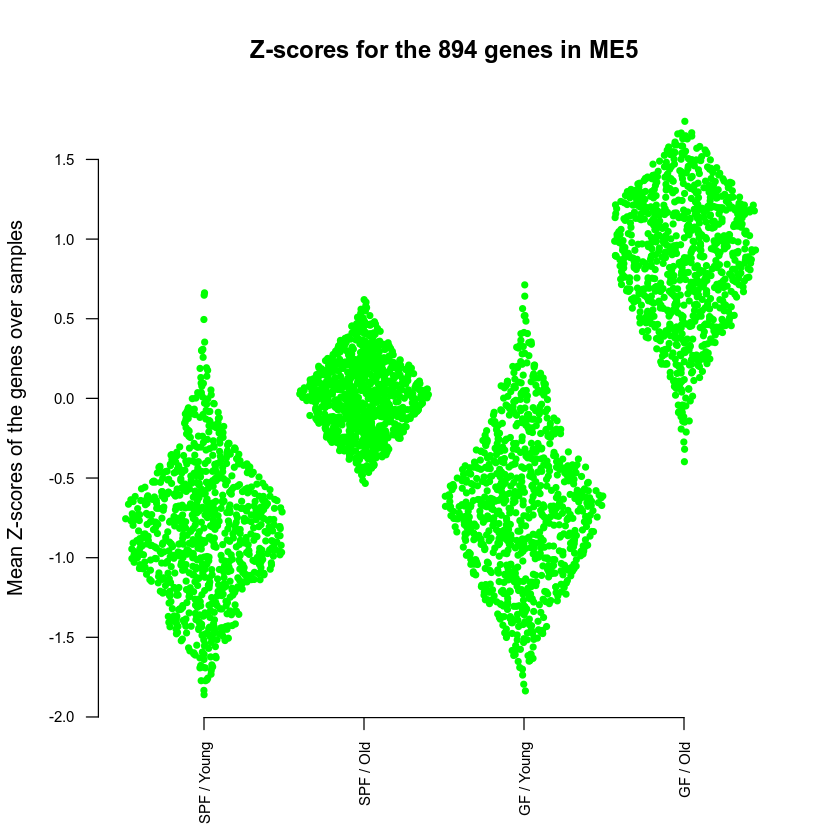

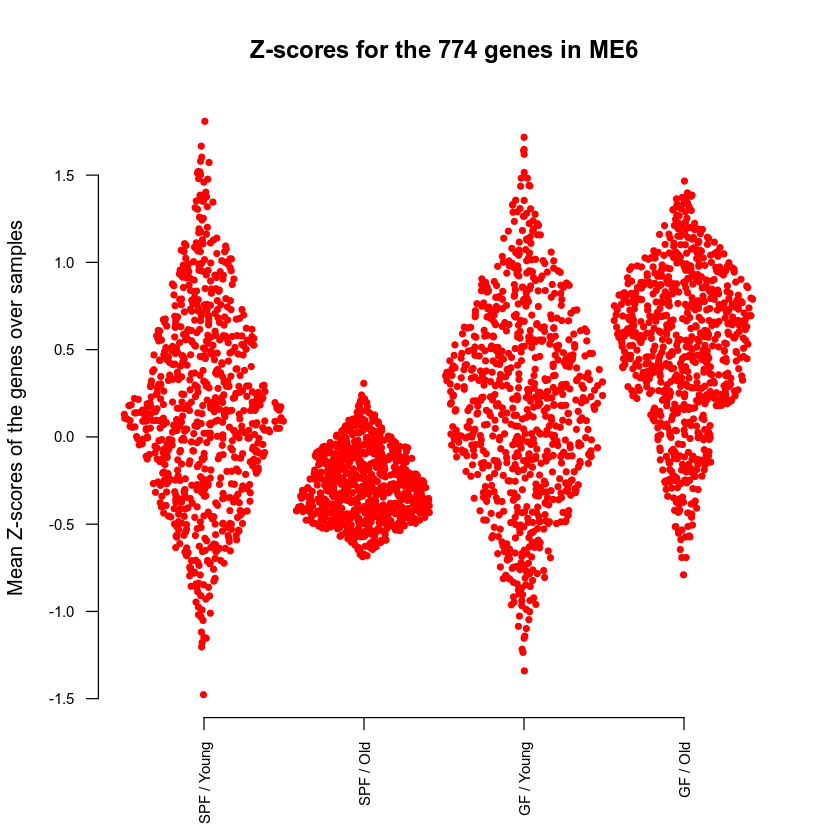

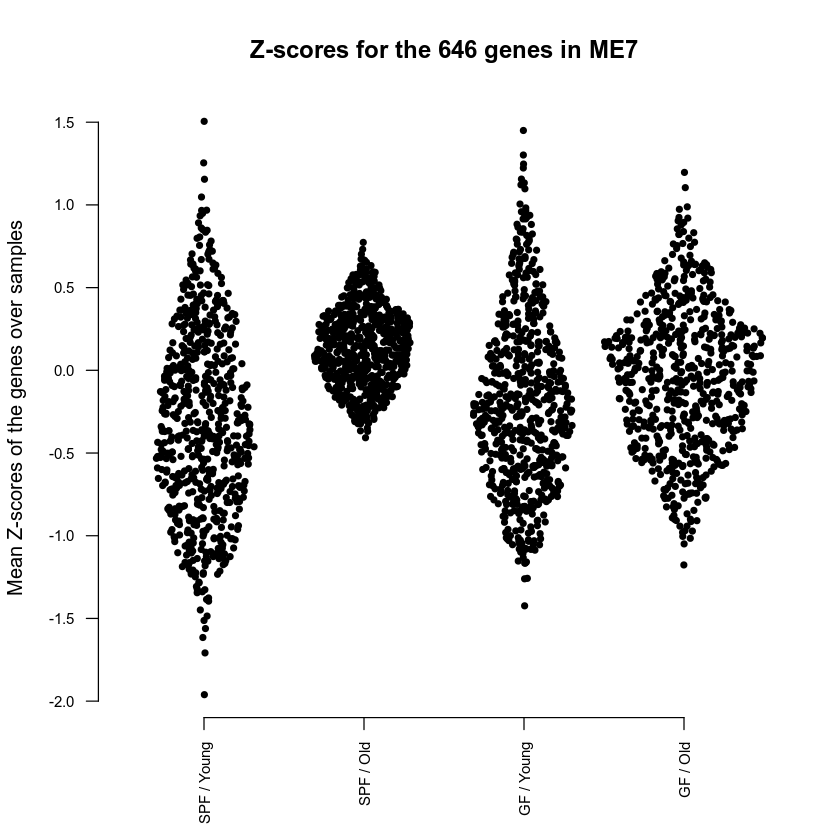

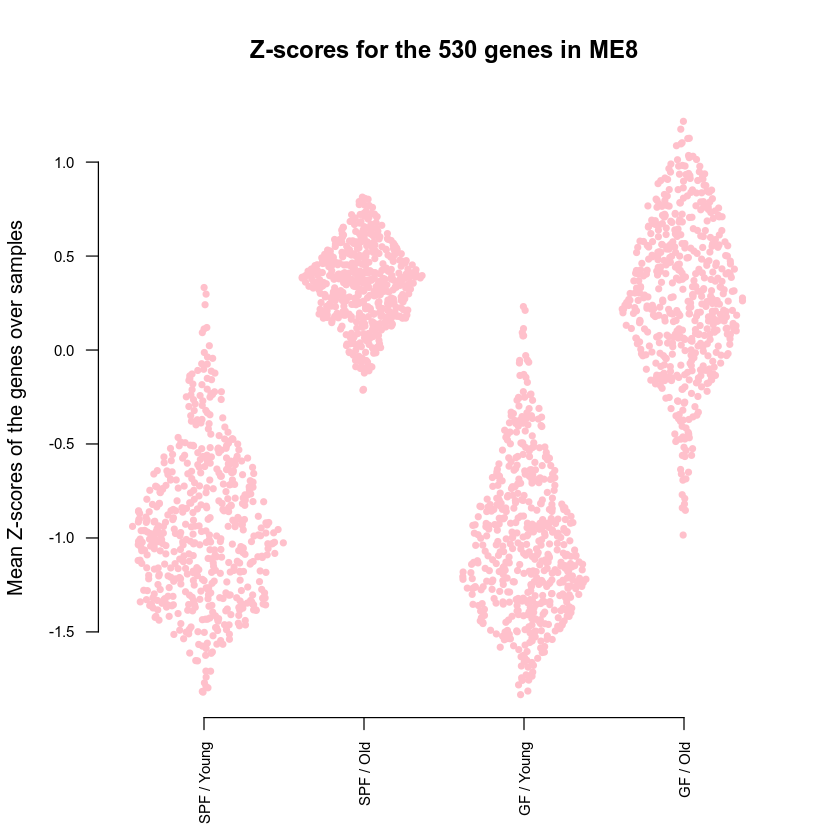

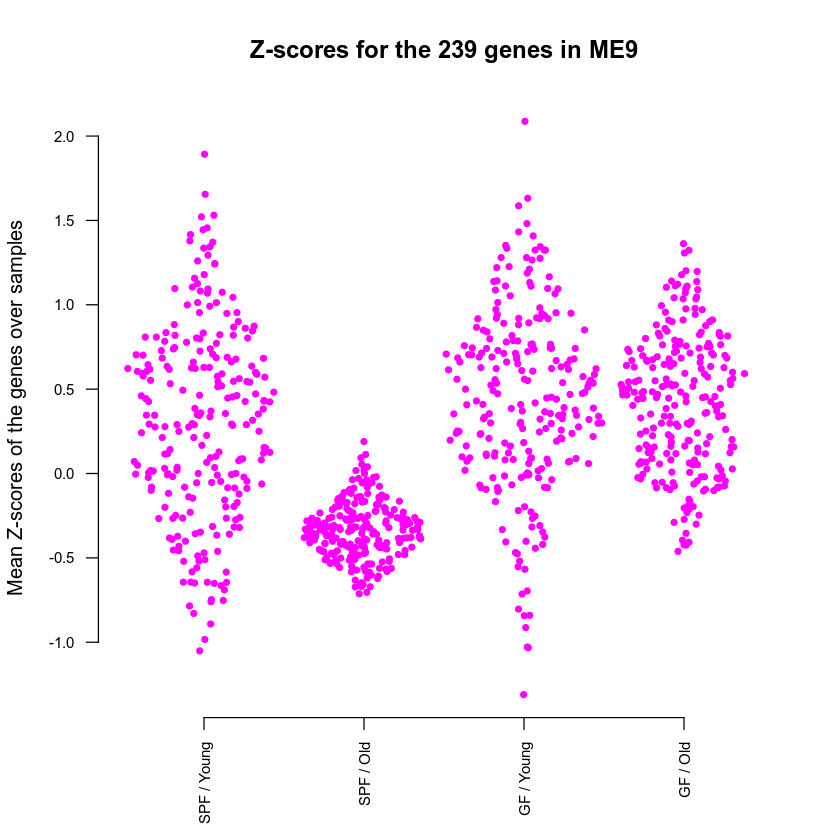

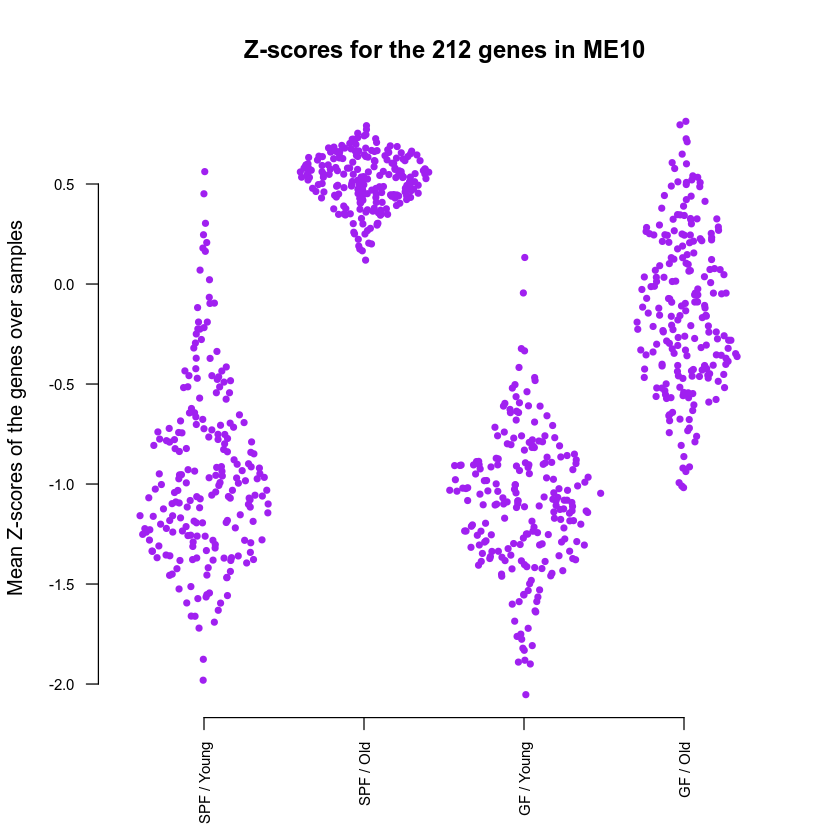

In [72]:
plot_z_score_sinaplot('Microbiota / Age', trait, z_scores, module_nb, genes_in_modules)

#### Age / Microbiota

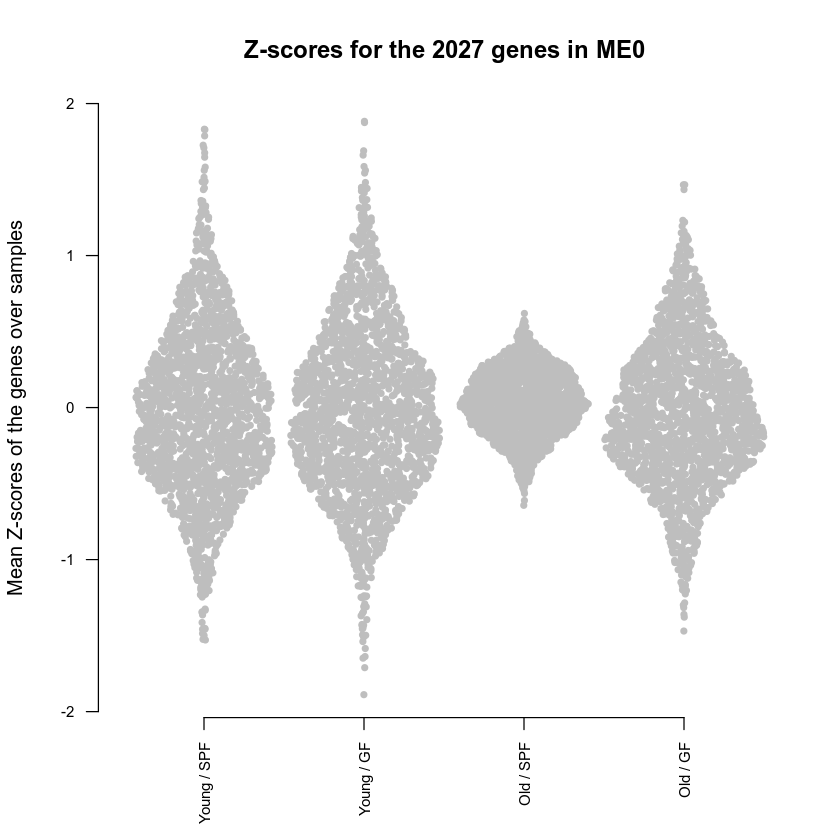

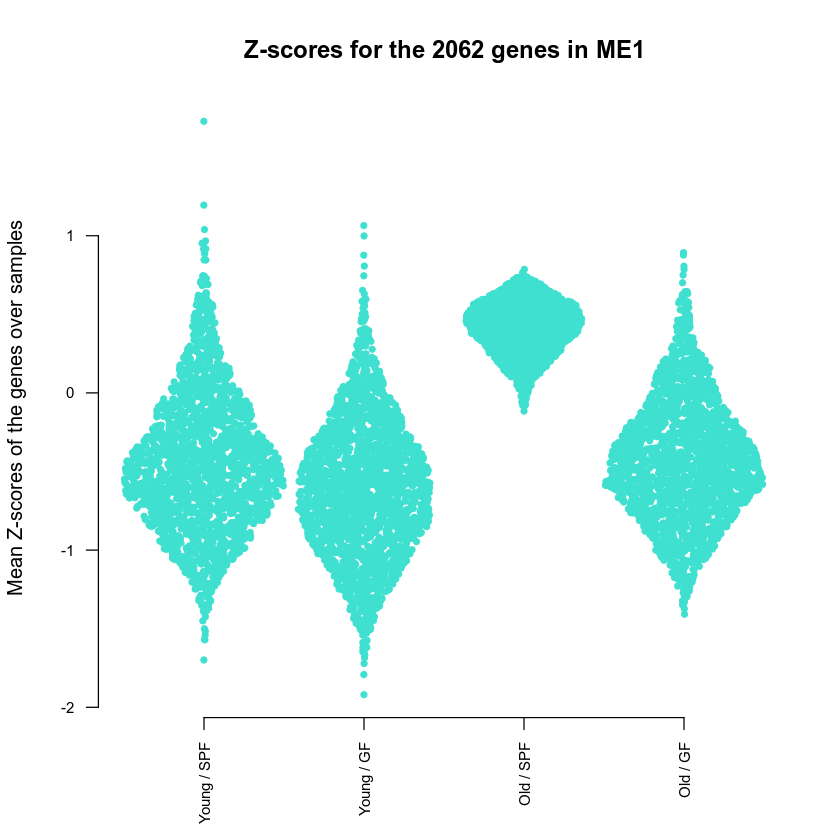

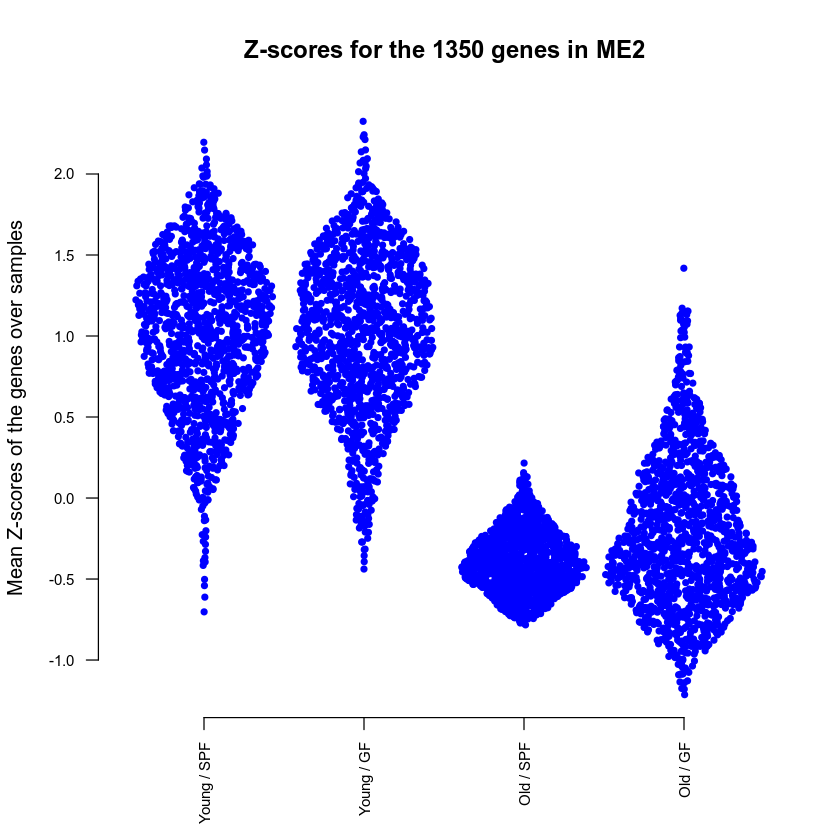

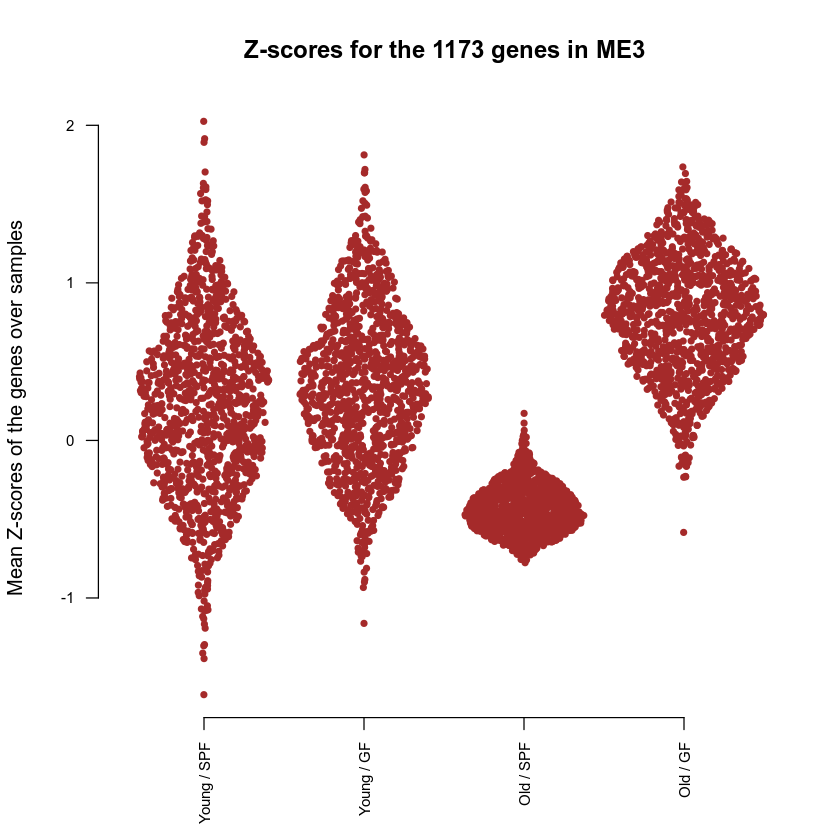

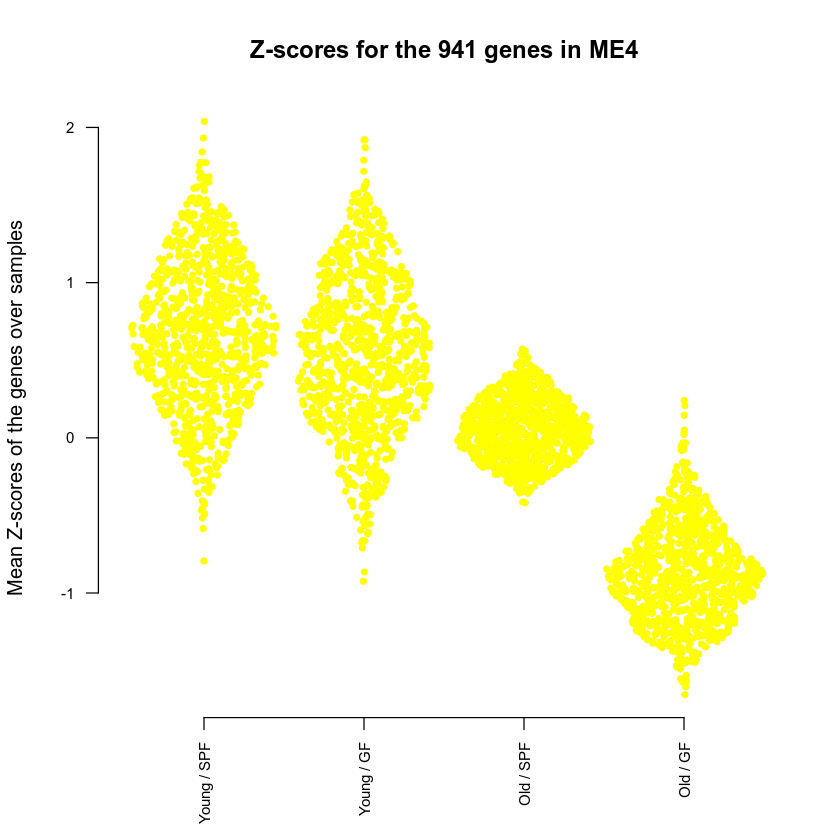

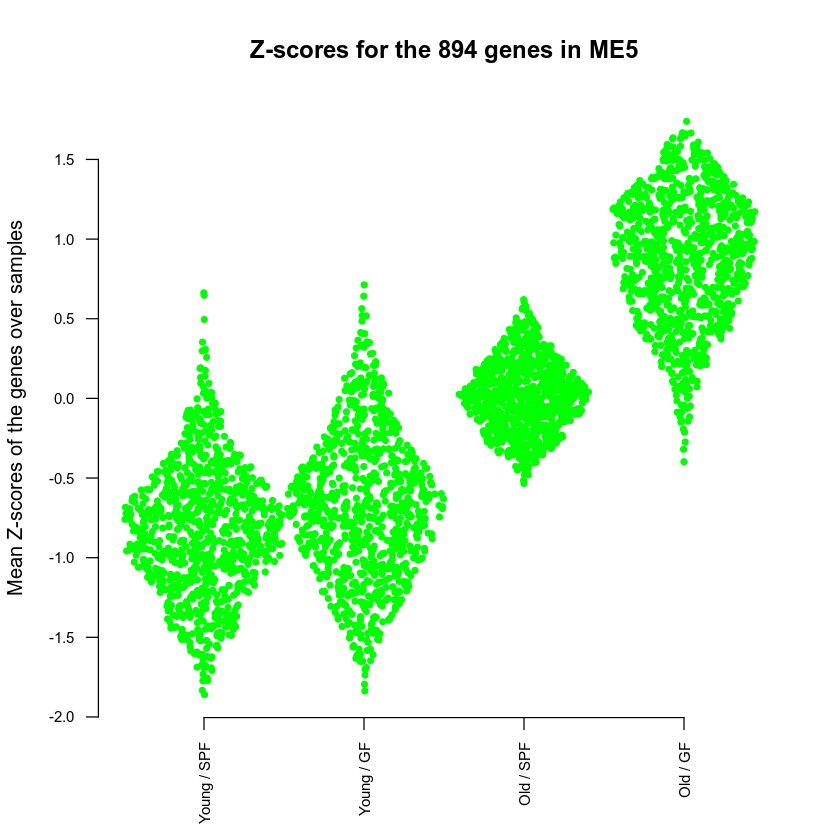

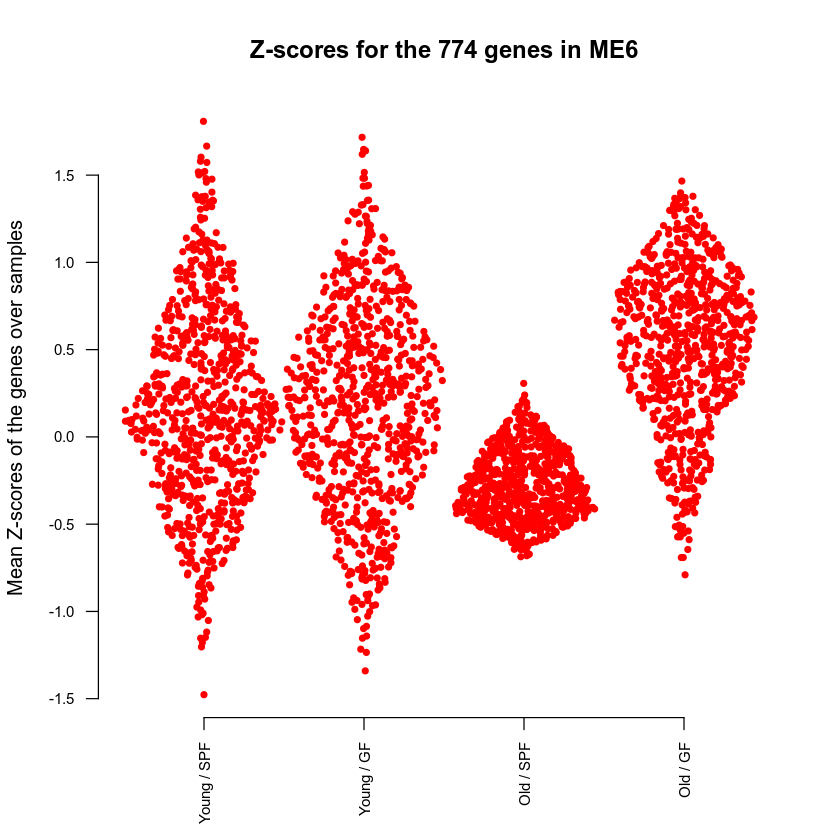

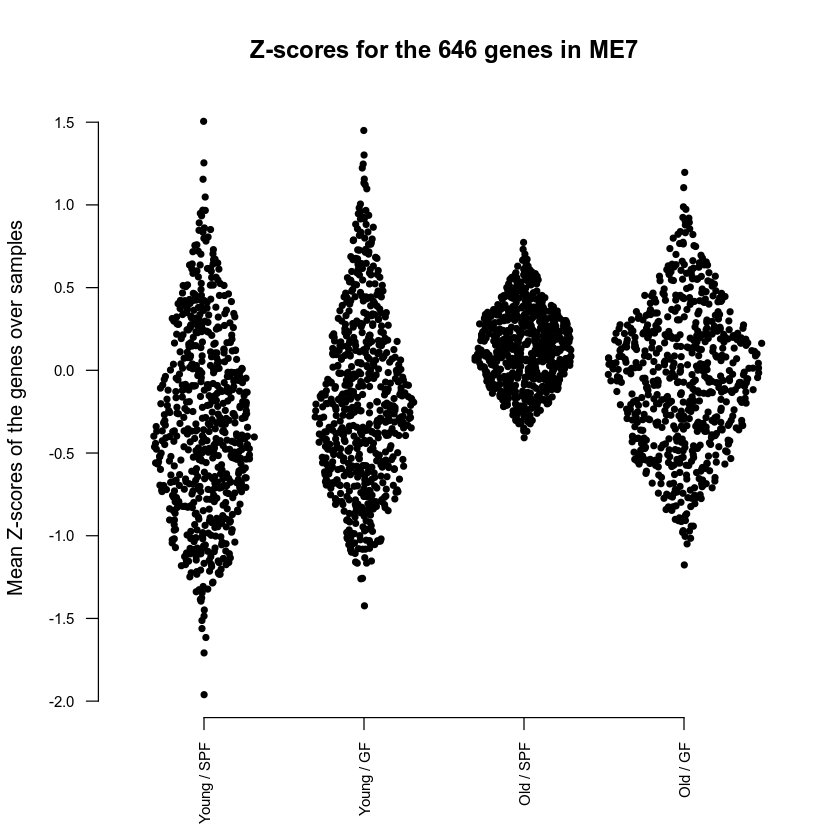

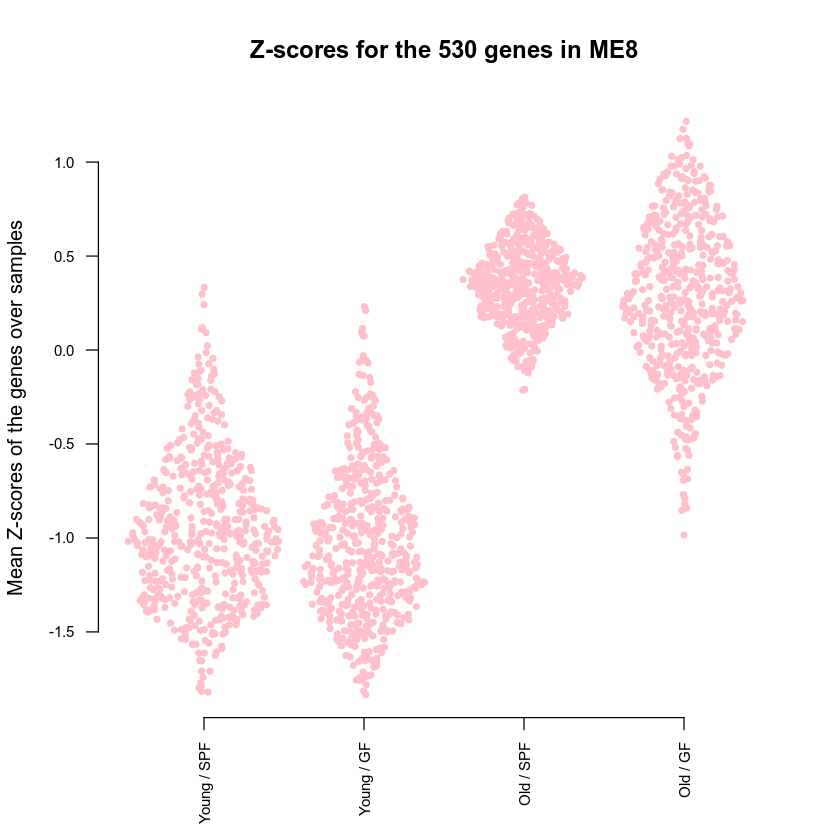

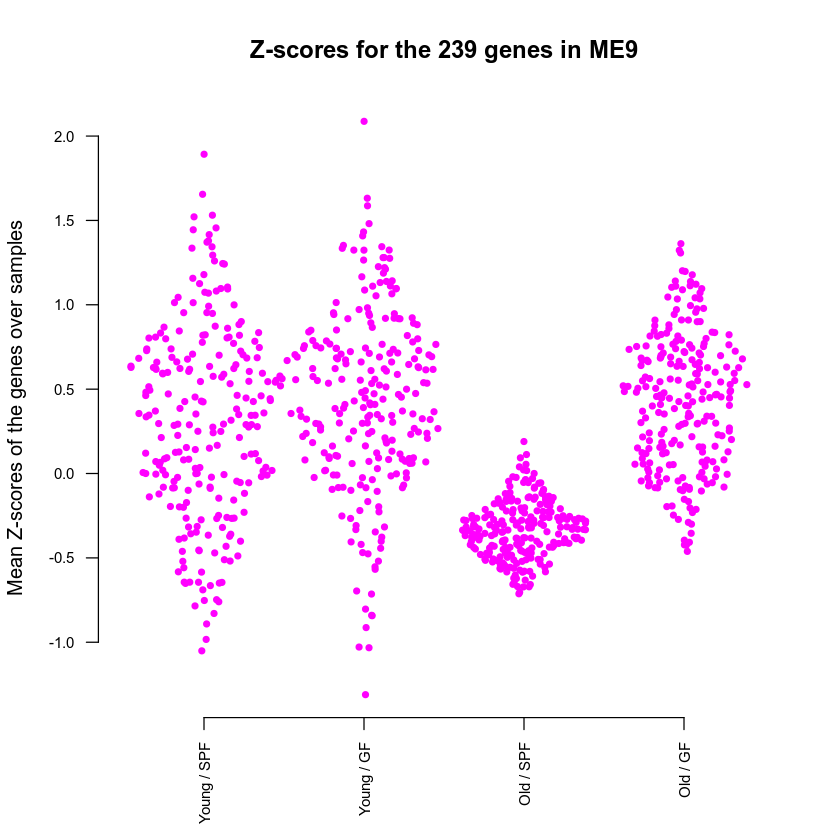

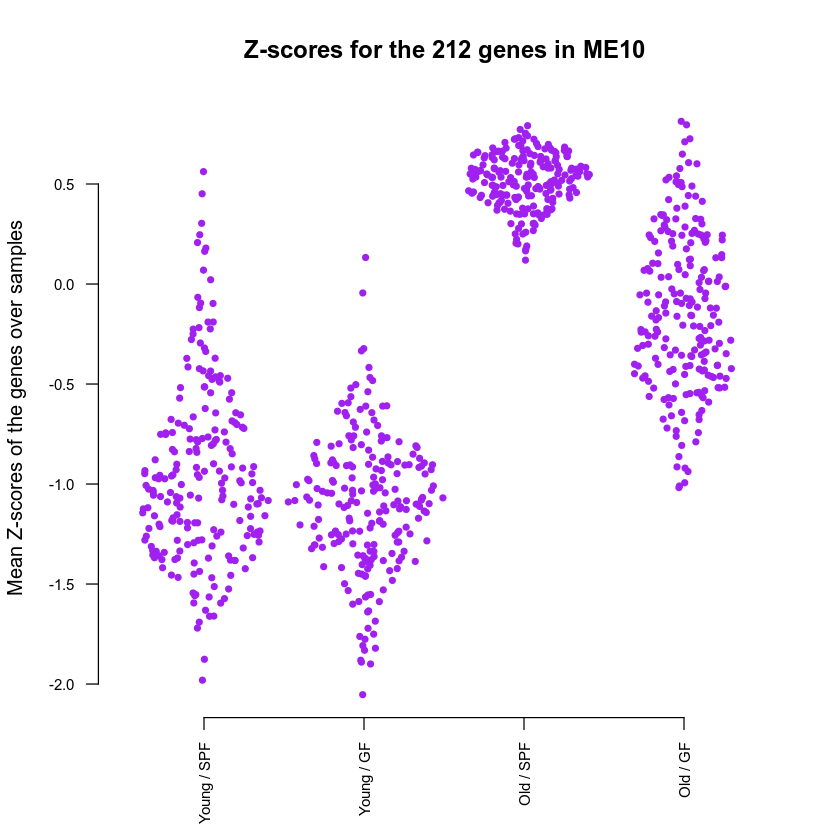

In [73]:
plot_z_score_sinaplot('Age / Microbiota', trait, z_scores, module_nb, genes_in_modules)

### Selected genes in modules

In [74]:
selected_genes = c('Ash1l', 'Ddit4', 'Cadm1', 'Axl', 'Atad2b', 'Gpd1', 'Capg', 'Ccl12', 'Atm', 'Ezr', 'Cd22',
                   'Cxcl10', 'Atr', 'Klf2', 'Cd81', 'Cd180', 'Atxn7', 'Per1', 'Crlf2', 'Fgr', 'Cep350', 
                   'Pid1', 'Emp2', 'Hif1a', 'Cep95', 'Rgs1', 'Gsn', 'Ifit2', 'Chd2', 'Tmod1', 'H2-m3', 'Il1b',
                   'Huwe1', 'Trpv4', 'H2-dma', 'Il6st', 'Kmt2c', 'Fkbp5', 'Ly9', 'Ldlr', 'Lyst', 'Slc1a5', 
                   'Tnfsf13b', 'Stat1', 'Mapk8', 'Tnfsf10', 'Tlr2', 'Lyst', 'Tnfsf8', 'Mapk8', 'Mga', 'Setd2',
                   'Srcap', 'Tet2', 'Ubr4')

png 
  2

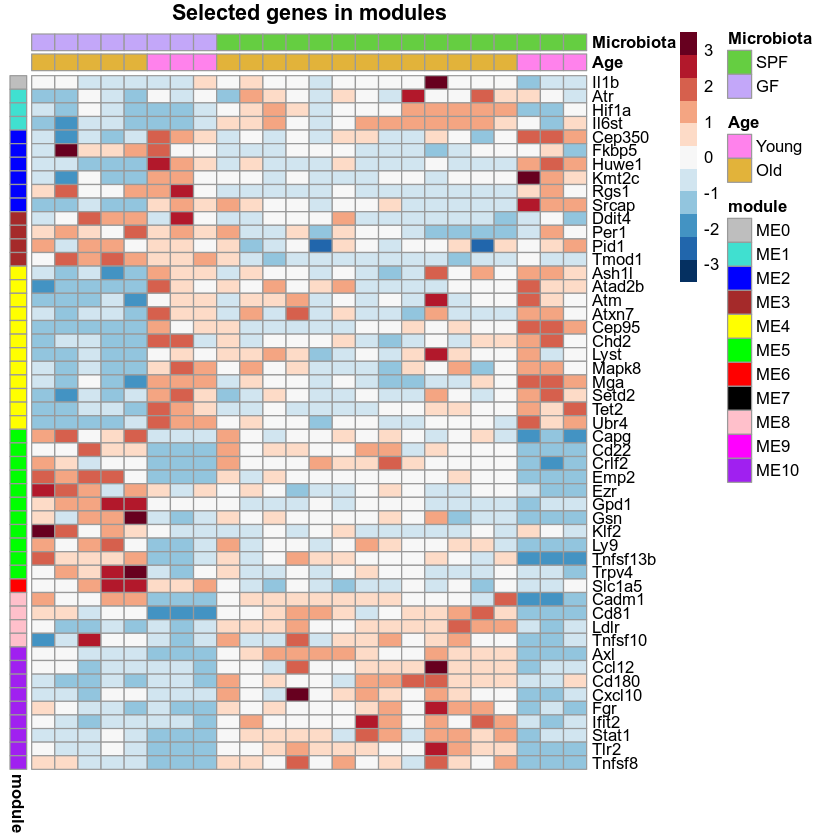

In [75]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in modules",
    show_rownames=TRUE,
    fp=paste(module_dp, "selected_genes_in_modules.pdf", sep=''))

In [76]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
selected_genes_in_ME7_ME8 = selected_genes[selected_genes %in% ME7_ME8_genes]

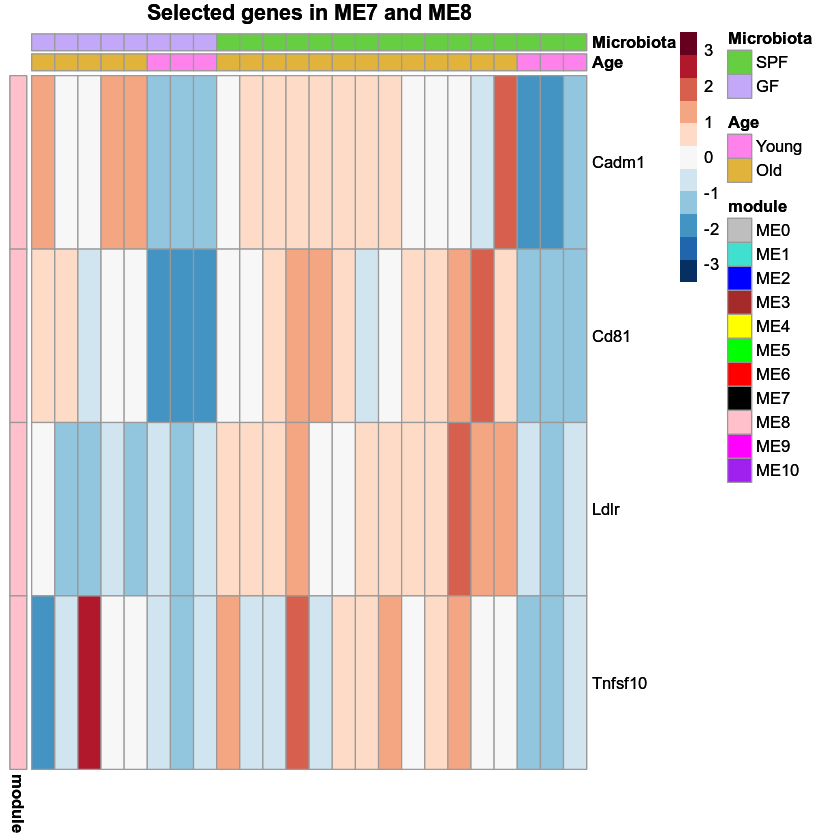

In [77]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes_in_ME7_ME8,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in ME7 and ME8",
    show_rownames=TRUE)

In [78]:
additional_selected_genes = read.csv("../data/additional_selected_genes_modules.txt", sep="\t")

In [79]:
selected_genes = c(selected_genes, additional_selected_genes$Genes)

png 
  2

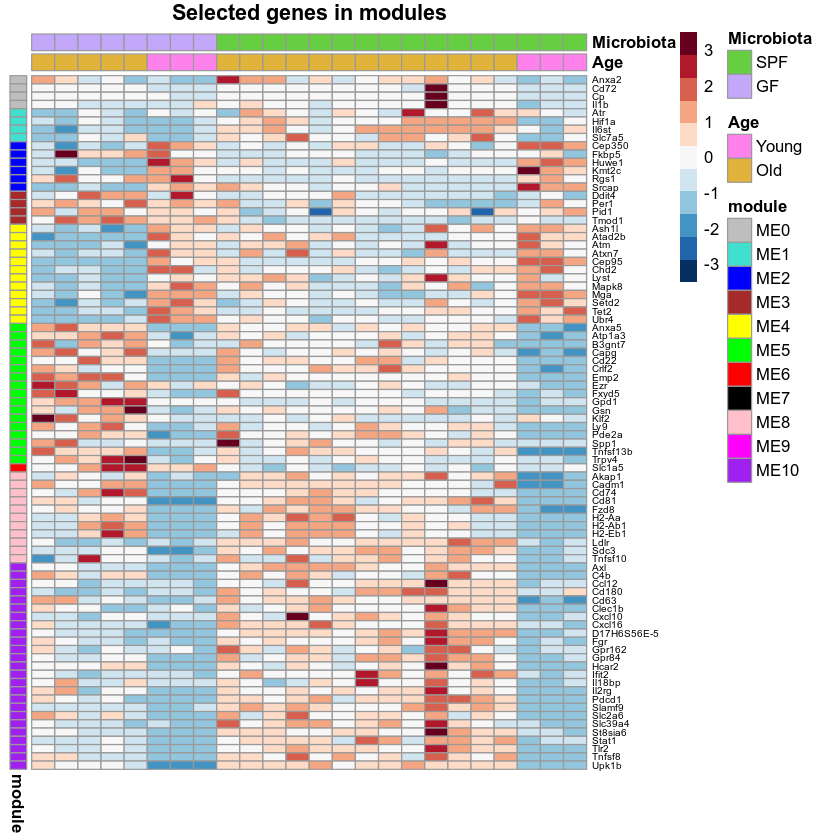

In [80]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in modules",
    show_rownames=TRUE,
    fp=paste(module_dp, "selected_genes_in_modules_2.pdf", sep=''),
    fontsize_row=6)

In [81]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
selected_genes_in_ME7_ME8 = selected_genes[selected_genes %in% ME7_ME8_genes]

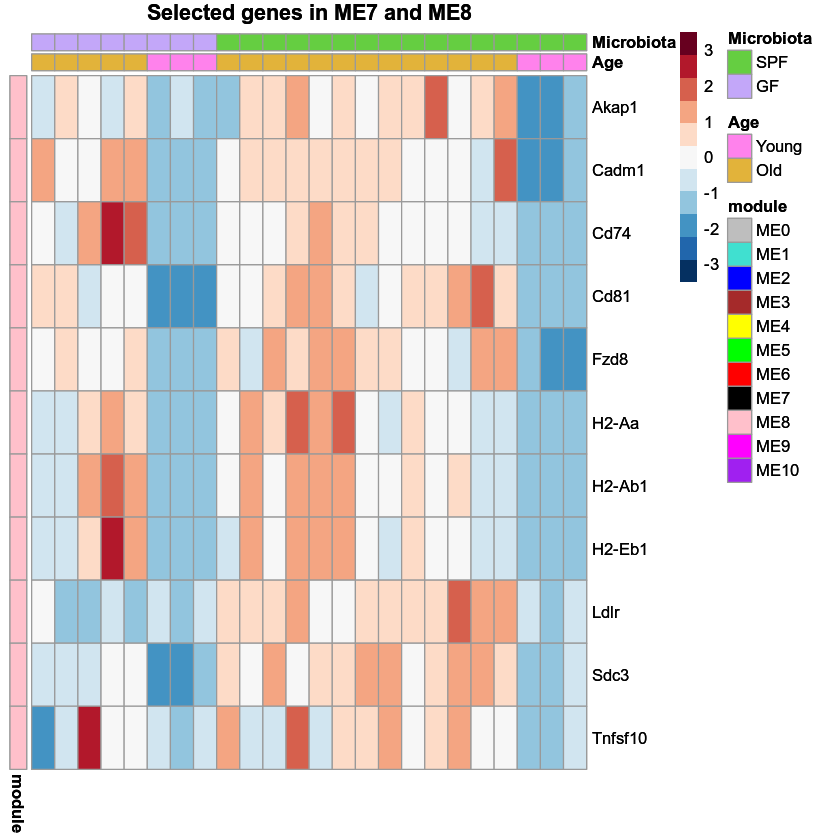

In [82]:
plot_z_score_heatmap_with_modules(
    z_scores,
    selected_genes_in_ME7_ME8,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Selected genes in ME7 and ME8",
    show_rownames=TRUE)

### Genes related to ROS

List of genes extracted from AmiGO, filtered on mouse and contributor to MGI

#### Genes in GO:0000302 (Response to reactive oxygen species)

In [83]:
GO_0000302_ROS_genes = read.table(
    "../data/GO_0000302_ROS_genes.txt", 
    h = F,
    sep='\t',
    col.names=c("Name", "Description", "MGI id"))

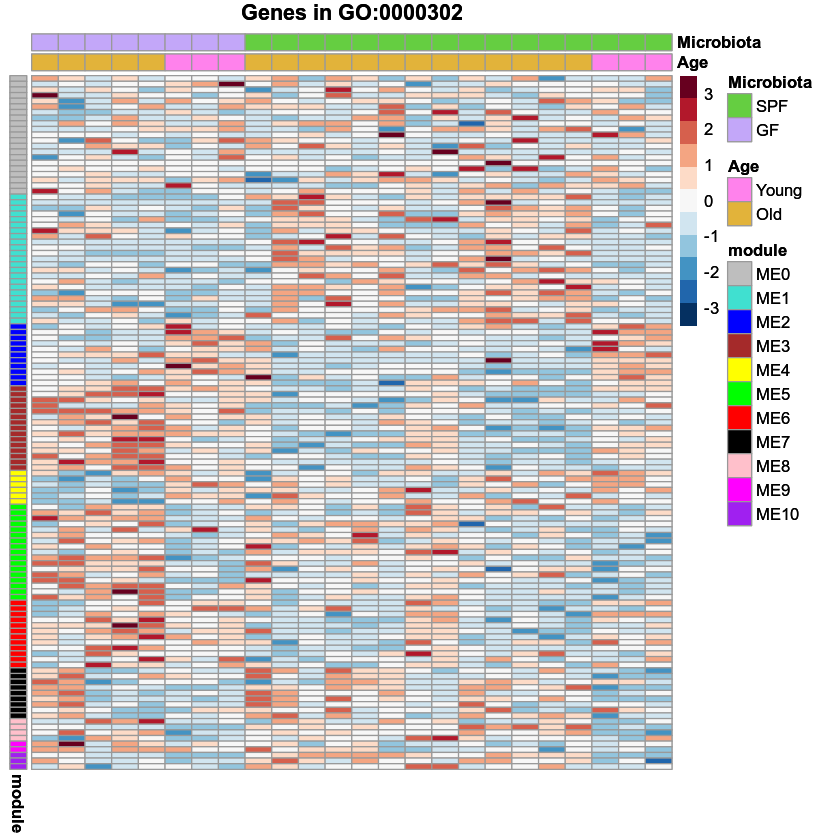

In [84]:
plot_z_score_heatmap_with_modules(
    z_scores,
    GO_0000302_ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in GO:0000302")

#### Genes in GO:2000377 (Regulation of reactive oxygen species metabolic process)

In [85]:
GO_2000377_ROS_genes = read.table(
    "../data/GO_2000377_ROS_genes.txt", 
    h = F,
    sep='\t',
    col.names=c("Name", "Description", "MGI id"))

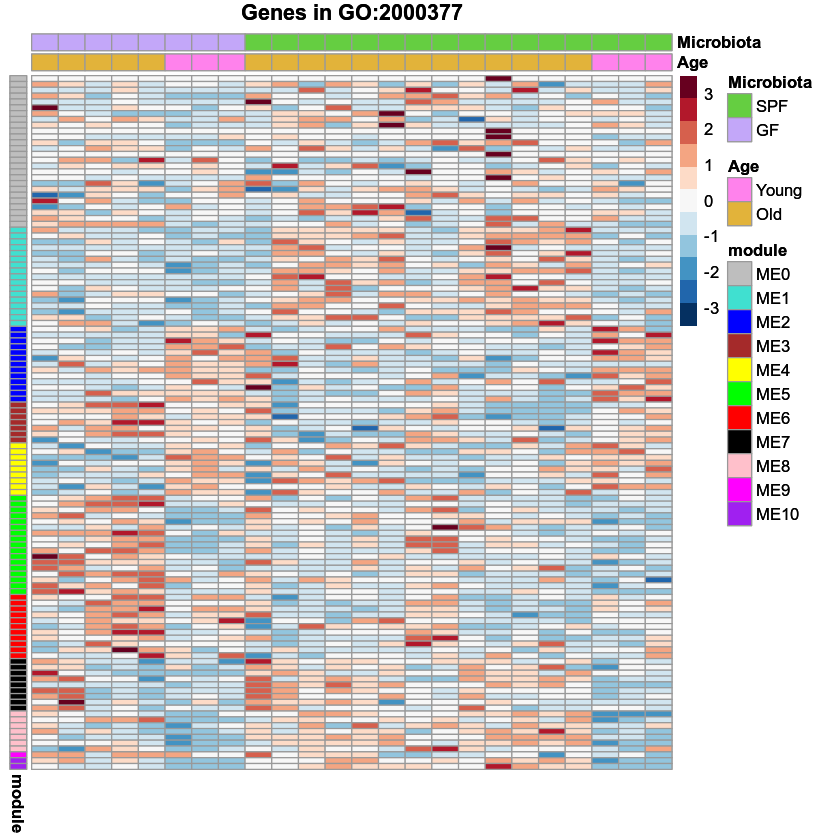

In [86]:
plot_z_score_heatmap_with_modules(
    z_scores,
    GO_2000377_ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in GO:2000377")

#### Genes in both GO:0000302 and GO:2000377

In [87]:
ROS_genes = rbind(GO_0000302_ROS_genes, GO_2000377_ROS_genes)

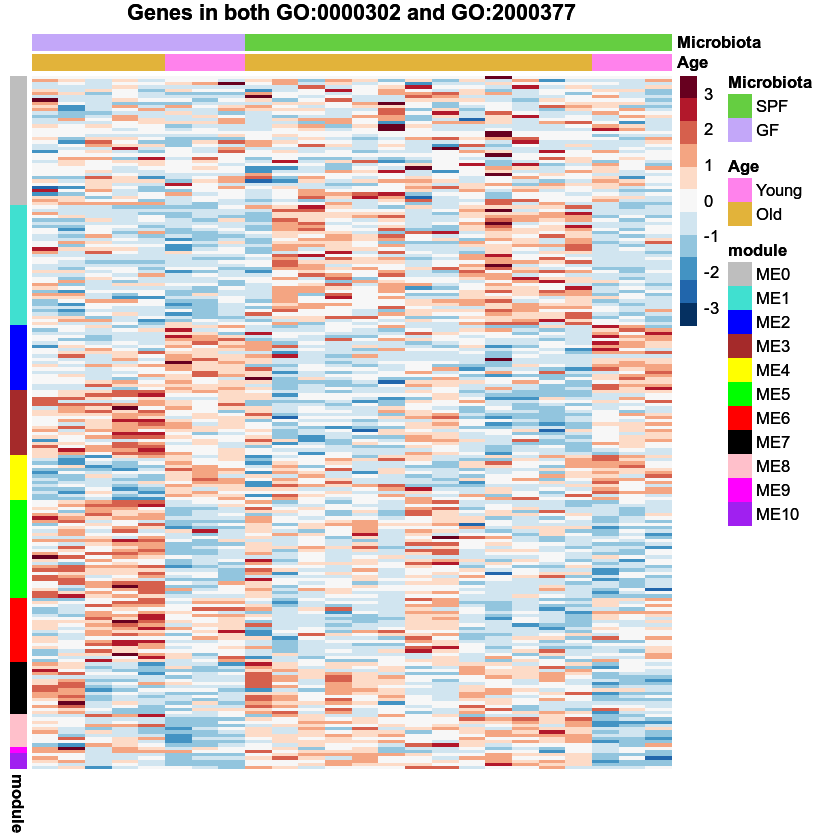

In [88]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377")

Only for genes in ME7 and ME8

In [89]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
ROS_genes_in_ME7_ME8 = ROS_genes %>%
    filter(Name %in% ME7_ME8_genes)

png 
  2

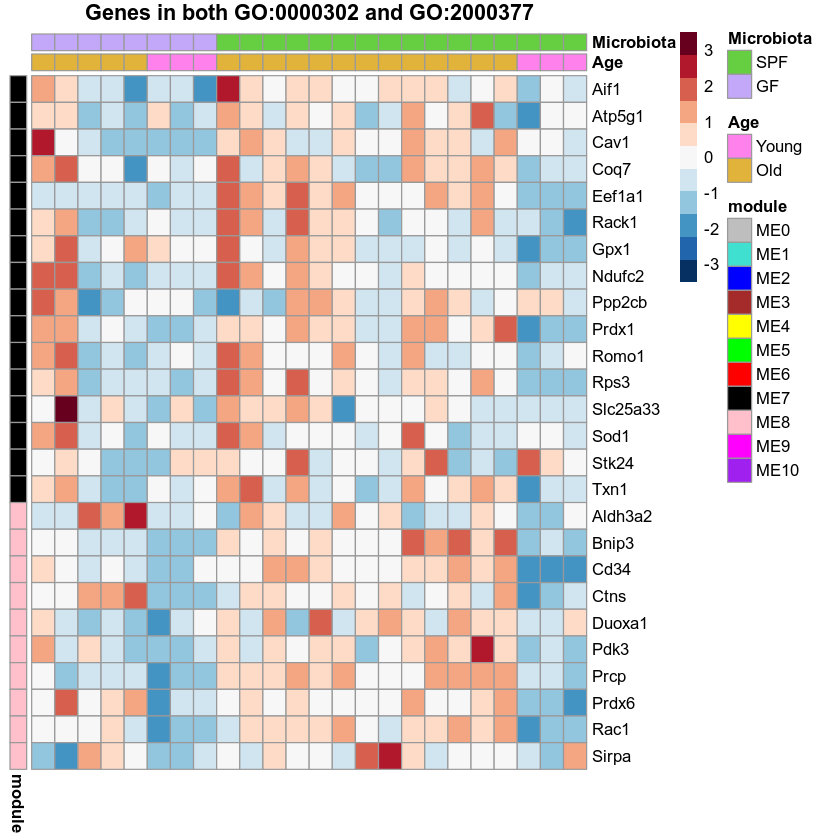

In [90]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes_in_ME7_ME8$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377",
    show_rownames=TRUE,
    fp=paste(module_dp, 'ros_genes_me7_me8.pdf', sep=''))

Only for genes in ME2, ME7 and ME8

In [91]:
MEs_genes = c(genes_in_modules$ME2, genes_in_modules$ME7, genes_in_modules$ME8)
ROS_genes_in_MEs = ROS_genes %>%
    filter(Name %in% MEs_genes)

png 
  2

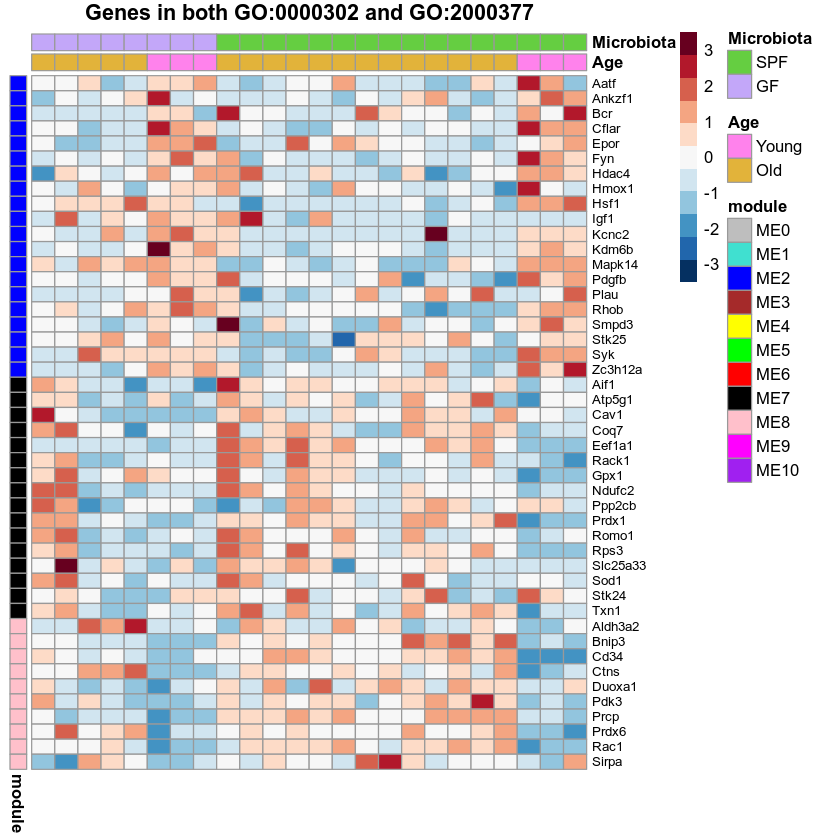

In [92]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes_in_MEs$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377",
    show_rownames=TRUE,
    fp=paste(module_dp, 'ros_genes_mes.pdf', sep=''),
    fontsize_row=8)

#### Genes in both GO:0000302 and GO:2000377 and extra list

In [93]:
extra_ROS_genes = read.csv("../data/extra_ros_genes.csv") %>% 
    select(c(name, description, initial_alias)) %>% 
    rename(Name = name) %>%
    rename(Description = description)  %>%
    rename(MGI.id = initial_alias)

In [94]:
ROS_genes = rbind(GO_0000302_ROS_genes, GO_2000377_ROS_genes, extra_ROS_genes)

In [95]:
ROS_genes_z_scores = z_scores
genes = ROS_genes$Name[ROS_genes$Name %in% rownames(ROS_genes_z_scores)]
# get genes ordered by modules
genes_in_mod = c()
for(x in names(genes_in_modules)){
    g_in_mod_id = intersect(genes_in_modules[[x]], genes)
    new_c = rep(x, length(g_in_mod_id))
    names(new_c) = g_in_mod_id
    genes_in_mod = c(genes_in_mod, new_c)
}
# order the z-score matrix by genes in genes_in_mod
ROS_genes_z_scores = cbind(genes_in_mod, ROS_genes_z_scores[names(genes_in_mod), col_order$ma])
head(ROS_genes_z_scores)
write.table(ROS_genes_z_scores, file=paste(plot_dp, "ROS_genes_z_scores.tsv", sep=''), sep='\t', quote=FALSE, row.names = FALSE)

genes_in_mod GF_104w_M_1_2 GF_104w_M_2_2 GF_104w_M_3_2 GF_104w_M_4_2
Acp5   ME0          -0.2449451    -0.22912101   -0.1180970    -0.16867211  
Coa8   ME0           1.1666547     0.80455562   -0.4501192     0.59129761  
Bcl2   ME0          -0.5169556     0.09058508   -0.4655940    -0.07248433  
Brca1  ME0          -0.6099009    -0.71907015   -0.7190701     0.49988799  
Casp3  ME0           0.8887958    -0.32140023    0.7491231     0.22901594  
Cdkn1a ME0           1.4553187     0.42902194   -0.9618197    -0.24459006  
       GF_104w_M_5_2 GF_8w_M_1_2 GF_8w_M_3_2 GF_8w_M_4_2 SPF_104w_M_1_2 ⋯
Acp5   -0.2449451    -0.07877723 -0.04094943 -0.1910879  -0.24494513    ⋯
Coa8   -0.9250222    -0.09933503  0.07556645 -0.7571718   0.42881403    ⋯
Bcl2   -0.2788285     0.58971773  0.97164259  3.5060615   0.08851554    ⋯
Brca1  -0.6864946    -0.71907015 -0.49615326 -0.6396190  -0.71907015    ⋯
Casp3  -1.3599779     0.32205021 -0.23020002 -0.1847169  -1.94722894    ⋯
Cdkn1a -0.6682312    -0.96509402 -1.28686122 -1.2547117   1.20365841    ⋯
       SPF_104w_M_2_2 SPF_104w_M_4_2 SPF_104w_M_5_2 SPF_104w_M_6_2
Acp5   -0.21880238    -0.2449451     -0.2449451      4.6864932    
Coa8    0.84610407    -0.9965784      0.5635747     -0.9524259    
Bcl2   -1.73217938    -0.6541359     -0.5609479      0.4464055    
Brca1   2.30194968    -0.1518610      0.1127063     -0.6882963    
Casp3  -0.09326567    -0.9396330      0.6499702     -1.2079565    
Cdkn1a  1.11500582     1.9599200      0.3575631      1.5006736    
       SPF_104w_M_7_2 SPF_104w_M_8_2 SPF_104w_M_9_2 SPF_8w_M_2_2 SPF_8w_M_3_2
Acp5   -0.1217642     -0.24494513    -0.2449451     -0.2116806   -0.2174026  
Coa8    1.0833723     -2.13547454    -0.4866950     -0.7213056   -0.5211382  
Bcl2   -0.2233359     -0.24794378    -0.2472046     -0.2137801   -0.8918519  
Brca1   2.7501010     -0.48393908     0.4625673     -0.5009707   -0.7190701  
Casp3  -0.3675029      0.26159960     0.1999860      0.3823015    0.8833020  
Cdkn1a -0.3518414     -0.06989607    -1.3346434      0.2332681   -0.4442387  
       SPF_8w_M_4_2
Acp5   -0.2449451  
Coa8    1.4248375  
Bcl2   -0.4746894  
Brca1   0.6851518  
Casp3  -1.2845776  
Cdkn1a -1.2066130

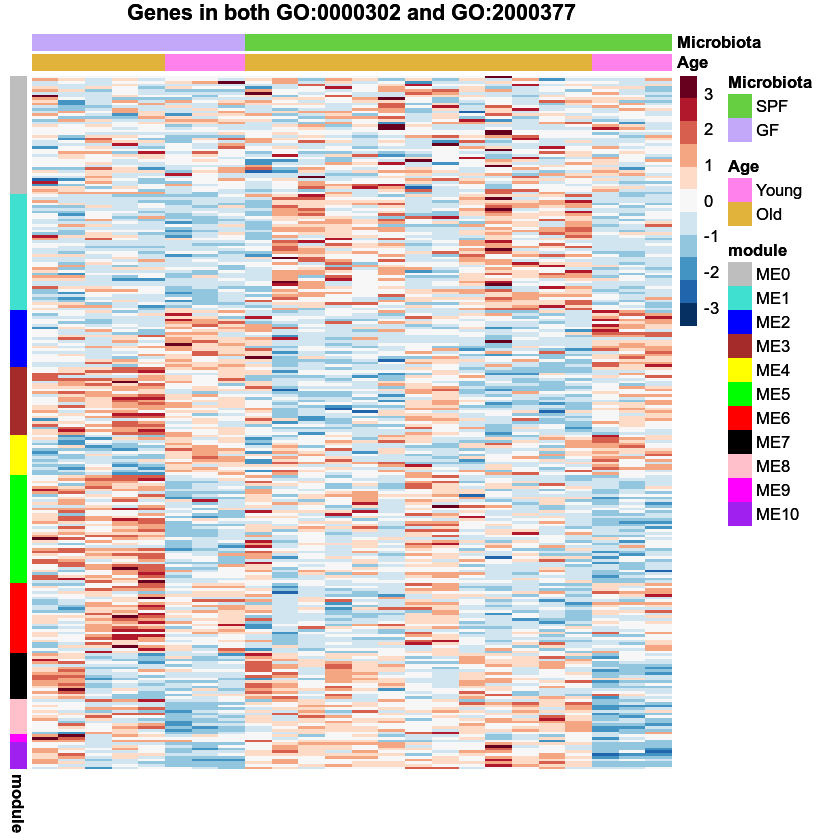

In [96]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377")

Only for genes in ME7 and ME8

In [97]:
ME7_ME8_genes = c(genes_in_modules$ME7, genes_in_modules$ME8)
ROS_genes_in_ME7_ME8 = ROS_genes %>%
    filter(Name %in% ME7_ME8_genes)

png 
  2

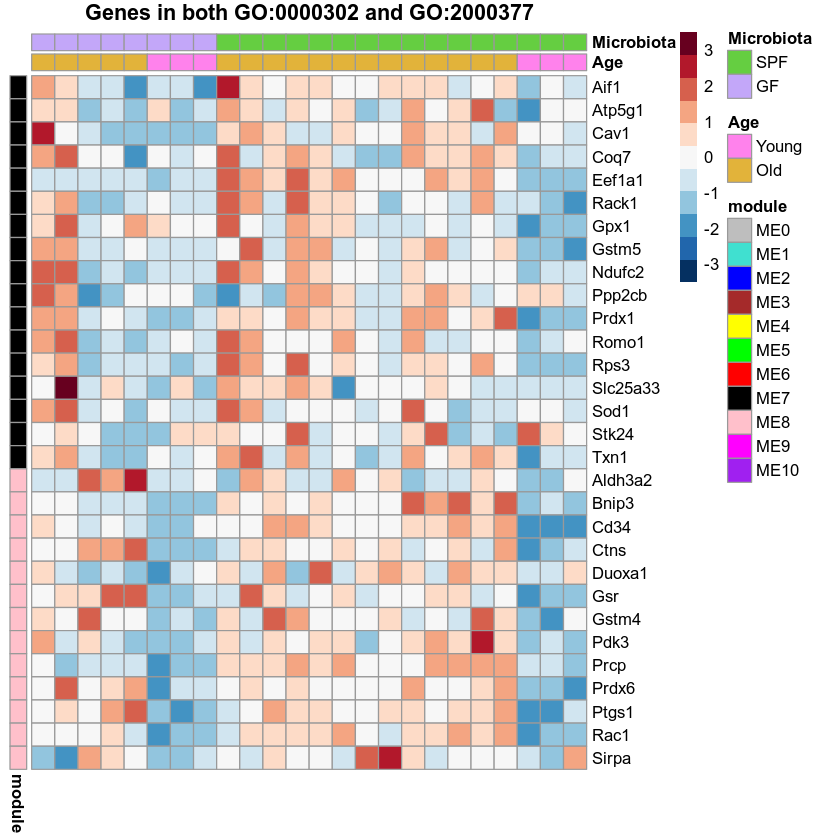

In [98]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes_in_ME7_ME8$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "Genes in both GO:0000302 and GO:2000377",
    show_rownames=TRUE,
    fp=paste(module_dp, 'ros_genes_me7_me8.pdf', sep=''))

Only for genes in ME2, ME7 and ME8

In [99]:
MEs_genes = c(genes_in_modules$ME1, genes_in_modules$ME2, genes_in_modules$ME8)
ROS_genes_in_MEs = ROS_genes %>%
    filter(Name %in% MEs_genes)

png 
  2

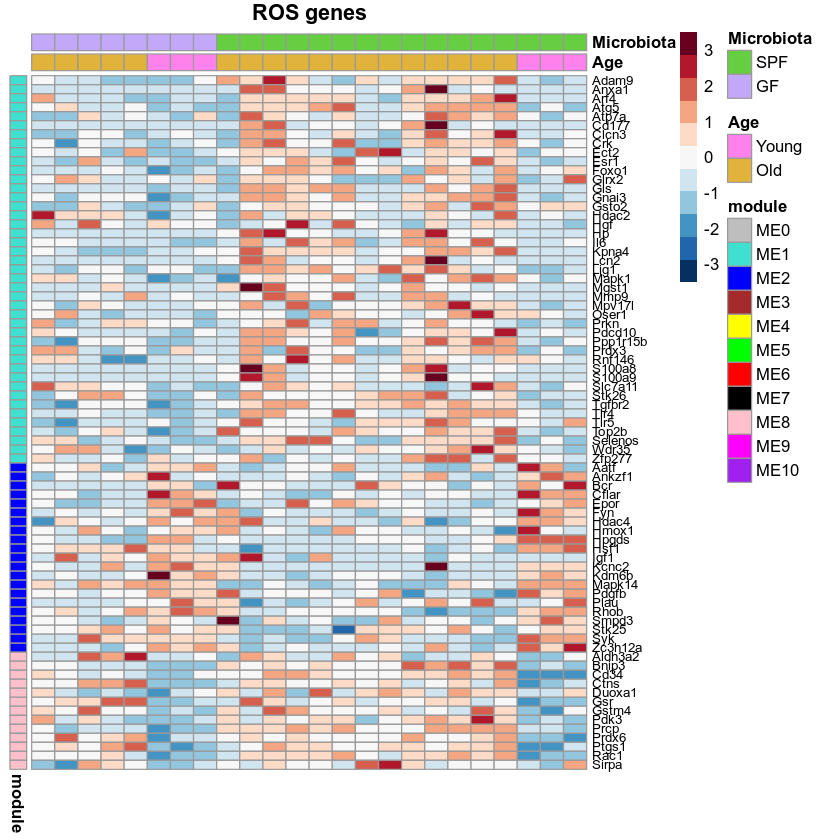

In [100]:
plot_z_score_heatmap_with_modules(
    z_scores,
    ROS_genes_in_MEs$Name,
    col_order$ma,
    annot_col$ma,
    genes_in_modules,
    "ROS genes",
    show_rownames=TRUE,
    fp=paste(module_dp, 'ros_genes_mes.pdf', sep=''),
    fontsize_row=8)

## Enrichment analysis in modules

In [101]:
x = names(mod_sizes)[1]
pwf = suppressMessages(nullp(genes_in_modules_bool[, x], 'mm10', 'geneSymbol', plot.fit=F)) 

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”


In [102]:
for(x in names(mod_sizes)){
    print(x)
    pwf = suppressMessages(nullp(genes_in_modules_bool[, x], 'mm10', 'geneSymbol', plot.fit=F))                        
    GO_wall = goseq(pwf, 'mm10', 'geneSymbol')
    adj_GO_wall = GO_wall[p.adjust(GO_wall[,"over_represented_pvalue"], method="BH")<.05,]
    print(head(adj_GO_wall[adj_GO_wall$ontology == "BP",]))
    write.table(adj_GO_wall, paste(module_dp, x, "_GO", sep=""), sep = "\t", quote = FALSE, row.names = FALSE)    
}

[1] "ME0"


Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
12689 GO:0051983            3.969897e-07                0.9999999         32
7143  GO:0031577            5.047417e-07                0.9999999         21
3235  GO:0007059            1.493575e-06                0.9999995         78
10495 GO:0044784            1.747588e-06                0.9999996         25
14447 GO:0071174            2.117516e-06                0.9999996         19
7961  GO:0033045            2.157269e-06                0.9999995         26
      numInCat                                        term ontology
12689       73        regulation of chromosome segregation       BP
7143        39                spindle checkpoint signaling       BP
3235       260                      chromosome segregation       BP
10495       54 metaphase/anaphase transition of cell cycle       BP
14447       36        mitotic spindle checkpoint signaling       BP
7961        58  regulation of sister chromatid segreg

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
10226 GO:0043632            2.132355e-05                0.9999867        142
14207 GO:0070647            2.473343e-05                0.9999839        169
2870  GO:0006511            3.006637e-05                0.9999813        137
      numInCat                                                         term
10226      542       modification-dependent macromolecule catabolic process
14207      661 protein modification by small protein conjugation or removal
2870       522                ubiquitin-dependent protein catabolic process
      ontology
10226       BP
14207       BP
2870        BP
[1] "ME2"


Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
2748  GO:0006325            2.952268e-08                1.0000000         84
15397 GO:0090304            8.191387e-08                1.0000000        482
12329 GO:0051252            2.549534e-07                1.0000000        343
10463 GO:0044648            4.319021e-07                1.0000000          7
15852 GO:0097692            5.377362e-07                1.0000000          8
5844  GO:0019219            8.871281e-07                0.9999996        366
      numInCat                                                           term
2748       381                                         chromatin organization
15397     3266                                 nucleic acid metabolic process
12329     2224                            regulation of RNA metabolic process
10463        7                                    histone H3-K4 dimethylation
15852        9                                  histone H3-K4 monomethy

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



[1] category                 over_represented_pvalue  under_represented_pvalue
[4] numDEInCat               numInCat                 term                    
[7] ontology                
<0 rows> (or 0-length row.names)
[1] "ME4"


Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
19388 GO:2000112            6.418756e-14                        1        303
12329 GO:0051252            9.245058e-14                        1        287
4329  GO:0010556            1.019973e-13                        1        305
5138  GO:0016070            4.964805e-13                        1        343
2763  GO:0006357            6.888485e-13                        1        212
2761  GO:0006355            7.508933e-13                        1        261
      numInCat                                                      term
19388     2384 regulation of cellular macromolecule biosynthetic process
12329     2224                       regulation of RNA metabolic process
4329      2414          regulation of macromolecule biosynthetic process
5138      2874                                     RNA metabolic process
2763      1510          regulation of transcription by RNA polymerase II
2761      1998         

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
3083  GO:0006810            6.926706e-11                        1        297
12316 GO:0051234            3.659667e-10                        1        304
3084  GO:0006811            5.943842e-10                        1        104
2547  GO:0005975            9.871707e-10                        1         67
12296 GO:0051179            1.126100e-09                        1        375
2618  GO:0006091            1.241972e-09                        1         59
      numInCat                                           term ontology
3083      2627                                      transport       BP
12316     2739                  establishment of localization       BP
3084       705                                  ion transport       BP
2547       382                 carbohydrate metabolic process       BP
12296     3595                                   localization       BP
2618       299 generation of precur

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
11886 GO:0048856            4.512945e-15                        1        327
3349  GO:0007275            1.362339e-14                        1        305
11841 GO:0048731            2.808184e-14                        1        279
7624  GO:0032502            2.816748e-13                        1        340
12064 GO:0050793            4.735890e-13                        1        177
4133  GO:0009653            4.063954e-12                        1        178
      numInCat                                term ontology
11886     3149    anatomical structure development       BP
3349      2893  multicellular organism development       BP
11841     2584                  system development       BP
7624      3412               developmental process       BP
12064     1452 regulation of developmental process       BP
4133      1499  anatomical structure morphogenesis       BP
[1] "ME7"


Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
2801  GO:0006412            2.024468e-19                        1         99
9899  GO:0043043            1.098185e-18                        1         99
2875  GO:0006518            1.327643e-16                        1        105
10207 GO:0043604            2.282040e-16                        1        101
7986  GO:0033108            3.449803e-16                        1         37
3201  GO:0007005            2.449848e-13                        1         72
      numInCat                                             term ontology
2801       519                                      translation       BP
9899       532                     peptide biosynthetic process       BP
2875       637                        peptide metabolic process       BP
10207      601                       amide biosynthetic process       BP
7986        80 mitochondrial respiratory chain complex assembly       BP
3201       411         

Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Warning message in pcls(G):
“initial point very close to some inequality constraints”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
12296 GO:0051179            2.700745e-10                        1        244
3083  GO:0006810            8.219709e-09                        1        185
2965  GO:0006629            9.788087e-09                        1         73
12316 GO:0051234            1.456790e-08                        1        190
12844 GO:0055085            4.661896e-08                        1         65
10353 GO:0044255            5.101828e-08                        1         59
      numInCat                             term ontology
12296     3595                     localization       BP
3083      2627                        transport       BP
2965       759          lipid metabolic process       BP
12316     2739    establishment of localization       BP
12844      667          transmembrane transport       BP
10353      584 cellular lipid metabolic process       BP
[1] "ME9"


Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
16636 GO:0140053            1.431986e-06                0.9999998         13
7646  GO:0032543            1.971363e-05                0.9999971         10
      numInCat                          term ontology
16636      101 mitochondrial gene expression       BP
7646        73     mitochondrial translation       BP
[1] "ME10"


Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”
Fetching GO annotations...

For 133 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



        category over_represented_pvalue under_represented_pvalue numDEInCat
3172  GO:0006955            8.519494e-17                        1         60
8817  GO:0035456            1.254317e-16                        1         15
3169  GO:0006952            1.268388e-15                        1         55
8819  GO:0035458            6.459123e-15                        1         13
9980  GO:0043207            8.962442e-15                        1         50
12556 GO:0051707            8.962442e-15                        1         50
      numInCat                                 term ontology
3172       971                      immune response       BP
8817        38          response to interferon-beta       BP
3169       885                     defense response       BP
8819        32 cellular response to interferon-beta       BP
9980       772 response to external biotic stimulus       BP
12556      772           response to other organism       BP


# Citations

In [103]:
citation("WGCNA")


To cite WGCNA in publications use:

  Langfelder P and Horvath S, WGCNA: an R package for weighted
  correlation network analysis. BMC Bioinformatics 2008, 9:559
  doi:10.1186/1471-2105-9-559

  Peter Langfelder, Steve Horvath (2012). Fast R Functions for Robust
  Correlations and Hierarchical Clustering. Journal of Statistical
  Software, 46(11), 1-17. URL http://www.jstatsoft.org/v46/i11/.

We have invested a lot of time and effort in creating the package,
please cite it when using it for data analysis.
To see these entries in BibTeX format, use 'print(<citation>,
bibtex=TRUE)', 'toBibtex(.)', or set
'options(citation.bibtex.max=999)'.


In [104]:
citation("sinaplot")
toBibtex(citation("sinaplot"))


To cite sinaplot in publications, please use:

  Sidiropoulos. N, Sohi S.H., Rapin N., Bagger F.O. (2017). An Enhanced
  Chart for Simple and Truthful Representation of Single Observations
  over Multiple Classes, R package version 1.1.0.

  Sidiropoulos. N, Sohi S.H., Rapin N., Bagger F.O., SinaPlot: an
  enhanced chart for simple and truthful representation of single
  observations over multiple classes. bioRxiv doi:
  http://dx.doi.org/10.1101/028191

To see these entries in BibTeX format, use 'print(<citation>,
bibtex=TRUE)', 'toBibtex(.)', or set
'options(citation.bibtex.max=999)'.


@Manual{,
  title = {An Enhanced Chart for Simple and Truthful Representation of
Single Observations over Multiple Classes},
  author = {Sidiropoulos N. and Sohi S.H. and Rapin N. and Bagger F.O.},
  publisher = {manual},
  year = {2017},
  note = {R package version 1.1.0},
  url = {https://cran.r-project.org/package=sinaplot},
}

@TechReport{,
  title = {SinaPlot: an enhanced chart for simple and truthful representation of single observations over multiple classes},
  author = {Nikos Sidiropoulos and Sina Hadi Sohi and Nicolas Rapin and Frederik Otzen Bagger},
  booktitle = {bioRxiv},
  institution = {Cold Spring Harbor Labs Journals},
  year = {2015},
  month = {Oct},
  doi = {10.1101/028191},
  url = {http://biorxiv.org/content/early/2015/10/02/028191.abstract},
}

In [105]:
citation("goseq")


The methods within the code package can be cited as:

  Young, M.D., Wakefield, M.J., Smyth, G.K., Oshlack, A., Gene ontology
  analysis for RNA-seq: accounting for selection bias, Genome Biology,
  11, 2, Feb 2010, R14

A BibTeX entry for LaTeX users is

  @Article{,
    title = {Gene ontology analysis for RNA-seq: accounting for selection bias},
    author = {Matthew D Young and Matthew J Wakefield and Gordon K Smyth and Alicia Oshlack},
    journal = {Genome Biology},
    volume = {11},
    pages = {R14},
    year = {2010},
  }

This free open-source software implements academic research by the
authors and co-workers. If you use it, please support the project by
citing the appropriate journal articles.


In [106]:
citation("org.Mm.eg.db")

Warning message in citation("org.Mm.eg.db"):
“no date field in DESCRIPTION file of package ‘org.Mm.eg.db’”



To cite package ‘org.Mm.eg.db’ in publications use:

  Marc Carlson (2021). org.Mm.eg.db: Genome wide annotation for Mouse.
  R package version 3.14.0.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {org.Mm.eg.db: Genome wide annotation for Mouse},
    author = {Marc Carlson},
    year = {2021},
    note = {R package version 3.14.0},
  }

ATTENTION: This citation information has been auto-generated from the
package DESCRIPTION file and may need manual editing, see
‘help("citation")’.
